# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [4]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')
print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")

Last modified: 13 February 2026, 17:59 IST


In [5]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from hww_tools import *
%matplotlib inline

In [6]:
!ls

HWW_analysis.ipynb  hww_tools  hww_tools.zip


# Imports 

In [7]:
import os
import sys
import time
import gc
import psutil
import json
# from pathlib import Path
import csv

# Data processing
# import uproot
# import awkward as ak
# import numpy as np

# # Visualization
# import matplotlib.pyplot as plt
# %matplotlib inline
# import matplotlib.patches as mpatches
# import mplhep as hep
import pandas as pd
# Numerical computing
# import vector
# import hist
# from hist import Hist
from tqdm import tqdm
!pip install prettytable
# Parallel processing 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.distributed import progress

# others
# !pip install prettytable
# from prettytable import PrettyTable

# vector.register_awkward()

print(" All imports loaded")

 All imports loaded


## Setting up dask client

In [8]:
client = Client("tls://localhost:8786")
client

<Client: 'tls://192.168.235.88:8786' processes=1 threads=1, memory=2.89 GiB>

In [9]:
import sys
import os

# 1. Get the absolute path to your project root (the folder containing hww_tools)
# Assuming your notebook is in 'notebooks/' and hww_tools is in the parent dir:
# project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
project_path = os.getcwd()

print(f"Project path is: {project_path}")

# 2. Define a function that adds this path to python's list of paths
def add_path_to_worker(path):
    import sys
    if path not in sys.path:
        sys.path.append(path)

# 3. Run this function on all connected workers
client.run(add_path_to_worker, project_path)

Project path is: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis


{'tls://129.93.182.103:42651': None}

In [10]:
import shutil
import os

# 1. Define the zip file name
# This creates a zip file of your 'hww_tools' folder in the current directory
zip_name = "hww_tools"
shutil.make_archive(zip_name, 'zip', os.getcwd(), "hww_tools")

# 2. Upload the zip file to the cluster
# Dask will automatically unzip this on the workers and add it to their path
print(f"Uploading {zip_name}.zip to cluster...")
client.upload_file(f"{zip_name}.zip")
print("Upload complete. Workers can now import hww_tools.")

Uploading hww_tools.zip to cluster...
Upload complete. Workers can now import hww_tools.


In [11]:
def verify_worker_import():
    import sys
    import os
    
    # Try importing
    try:
        import hww_tools
        return f"SUCCESS: Imported hww_tools from {hww_tools.__file__}"
    except ImportError as e:
        # Debug info if it fails
        return f"FAILURE: {e}. CWD contents: {os.listdir('.')}"

# Run on all workers
print("Verifying import on workers...")
results = client.run(verify_worker_import)
for worker, result in results.items():
    print(f"{worker}: {result}")

Verifying import on workers...
tls://129.93.182.103:42651: SUCCESS: Imported hww_tools from /var/lib/condor/execute/dir_3001320/dask-scratch-space/worker-m1f40hq7/hww_tools.zip/hww_tools/__init__.py


## Loading Files

In [12]:
files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=1)  # TESTING
# files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)


FILES TO PROCESS
Data                :    1 files
VG                  :    1 files
ggH_HWW             :    1 files
WW                  :    1 files
Fakes               :    1 files
Diboson             :    1 files
DY_to_Tau_Tau       :    1 files
ggWW                :    1 files
Top_antitop         :    1 files
______________________________________________________________________
TOTAL               :    9 files


# Histogram Initialization

In [13]:
VARIATIONS = ['nominal', 'trigger_up', 'trigger_down', 'ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']

variables_to_plots = {
    'mass': hist.axis.Regular(20, 0, 200, name="mass", label="m_ll [GeV]"),
    'met': hist.axis.Regular(20, 0, 200, name="met", label="MET [GeV]"),
    'dphi': hist.axis.Regular(20, 0, np.pi, name="dphi", label="dphi(l,l)"),
    'ptll': hist.axis.Regular(20, 0, 200, name="ptll", label="p_T^ll [GeV]"),
    'mt_higgs': hist.axis.Regular(20, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
    'mt_l2_met': hist.axis.Regular(20, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
    'mjj': hist.axis.Regular(20, 0, 500, name="mjj", label="m_jj [GeV]"),
    'leading_pt': hist.axis.Regular(20, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
    'subleading_pt': hist.axis.Regular(20, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
}

def initialize_stage_histograms(stages_list, vars_dict, variations_list):
    stage_histograms = {}
    for stage in stages_list:
        stage_histograms[stage] = {}
        for var_name, axis in vars_dict.items():
            stage_histograms[stage][var_name] = {}
            for syst in variations_list:
                stage_histograms[stage][var_name][syst] = hist.Hist(axis, storage=hist.storage.Weight())
    return stage_histograms

hist_data = {}


for label in sorted(stack_order.keys(), key=lambda x: stack_order[x]):
    hist_data[label] = initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)

print(f"Histogram storage initialized for {len(hist_data)} samples.")

Histogram storage initialized for 8 samples.


# Processing

## Processing function

In [14]:
def make_processor(golden_json_data, sample_info_detailed, luminosity, run_periods, project_dir):

    # Helper function (captured by closure)
    def get_sample_key(filename):
        fn = filename
        if any(x in fn for x in ["Run2016", "SingleMuon", "DoubleEG", "MuonEG"]): return None
        if "DYJetsToLL" in fn:         return "DYJetsToLL_M-50"
        if "TTTo2L2Nu" in fn:          return "TTTo2L2Nu"
        if "ST_t-channel_top" in fn:   return "ST_t-channel_top"
        if "ST_t-channel_antitop" in fn: return "ST_t-channel_antitop"
        if "ST_tW_antitop" in fn:      return "ST_tW_antitop"
        if "ST_tW_top" in fn:          return "ST_tW_top"
        if "ST_s-channel" in fn:       return "ST_s-channel"
        if "WJetsToLNu" in fn:         return "WJetsToLNu"
        if "TTToSemiLeptonic" in fn:   return "TTToSemiLeptonic"
        if "ZGToLLG" in fn:            return "ZGToLLG"
        if "WGToLNuG" in fn:           return "WGToLNuG"
        if "WZTo3LNu" in fn:           return "WZTo3LNu"
        if "WZTo2Q2L" in fn:           return "WZTo2Q2L"
        if "ZZ" in fn:                 return "ZZ"
        if "GluGluToWW" in fn:         return "GluGluToWW"
        if "WWTo2L2Nu" in fn:          return "WWTo2L2Nu"
        if "GluGluHToWW" in fn or "Higgs" in fn: return "Higgs"
        return "Unknown" 

    # =========================================================================
    #        WORKER FUNCTION (Runs on Dask Worker)
    # =========================================================================
    def processing_file(label, file_url, file_idx):
        import sys
        import os
        import time
        import awkward as ak
        import numpy as np
        import vector
        
        # --- CRITICAL FIX: Tell the worker where hww_tools is ---
        # This must run BEFORE importing hww_tools
        # if project_dir not in sys.path:
        #     sys.path.append(project_dir)
        # -------------------------------------------------------

        # Import modules from your package
        from hww_tools import (
            Config,
            Efficiency_data,
            Physics_selection,
            calculations,
            cuts,
            helper,
            json_validation,
            Plots_config  # Needed for default variables if not in global scope
        )
        
        # Register vector behavior
        vector.register_awkward()

        file_name = file_url.split('/')[-1] 
        is_data = (label == 'Data')
        specific_sample_key = get_sample_key(file_url)

        # Retrieve Configuration (Safe fallback to Config module if globals are missing on worker)
        # Note: 'cutflow_stages', 'VARIATIONS', 'stage_names' are pulled from Config 
        # to ensure the worker has the definitions even if the notebook scope is partial.
        cutflow_stages = getattr(Config, 'cutflow_stages', ['total', 'after_json', 'e_mu_preselection', 'global_cuts', '0jet', '1jet', '2jet', 'SR_0jet', 'SR_1jet', 'SR_2jet', 'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet', 'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'])
        VARIATIONS = getattr(Config, 'VARIATIONS', ['nominal', 'trigger_up', 'trigger_down', 'ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down'])
        stage_names = getattr(Config, 'stage_names', ['before_cuts', 'global', '0jet', '1jet', '2jet', 'SR_0jet', 'SR_1jet', 'SR_2jet', 'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet', 'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'])
        
        # Use Plots_config to get variables if needed, otherwise rely on logic
        variables_to_plots = getattr(Plots_config, 'variables_to_plots', Plots_config.PLOT_SETTINGS['Signal_Region']['variables'])

        empty_cutflow = {stage: 0 for stage in cutflow_stages}
        
        # ---------------------------------------------------------------------
        #        Histogram Filling Helper
        # ---------------------------------------------------------------------
        def fill_histograms(stage_name, mask, weights_dict, 
                           masses, met_pt, dphis, ptlls,
                           mt_higgs, mt_l2_met, mjj,
                           leading_pt, subleading_pt):
            
            if not isinstance(mask, np.ndarray):
                mask = ak.to_numpy(mask)

            if np.sum(mask) == 0:
                return

            def masked(arr, flatten=False):
                sliced = arr[mask]
                if flatten:
                    sliced = ak.flatten(sliced)
                return ak.to_numpy(sliced)

            # Loop over all systematic variations
            for syst in VARIATIONS:
                w_syst = weights_dict.get(syst, weights_dict['nominal'])
                w = masked(w_syst)

                stage_histograms[stage_name]['mass'][syst].fill(masked(masses), weight=w)
                stage_histograms[stage_name]['met'][syst].fill(masked(met_pt), weight=w)
                stage_histograms[stage_name]['dphi'][syst].fill(masked(dphis), weight=w)
                stage_histograms[stage_name]['ptll'][syst].fill(masked(ptlls), weight=w)
                stage_histograms[stage_name]['mt_higgs'][syst].fill(masked(mt_higgs), weight=w)
                stage_histograms[stage_name]['mt_l2_met'][syst].fill(masked(mt_l2_met), weight=w)
                stage_histograms[stage_name]['mjj'][syst].fill(masked(mjj), weight=w)
                stage_histograms[stage_name]['leading_pt'][syst].fill(masked(leading_pt), weight=w)
                stage_histograms[stage_name]['subleading_pt'][syst].fill(masked(subleading_pt), weight=w)
        
        # ---------------------------------------------------------------------
        #        Main Event Loop
        # ---------------------------------------------------------------------
        try:
            # CALL GLOBAL FUNCTION (Defined in notebook)
            stage_histograms = initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
            
            cutflow = empty_cutflow.copy()
            weighted_cutflow = {stage: 0.0 for stage in cutflow_stages}
            
            max_file_retries = 3
            
            for file_attempt in range(max_file_retries):
                try:
                    for arrays in helper.load_events(file_url, batch_size= 1_000_000, is_data=is_data):
                        
                        cutflow['total'] += len(arrays)

                        # --- SCALING & VARIATIONS INITIALIZATION ---
                        if is_data:
                            base_weight = ak.ones_like(arrays.PuppiMET_pt, dtype=float)
                        elif specific_sample_key in sample_info_detailed:
                            info = sample_info_detailed[specific_sample_key]
                            scale_factor = (info['xsec'] * luminosity) / info['sum_genWeight']
                            base_weight = arrays.genWeight * scale_factor
                        else:
                            base_weight = ak.zeros_like(arrays.PuppiMET_pt, dtype=float)

                        # Initialize Dictionary of Weights
                        weights_dict = {v: base_weight for v in VARIATIONS}

                        # --- APPLY TRIGGER SF & UNCERTAINTY (MC ONLY) ---
                        if not is_data:
                            weights_dict['nominal'] = weights_dict['nominal'] * Efficiency_data.TRIGGER_SF_VAL
                            weights_dict['trigger_up']   = weights_dict['trigger_up'] * (Efficiency_data.TRIGGER_SF_VAL + Efficiency_data.TRIGGER_SF_ERR)
                            weights_dict['trigger_down'] = weights_dict['trigger_down'] * (Efficiency_data.TRIGGER_SF_VAL - Efficiency_data.TRIGGER_SF_ERR)
                            
                            for var in ['ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']:
                                weights_dict[var] = weights_dict[var] * Efficiency_data.TRIGGER_SF_VAL

                        weighted_cutflow['total'] += float(ak.sum(weights_dict['nominal']))
                        
                        # --- JSON MASK (DATA ONLY) ---
                        if is_data and golden_json_data is not None:
                            try:
                                json_mask = json_validation.apply_json_mask(arrays, golden_json_data, run_periods=run_periods)
                                n_events_after = int(ak.sum(json_mask))
                                cutflow['after_json'] += n_events_after
                                weighted_cutflow['after_json'] += float(ak.sum(weights_dict['nominal'][json_mask]))

                                if n_events_after == 0:
                                    continue

                                arrays = arrays[json_mask]
                                for k in weights_dict:
                                    weights_dict[k] = weights_dict[k][json_mask]
                            except Exception as e: 
                                print(f"Warning: JSON mask failed for {file_name}: {e}")
                        
                        # --- LEPTON SELECTION ---
                        tight_leptons, _, _ = Physics_selection.select_tight_leptons(arrays)
                        met = ak.zip({"pt": arrays.PuppiMET_pt, "phi": arrays.PuppiMET_phi})
                        
                        leading, subleading, emu_cutflow, met_selected = Physics_selection.select_e_mu_events(tight_leptons, met)
                        
                        if leading is None or len(leading) == 0:
                            continue

                        sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                        has_2lep = ak.num(sorted_leptons) == 2
                        events_2lep = sorted_leptons[has_2lep]
                        
                        if len(events_2lep) == 0:
                            continue
                        
                        lead_all = events_2lep[:, 0]
                        sublead_all = events_2lep[:, 1]
                        
                        mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                     ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                        mask_charge = lead_all.charge * sublead_all.charge < 0
                        mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 13)
                        
                        eta_leading = ((lead_all.flavor == 11) & (abs(lead_all.eta) < 2.5)) | \
                                      ((lead_all.flavor == 13) & (abs(lead_all.eta) < 2.4))

                        eta_subleading = ((sublead_all.flavor == 11) & (abs(sublead_all.eta) < 2.5)) | \
                                         ((sublead_all.flavor == 13) & (abs(sublead_all.eta) < 2.4))
                        
                        mask_eta = eta_leading & eta_subleading
                        
                        emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt & mask_eta
                        
                        indices_2lep = ak.where(has_2lep)[0]
                        indices_selected = ak.to_numpy(indices_2lep[emu_mask_2lep])
                        
                        emu_mask_full = np.zeros(len(has_2lep), dtype=bool)
                        emu_mask_full[indices_selected] = True
                        
                        for k in weights_dict:
                            weights_dict[k] = weights_dict[k][emu_mask_full]

                        # --- LEPTON SCALE FACTORS & UNCERTAINTIES (MC ONLY) ---
                        if not is_data:
                            # 1. Prepare Electron SFs
                            is_lead_ele = (leading.flavor == 11)
                            ele_pt = ak.where(is_lead_ele, leading.pt, subleading.pt)
                            ele_eta = ak.where(is_lead_ele, leading.eta, subleading.eta)

                            # Get Nominal and Error
                            ele_sf_nom, ele_sf_err = helper.get_sf_with_uncertainty(ele_eta, ele_pt, Efficiency_data.ELECTRON_SF_DATA)

                            # 2. Prepare Muon SFs
                            is_lead_mu = (leading.flavor == 13)
                            mu_pt = ak.where(is_lead_mu, leading.pt, subleading.pt)
                            mu_eta = ak.where(is_lead_mu, leading.eta, subleading.eta)

                            mu_tight_nom, mu_tight_err = helper.get_sf_with_uncertainty(mu_eta, mu_pt, Efficiency_data.MUON_TIGHT_DATA)
                            mu_iso_nom, mu_iso_err = helper.get_sf_with_uncertainty(mu_eta, mu_pt, Efficiency_data.MUON_ISO_DATA)
                            
                            # Combined Muon Nominal
                            mu_sf_nom = mu_tight_nom * mu_iso_nom
                            
                            # Combined Muon Error
                            mu_sf_up = (mu_tight_nom + mu_tight_err) * (mu_iso_nom + mu_iso_err)
                            mu_sf_down = (mu_tight_nom - mu_tight_err) * (mu_iso_nom - mu_iso_err)
                            
                            # Electron Up/Down
                            ele_sf_up    = ele_sf_nom + ele_sf_err
                            ele_sf_down = ele_sf_nom - ele_sf_err

                            # 3. Apply to Weights
                            # Nominal
                            weights_dict['nominal'] = weights_dict['nominal'] * ele_sf_nom * mu_sf_nom
                            
                            # Trigger Variations
                            weights_dict['trigger_up']   = weights_dict['trigger_up'] * ele_sf_nom * mu_sf_nom
                            weights_dict['trigger_down'] = weights_dict['trigger_down'] * ele_sf_nom * mu_sf_nom
                            
                            # Electron Variations
                            weights_dict['ele_id_up']    = weights_dict['ele_id_up'] * ele_sf_up * mu_sf_nom
                            weights_dict['ele_id_down']  = weights_dict['ele_id_down'] * ele_sf_down * mu_sf_nom
                            
                            # Muon Variations
                            weights_dict['mu_id_up']     = weights_dict['mu_id_up'] * ele_sf_nom * mu_sf_up
                            weights_dict['mu_id_down']   = weights_dict['mu_id_down'] * ele_sf_nom * mu_sf_down
                        
                        cutflow['e_mu_preselection'] += len(leading)
                        weighted_cutflow['e_mu_preselection'] += float(ak.sum(weights_dict['nominal']))
                        
                        # --- KINEMATICS & FILLING ---
                        masses, ptlls, dphis, mt_higgs, mt_l2_met = calculations.cal_kinematic_var(
                            leading, subleading, met_selected
                        )
                        
                        mjj_before = ak.zeros_like(masses)
                        all_true = np.ones(len(masses), dtype=bool)
                        
                        fill_histograms(
                            'before_cuts', all_true, weights_dict,
                            masses, met_selected.pt, dphis, ptlls,
                            mt_higgs, mt_l2_met, mjj_before,
                            leading.pt, subleading.pt
                        )
                        
                        indices_emu = indices_selected
                        
                        n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = Physics_selection.count_jets(
                            arrays, tight_leptons=tight_leptons
                        )
                        
                        mjj_full = calculations.calculate_mjj(sorted_jets_full)
                        mjj_selected = ak.fill_none(mjj_full[indices_emu], 0.0)
                        
                        global_cut_mask, _ = cuts.apply_global_cuts(
                            leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses
                        )
                        bjet_veto_full, bjet_info_full = Physics_selection.apply_bjet_selections(arrays)
                        bjet_veto_selected = bjet_veto_full[indices_emu]
                        bjet_info_selected = {
                            key: value[indices_emu] for key, value in bjet_info_full.items()
                        }
                        
                        global_mask_selected = global_cut_mask & bjet_veto_selected
                        global_mask_np = ak.to_numpy(global_mask_selected)
                        
                        cutflow['global_cuts'] += int(np.sum(global_mask_np))
                        weighted_cutflow['global_cuts'] += float(ak.sum(weights_dict['nominal'][global_mask_np]))
                        
                        if np.sum(global_mask_np) == 0:
                            continue
                        
                        fill_histograms(
                            'global', global_mask_np, weights_dict,
                            masses, met_selected.pt, dphis, ptlls,
                            mt_higgs, mt_l2_met, mjj_selected,
                            leading.pt, subleading.pt
                        )
                        
                        # Jet categories
                        isZeroJet = ak.to_numpy(isZeroJet_full[indices_emu])
                        isOneJet = ak.to_numpy(isOneJet_full[indices_emu])
                        isTwoJet = ak.to_numpy(isTwoJet_full[indices_emu])

                        jet_categories = [
                            ('0jet', isZeroJet),
                            ('1jet', isOneJet),
                            ('2jet', isTwoJet)
                        ]
                        
                        for jet_name, jet_mask in jet_categories:
                            mask = global_mask_np & jet_mask
                            n_events = int(np.sum(mask))
                            cutflow[jet_name] += n_events
                            weighted_cutflow[jet_name] += float(ak.sum(weights_dict['nominal'][mask]))
                            
                            fill_histograms(
                                jet_name, mask, weights_dict,
                                masses, met_selected.pt, dphis, ptlls,
                                mt_higgs, mt_l2_met, mjj_selected,
                                leading.pt, subleading.pt
                            )
                        
                        # Signal and Control Regions
                        sr_regions = cuts.apply_signal_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_veto_selected, mjj_selected
                        )
                        
                        cr_regions = cuts.apply_control_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_info_selected, mjj_selected
                        )
                        
                        all_regions = {**sr_regions, **cr_regions}
                        
                        for region_name, region_mask in all_regions.items():
                            region_mask_np = ak.to_numpy(region_mask)
                            n_events = int(np.sum(region_mask_np))
                            cutflow[region_name] += n_events
                            weighted_cutflow[region_name] += float(ak.sum(weights_dict['nominal'][region_mask_np]))
                            
                            fill_histograms(
                                region_name, region_mask_np, weights_dict,
                                masses, met_selected.pt, dphis, ptlls,
                                mt_higgs, mt_l2_met, mjj_selected,
                                leading.pt, subleading.pt
                            )
                    
                    # Return results on success
                    return label, stage_histograms, cutflow, weighted_cutflow, None
                    
                except (OSError, IOError, ValueError) as e:
                    if file_attempt < max_file_retries - 1:
                        print(f"  {label}/{file_name}: {type(e).__name__} - Retry {file_attempt+1}/{max_file_retries}")
                        time.sleep(3)
                        continue
                    else: 
                        error_msg = f"{file_name}: {type(e).__name__} after {max_file_retries} attempts - {str(e)[:100]}"
                        return label, initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
                
                except Exception as e:
                    error_msg = f"{file_name}: {type(e).__name__} - {str(e)[:100]}"
                    return label, initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
            
            return label, stage_histograms, cutflow, weighted_cutflow, None
            
        except Exception as e:
            # Fatal error during initialization or high-level logic
            error_msg = f"{file_name}: Unexpected error - {str(e)[:100]}"
            
            # Fallback initialization (try-except in case globals are totally missing)
            try:
                fallback_hist = initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
            except:
                fallback_hist = None # Let the client handle the None
                
            return label, fallback_hist, empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg

    return processing_file

In [15]:
import time
import json
import os
import gc
import uproot
from distributed import progress

# ==============================================================================
# 1. SETUP & CONSTANTS
# ==============================================================================
print("\n" + "="*70)
print("PROCESSING START!! ")
print(f"Output Directory: {Config.OUTPUT_DIR}")
print("="*70)

# Define Project Path for Workers (Critical for Dask)
# PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))
project_path = os.getcwd()

# Load Variables from Config/Plots_config for Initialization
stage_names = Config.stage_names
cutflow_stages = Config.cutflow_stages
VARIATIONS = Config.VARIATIONS
variables_to_plots = Plots_config.variables_to_plots

# Load Golden JSON
golden_json_data = None
if Config.GOLDEN_JSON_PATH.exists():
    print(f"Reading Golden JSON: {Config.GOLDEN_JSON_PATH.name}")
    with open(Config.GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)
    print(f"  Loaded {len(golden_json_data)} runs into memory\n")
else:
    print(f"WARNING: Golden JSON not found at {Config.GOLDEN_JSON_PATH}")

# System Info
cpu_cores = os.cpu_count()
total_files = sum(len(urls) for urls in files.values())
print(f"System Info:")
print(f"  Total files: {total_files}")
print(f"  Samples: {len(files)}")
print("="*70)

# ==============================================================================
# 2. PREPARE PROCESSOR
# ==============================================================================
# Create the processing function (closure)
processing_task = make_processor(
    golden_json_data=golden_json_data,
    sample_info_detailed=cross_section.sample_info_detailed, 
    luminosity=cross_section.LUMINOSITY,                      
    run_periods=Config.RUN_PERIODS_2016,
    project_dir=project_path  # <--- FIXED: Passed as keyword arg
)

arg_labels = []
arg_urls = []
arg_indices = []

print("Preparing file lists...")

for label, urls in files.items():
    is_data = (label == 'Data')
    
    if is_data and golden_json_data is not None:
         print(f"  {label}: Validation enabled ({len(urls)} files)")
    
    # Build the flat lists for mapping
    for file_idx, file_url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(file_url)
        arg_indices.append(file_idx)

# ==============================================================================
# 3. SUBMIT TO CLUSTER
# ==============================================================================
start_time = time.perf_counter()

print(f"\nSubmitting {len(arg_urls)} files to the cluster...")

futures = client.map(
    processing_task, 
    arg_labels, 
    arg_urls, 
    arg_indices,
    retries=1  
)

#  MONITOR AND GATHER
print("Processing files...")
progress(futures)

# Gather results 
results = client.gather(futures)

elapsed = time.perf_counter() - start_time

# ==============================================================================
# 4. MERGE RESULTS
# ==============================================================================
print("\n" + "="*70)
print("File processing complete. Merging results...")
print("="*70)

hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}  

# Initialize storage for all samples
for label in files.keys():
    # Ensure initialize_stage_histograms is defined in your notebook!
    hist_data_final[label] = initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
    cutflow_final[label] = {stage: 0 for stage in cutflow_stages}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in cutflow_stages}     
    
error_count = 0

for task_idx, result in enumerate(results):
    label, stage_histograms, cutflow, weighted_cutflow, error = result
    
    if error:
        error_count += 1
        file_url = arg_urls[task_idx]
        file_name = file_url.split('/')[-1]
        print(f" ERROR in {label}/{file_name}")
        print(f"    Reason: {error}")
        continue

    # 1. Merge Cutflows
    if cutflow:
        for stage, count in cutflow.items():
            if stage in cutflow_final[label]:
                cutflow_final[label][stage] += count
    
    if weighted_cutflow:
        for stage, weighted_count in weighted_cutflow.items():
            if stage in weighted_cutflow_final[label]:
                weighted_cutflow_final[label][stage] += weighted_count
    
    # 2. Merge Histograms
    if stage_histograms:
        for stage_name, var_dict in stage_histograms.items():
            for var_name, syst_dict in var_dict.items():
                for syst_name, hist_obj in syst_dict.items():
                    # Accumulate directly into final dictionary
                    hist_data_final[label][stage_name][var_name][syst_name] += hist_obj

# ==============================================================================
# 5. SAVE TO ROOT
# ==============================================================================
root_file_path = Config.OUTPUT_DIR / "HWW_analysis_output.root"
print(f"\nSaving histograms to ROOT file: {root_file_path.name}...")

try:
    with uproot.recreate(root_file_path) as root_file:
        for sample, stages in hist_data_final.items():
            for stage, variables in stages.items():
                for var_name, variations in variables.items():
                    for syst_name, hist_obj in variations.items():
                        
                        # Clean name for ROOT: Sample_Stage_Variable_Variation
                        hist_name = f"{sample}_{stage}_{var_name}_{syst_name}"
                        hist_name = hist_name.replace(" ", "_").replace("-", "_")
                        
                        # Write to file
                        root_file[hist_name] = hist_obj
                        
    print("  Success! ROOT file saved.")
except Exception as e:
    print(f"  Error saving ROOT file: {e}")

# ==============================================================================
# 6. FINAL REPORT
# ==============================================================================
print("\n" + "="*70)
print("FINAL EVENT COUNTS BY SAMPLE")
print("="*70)

total_events = 0
for label in files.keys():
    events = cutflow_final[label]['total']
    total_events += events
    print(f"{label:20s}: {events:>12,} events")

print("_"*70)
print(f"{'TOTAL':20s}: {total_events:>12,} events")
print("="*70)

if error_count > 0:
    print(f"\n {error_count} file(s) failed during processing")

print(f"\n Processing completed in {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"    Average: {elapsed/len(futures):.2f}s per file")
if elapsed > 0:
    print(f"    Throughput: {total_events/elapsed:,.0f} events/sec")
print("="*70 + "\n")

# Cleanup
del futures, results, arg_urls, arg_labels, arg_indices
gc.collect()


PROCESSING START!! 
Output Directory: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs
Reading Golden JSON: Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
  Loaded 393 runs into memory

System Info:
  Total files: 9
  Samples: 9
Preparing file lists...
  Data: Validation enabled (1 files)

Submitting 9 files to the cluster...
Processing files...

File processing complete. Merging results...

Saving histograms to ROOT file: HWW_analysis_output.root...
  Success! ROOT file saved.

FINAL EVENT COUNTS BY SAMPLE
Data                :    2,238,235 events
VG                  :        2,125 events
ggH_HWW             :        2,000 events
WW                  :       15,000 events
Fakes               :    1,233,000 events
Diboson             :       15,000 events
DY_to_Tau_Tau       :    1,434,319 events
ggWW                :       68,000 events
Top_antitop         :      861,000 events
______________________________________________________________________
TOTAL               :    

0

## Closing Dask Client

In [1]:
client.close()

NameError: name 'client' is not defined

In [2]:
del client

NameError: name 'client' is not defined

 
# Outputs

## Cutflow

In [16]:
save_cutflows(cutflow_final, weighted_cutflow_final, OUTPUT_DIR)
pd.read_csv(OUTPUT_DIR/"Cutflow_scaled.csv")

Saved Raw Cutflow to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Cutflow_Raw.csv
Saved Weighted Cutflow to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Cutflow_scaled.csv


Sample  Total (Raw)  e-μ Preselect  Global Cuts   0-jet   1-jet  \
0           Data   2237659.00        9622.00      1312.00  447.00  450.00   
1        ggH_HWW        10.32           0.74         0.46    0.27    0.13   
2             WW       928.76          89.21        54.07   30.56   17.06   
3    Top_antitop      8923.20           2.82         0.21    0.08    0.11   
4  DY_to_Tau_Tau   1587473.03        1538.43       113.83   24.20   61.47   
5          Fakes     45774.06          50.22         2.34    0.00    0.36   
6           ggWW         3.63           0.00         0.00    0.00    0.00   
7        Diboson      1119.96          14.38         8.89    3.04    3.71   
8             VG        57.50           0.09         0.04    0.04    0.00   
9     TOTAL (MC)   1644290.46        1695.88       179.84   58.20   82.84   

    2-jet   SR 0j   SR 1j  SR 2j  CR Top 0j  CR Top 1j  CR Top 2j  CR Tau 0j  \
0  415.00  358.00  321.00  47.00      68.00     490.00     198.00       0.00   
1    0.06    0.25    0.10   0.01       0.01       0.00       0.00       0.00   
2    6.45   27.02   14.48   1.10       0.85       0.37       0.00       0.00   
3    0.02    0.07    0.08   0.00       0.02       0.33       0.02       0.00   
4   28.16    7.86   26.07   2.16       1.08       6.43       0.00       1.08   
5    1.97    0.00    0.29   0.22       0.04       1.88       2.02       0.00   
6    0.00    0.00    0.00   0.00       0.00       0.00       0.00       0.00   
7    2.14    2.82    2.75   0.15       0.23       0.00       0.00       0.00   
8    0.00    0.04    0.00   0.00       0.00       0.00       0.00       0.00   
9   38.81   38.05   43.77   3.64       2.23       9.00       2.04       1.08   

   CR Tau 1j  CR Tau 2j  
0       0.00        1.0  
1       0.00        0.0  
2       0.00        0.0  
3       0.00        0.0  
4       0.00        0.0  
5       0.00        0.0  
6       0.00        0.0  
7       0.08        0.0  
8       0.00        0.0  
9       0.08        0.0

# Plots

## Superimposed plots

In [17]:
def plot_stage_comparison(variable, var_props, hist_data_all, output_dir=None):
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = [r'Pre-Selection ', r'Global cuts', r'0-jet', r'1-jet', r'$\geq$2-jet']
    
    # Create figure
    fig, axes = plt.subplots(1, 5, figsize=(30, 7)) 
    
    var_map = {
        'mass': 'mass', 'met': 'met', 'dphi': 'dphi', 'ptll': 'ptll',
        'mt_higgs': 'mt_higgs', 'mt_l2_met': 'mt_l2_met', 'mjj': 'mjj'
    }
    
    hist_key = var_map.get(variable, variable)
    
    xlabel = VAR_LABELS.get(variable, var_props.label if hasattr(var_props, 'label') else variable)
    xlim = (var_props.edges[0], var_props.edges[-1]) if hasattr(var_props, 'edges') else None

    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        has_data = False
        
        for sample in files.keys():
            if sample not in hist_data_all: continue
            if stage not in hist_data_all[sample]: continue
            if hist_key not in hist_data_all[sample][stage]: continue
            
            hist_variations = hist_data_all[sample][stage][hist_key]
            
            if 'nominal' not in hist_variations:
                continue
                
            hist_obj = hist_variations['nominal']
            
            try:
                if hasattr(hist_obj, 'to_numpy'):
                    values, edges = hist_obj.to_numpy() 
                else:
                    values = hist_obj.values()
                    edges = hist_obj.axes[0].edges
            except Exception as e:
                print(f"Skipping {sample} {stage}: {e}")
                continue

            total = np.sum(values)
            if total == 0: continue
            
            has_data = True

            is_sig = False
            color = 'black'
            if 'SAMPLES' in globals() and sample in SAMPLES:
                is_sig = SAMPLES[sample].get("is_signal", False)
                color = SAMPLES[sample]["color"]
            
            if "DATA" in sample.upper():
                continue            
            else:
                lw = 2 if is_sig else 1
                zord = 10 if is_sig else 1
                
                hep.histplot(values, bins=edges, density=True, 
                             histtype='step', 
                             linewidth=lw,
                             label=sample,
                             color=color,
                             ax=ax, zorder=zord)

        # STYLING 
        if has_data:
            hep.cms.label(ax=ax, loc=0, data=True, label="Open Data", 
                          lumi=16.1, fontsize=16)
            ax.set_title(stage_label, pad=20, fontsize=18, fontweight='bold')
            ax.set_xlabel(xlabel, fontsize=18) 
            
            if idx == 0:
                ax.set_ylabel(r"Random Units", fontsize=16)
            
            if xlim: 
                ax.set_xlim(xlim)
                
            ax.grid(True, linestyle=':', alpha=0.5)
            # if idx == 4: 
            ax.legend(loc='upper right', fontsize=12, frameon=False)

    plt.tight_layout()
    
    # SAVING FILES
    if output_dir:
        out_file = output_dir / f"{variable}_stages.png"
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {out_file.name}")

    return fig

Saving plots to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Kinematics
Processing mass...
Saved plot: mass_stages.png


Processing met...
Saved plot: met_stages.png


Processing dphi...
Saved plot: dphi_stages.png


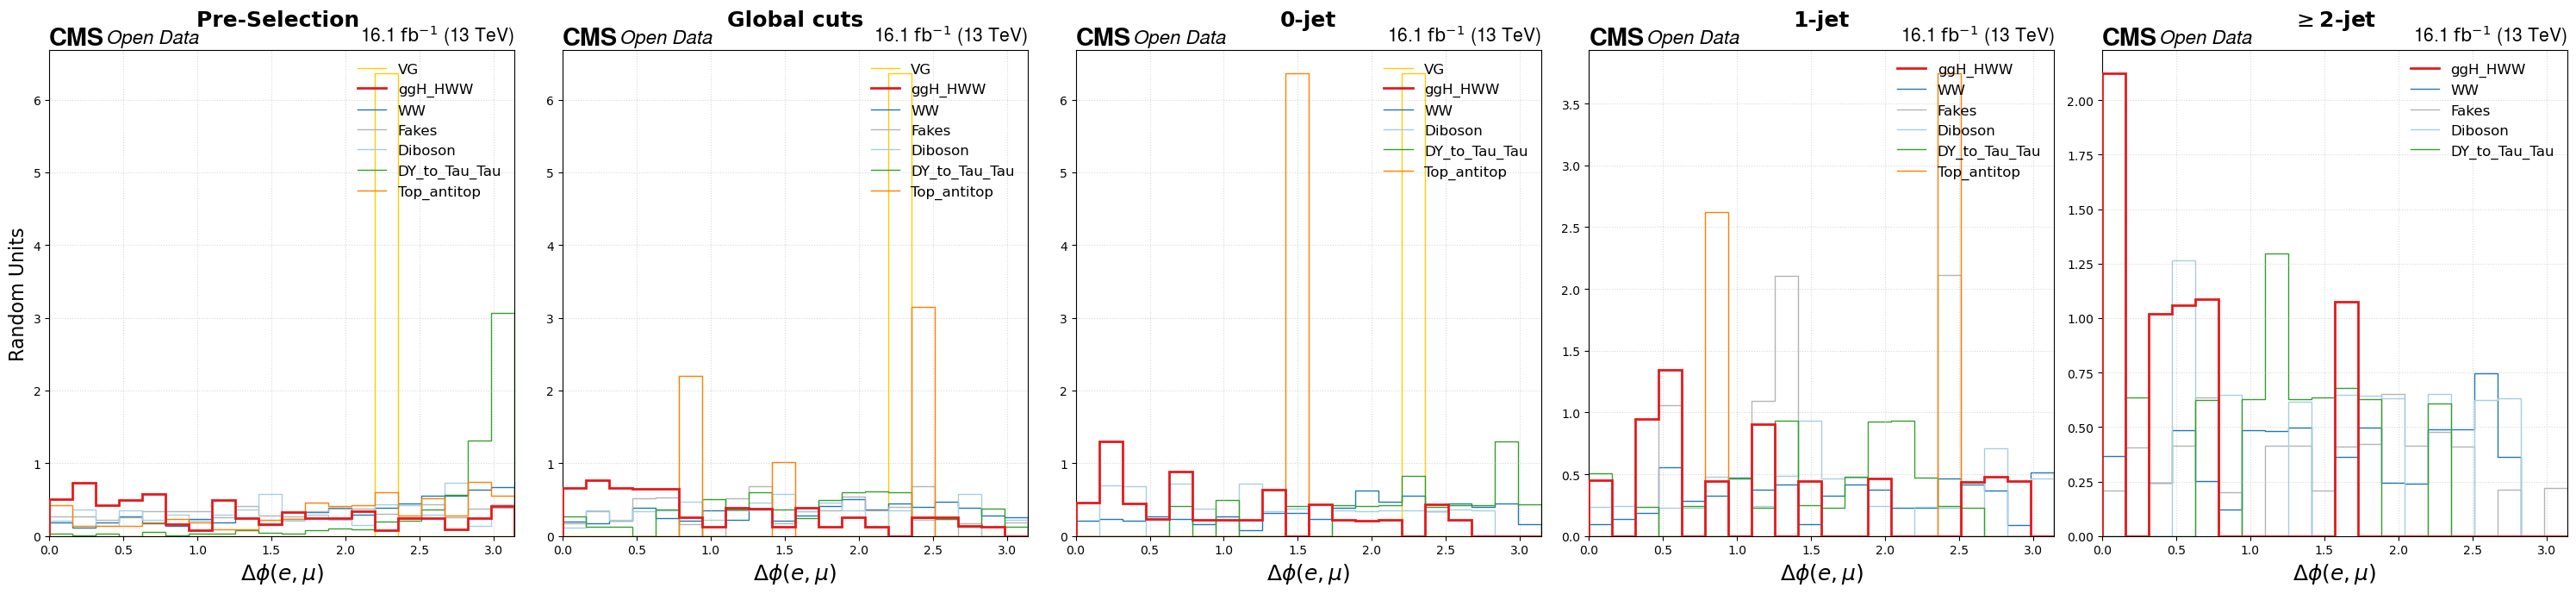

Processing ptll...
Saved plot: ptll_stages.png


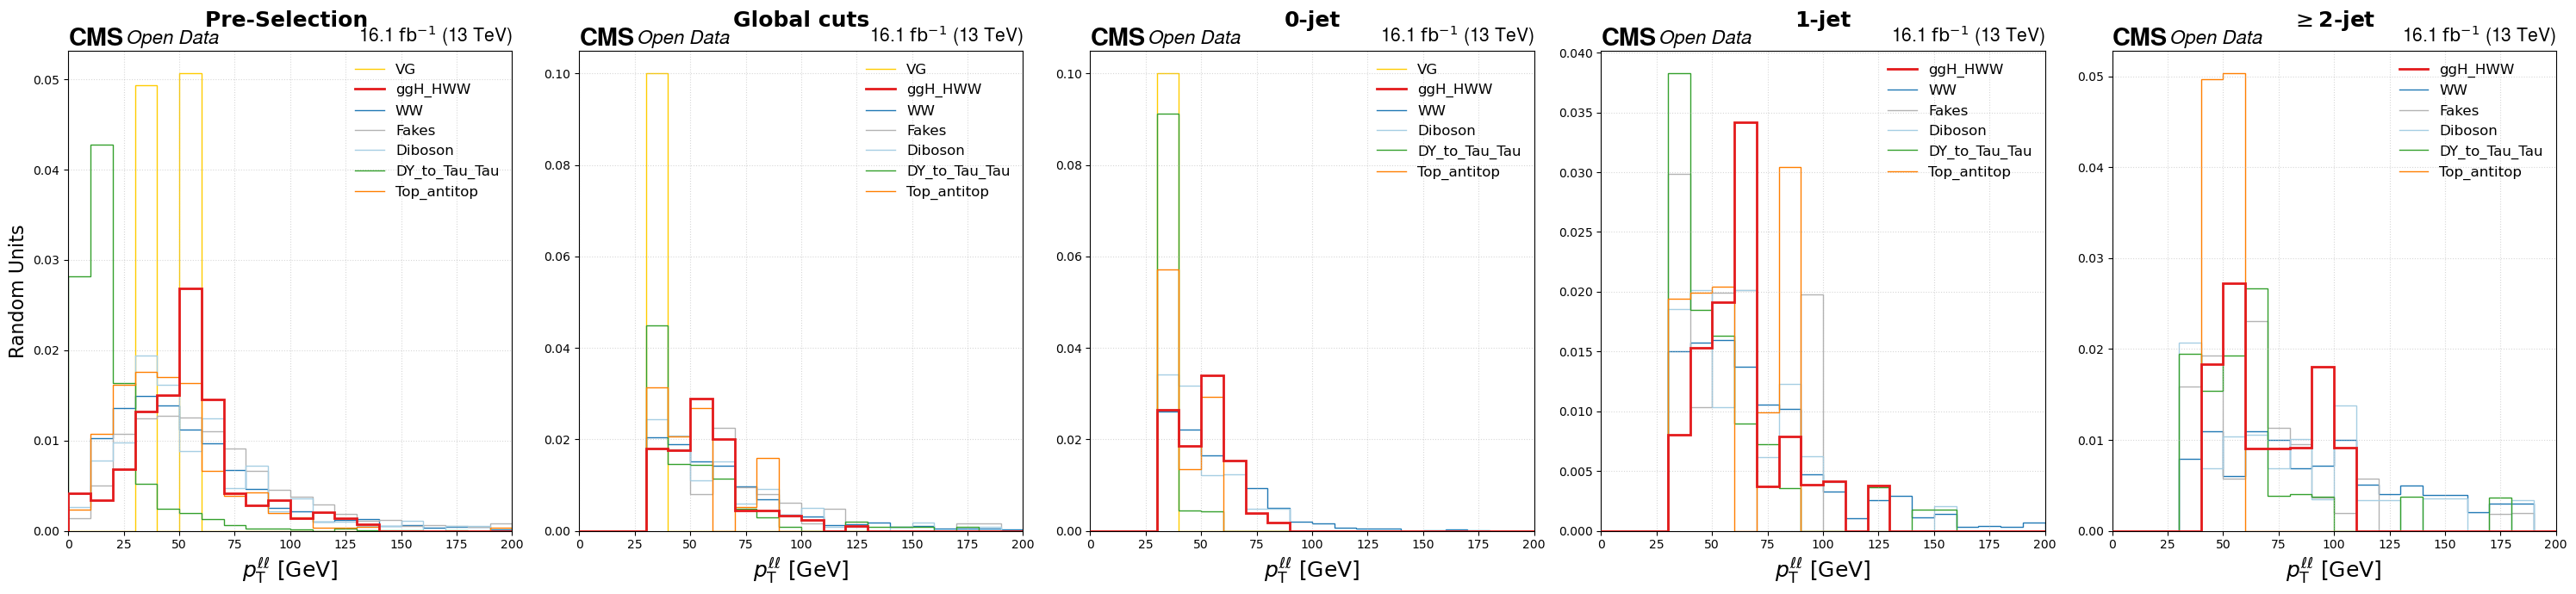

Processing mt_higgs...
Saved plot: mt_higgs_stages.png


Processing mt_l2_met...
Saved plot: mt_l2_met_stages.png


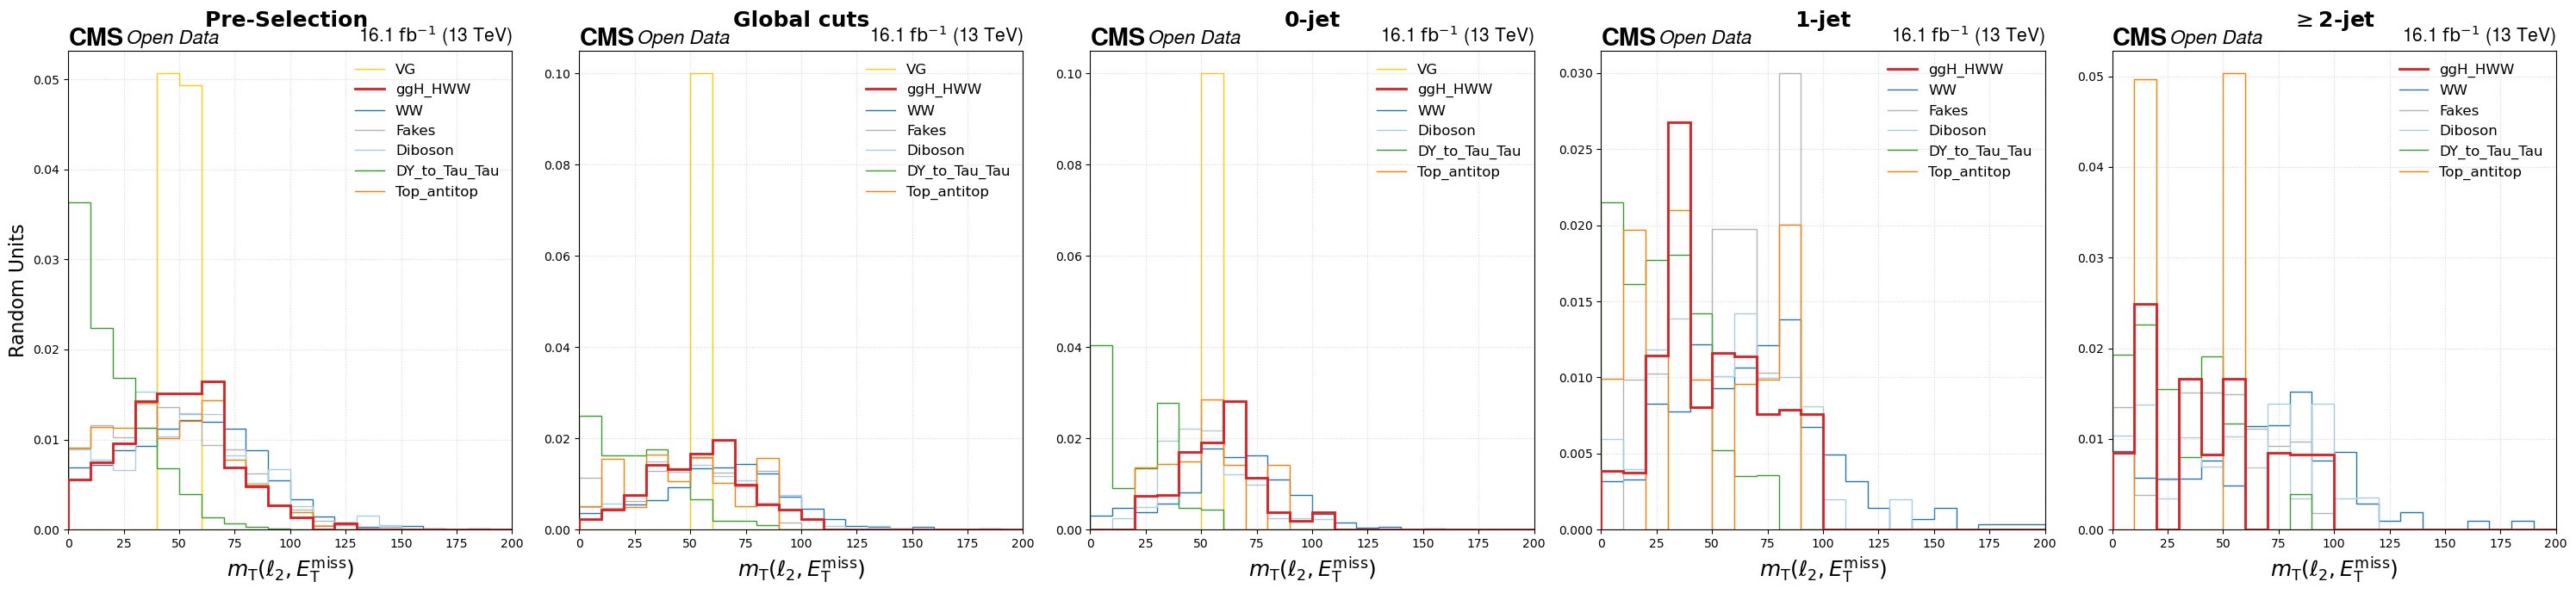

Processing mjj...
Saved plot: mjj_stages.png


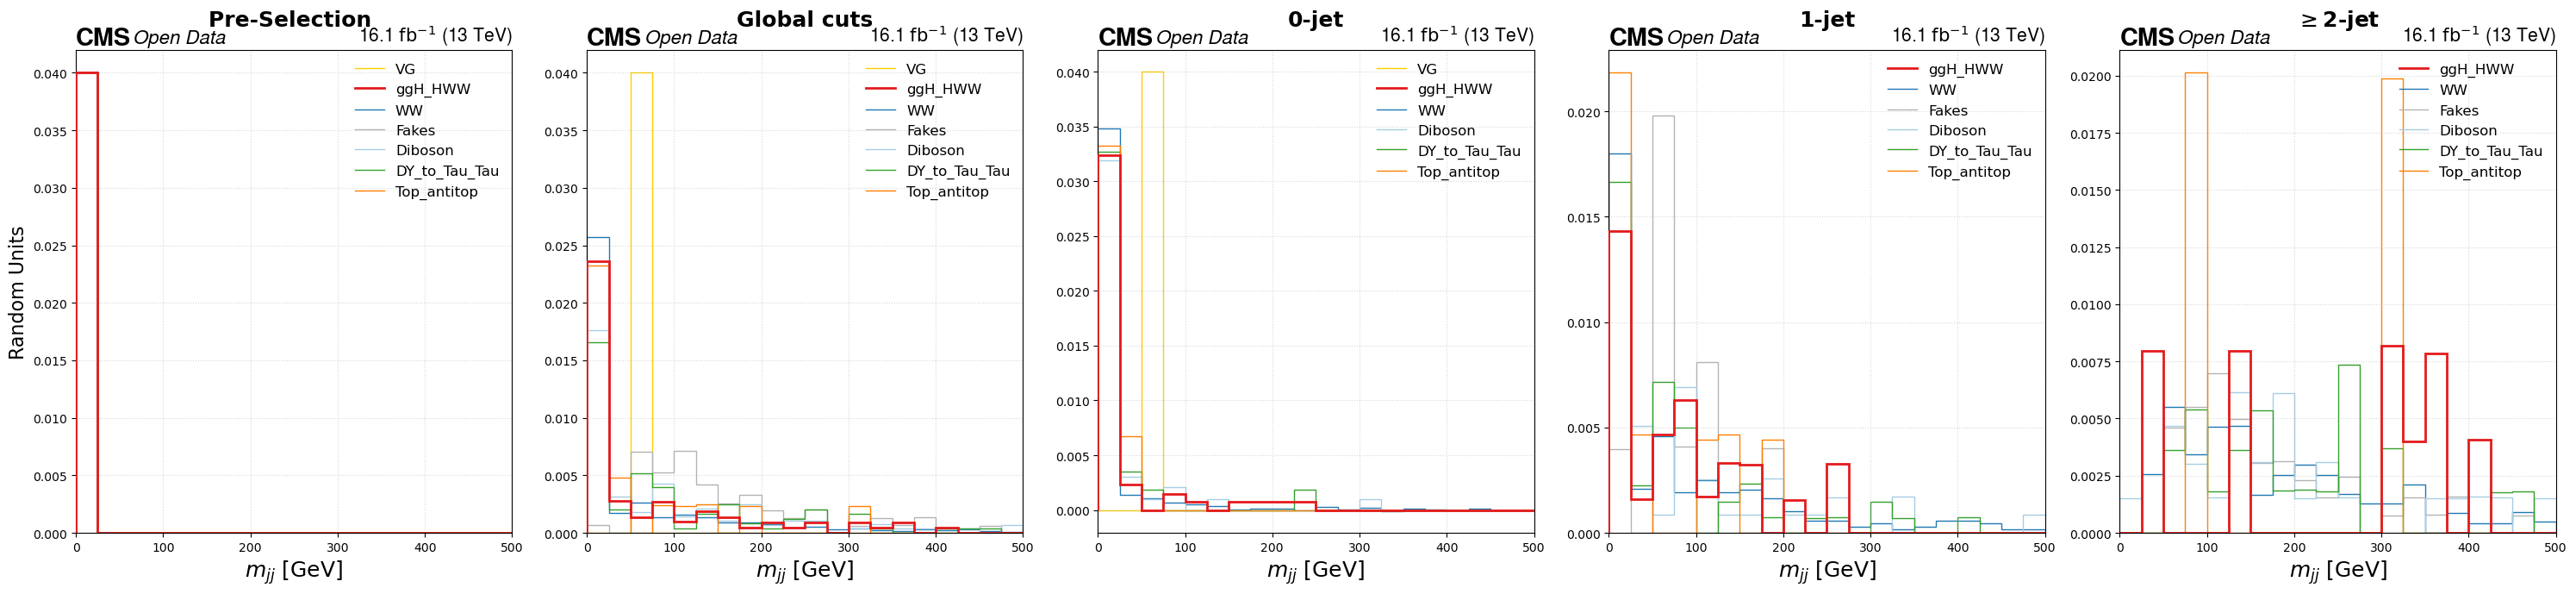

Processing leading_pt...
Saved plot: leading_pt_stages.png


Processing subleading_pt...
Saved plot: subleading_pt_stages.png


In [18]:
print(f"Saving plots to: {PLOTS_DIR / "Kinematics"}")
for var_name, var_props in variables_to_plots.items():
    print(f"Processing {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, hist_data_final, output_dir=PLOTS_DIR / "Kinematics")
    
    plt.show()
    plt.close(fig)

## Stacked plots

### Plot Settings

## Plotting

In [43]:
def stacked_plots(variable, hist_data_all, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    xlabel = VAR_LABELS.get(variable, variable)
    
    backgrounds = [s for s in SAMPLES if not SAMPLES[s]['is_signal'] and s != 'Data']
    backgrounds.sort(key=lambda s: SAMPLES[s].get("stack_order", 0))
    signal = next((s for s in SAMPLES if SAMPLES[s]['is_signal']), None)
    data_sample = 'Data'

    syst_sources = ['trigger', 'ele_id', 'mu_id'] 

    for region_name, config in PLOT_SETTINGS.items():
        var_config = config['variables'].get(variable)
        if not var_config: continue

        print(f"Plotting {variable} in {region_name}...")
        
        stages = config['stages']
        use_log = var_config.get('log', False)
        set_xlim = var_config.get('xlim', None)
        set_ylim = var_config.get('ylim', None)
        
        is_signal_region = "Signal" in region_name
        plot_data = False if is_signal_region else config.get('plot_data', True)

        # CANVAS SETUP
        if plot_data:
            fig, axes = plt.subplots(2, 3, figsize=(30, 12), 
                                     gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.08, 'wspace': 0.25},
                                     sharex='col')
            row_axes = axes[0]
            ratio_axes = axes[1]
        else:
            fig, axes = plt.subplots(1, 3, figsize=(30, 9), 
                                     gridspec_kw={'wspace': 0.25},
                                     sharex='col')
            row_axes = axes
            ratio_axes = [None] * 3

        for col_idx, (stage_key, stage_label) in enumerate(stages):
            ax_main = row_axes[col_idx]
            ax_ratio = ratio_axes[col_idx]
            
            # GET NOMINAL DATA 
            stack_vals = []
            stack_colors = []
            stack_labels = []
            stack_variances = [] 
            edges = None
            
            total_nominal = None
            syst_stacks = {source: {'up': None, 'down': None} for source in syst_sources}

            for s in backgrounds:
                vals, vars_sq, e = get_histogram_data(hist_data_all, s, stage_key, variable, 'nominal')
                
                if vals is not None:
                    if edges is None: 
                        edges = e
                        nbins = len(vals)
                        total_nominal = np.zeros(nbins)
                        for src in syst_sources:
                            syst_stacks[src]['up'] = np.zeros(nbins)
                            syst_stacks[src]['down'] = np.zeros(nbins)

                    stack_vals.append(vals)
                    stack_variances.append(vars_sq) # Add stat variance
                    stack_colors.append(SAMPLES[s].get("color", "gray"))
                    stack_labels.append(s)
                    
                    # Add to totals
                    total_nominal += vals
                    
                    # Accumulate Systematics for this background
                    for src in syst_sources:
                        v_up, _, _ = get_histogram_data(hist_data_all, s, stage_key, variable, f'{src}_up')
                        v_dn, _, _ = get_histogram_data(hist_data_all, s, stage_key, variable, f'{src}_down')
                        
                        if v_up is None: v_up = vals
                        if v_dn is None: v_dn = vals
                            
                        syst_stacks[src]['up'] += v_up
                        syst_stacks[src]['down'] += v_dn

            if edges is None:
                ax_main.text(0.5, 0.5, "No Data", ha='center', transform=ax_main.transAxes)
                continue
                
            # Stats Uncertainty
            total_stat_variance = np.sum(stack_variances, axis=0)
            
            # Systematic Uncertainty
            total_syst_variance = np.zeros_like(total_nominal)
            
            for src in syst_sources:
                diff_up = np.abs(syst_stacks[src]['up'] - total_nominal)
                diff_dn = np.abs(syst_stacks[src]['down'] - total_nominal)
                
                max_diff = np.maximum(diff_up, diff_dn)
                total_syst_variance += max_diff**2
                
            # Total Error (Stat + Syst)
            total_err = np.sqrt(total_stat_variance + total_syst_variance)

            # PLOTTING      
            
            # A. Stack
            if stack_vals:
                hep.histplot(stack_vals, bins=edges, stack=True, histtype='fill',
                             color=stack_colors, label=stack_labels, ax=ax_main)
                
                # Outline
                hep.histplot(total_nominal, bins=edges, histtype='step', color='black', linewidth=1, ax=ax_main)
                
                # DRAW UNCERTAINTY BAND
                band_low = np.append(total_nominal - total_err, (total_nominal - total_err)[-1])
                band_high = np.append(total_nominal + total_err, (total_nominal + total_err)[-1])
                
                ax_main.fill_between(edges, band_low, band_high, step='post', 
                                     facecolor='none', edgecolor='gray', 
                                     label='Stat+Syst Unc.', hatch='////', zorder=2)

            # B. Signal
            if signal:
                sig_vals, _, _ = get_histogram_data(hist_data_all, signal, stage_key, variable, 'nominal')
                if sig_vals is not None:
                    sig_scale = 10 if is_signal_region else 1
                    sig_lbl = f"{signal} (x{sig_scale})" if sig_scale > 1 else signal
                    hep.histplot(sig_vals * sig_scale, bins=edges, histtype='step',
                                 color=SAMPLES[signal].get("color", "red"), 
                                 linewidth=3, label=sig_lbl, ax=ax_main)

            # C. Data
            data_vals = None
            if plot_data:
                data_vals, _, _ = get_histogram_data(hist_data_all, data_sample, stage_key, variable, 'nominal')
                if data_vals is not None:
                    yerr = np.sqrt(data_vals); yerr[data_vals == 0] = 0
                    hep.histplot(data_vals, bins=edges, histtype='errorbar', color='black', 
                                 label='Data', yerr=yerr, marker='o', markersize=5, ax=ax_main, zorder=10)

            # D. Ratio Plot
            if plot_data and data_vals is not None and total_nominal is not None:
                safe_denom = np.where(total_nominal == 0, 1e-9, total_nominal)
                ratio = data_vals / safe_denom
                ratio_stat_err = np.abs(np.sqrt(data_vals) / safe_denom) 
                
                # Points
                hep.histplot(ratio, bins=edges, histtype='errorbar', yerr=ratio_stat_err,
                             color='black', marker='o', markersize=4, ax=ax_ratio)
                
                rel_err = total_err / safe_denom
                rel_err[total_nominal == 0] = 0 
                
                ratio_band_low = np.append(1.0 - rel_err, (1.0 - rel_err)[-1])
                ratio_band_high = np.append(1.0 + rel_err, (1.0 + rel_err)[-1])
                
                ax_ratio.fill_between(edges, ratio_band_low, ratio_band_high, step='post',
                                      facecolor='gray', alpha=0.3, zorder=1) # Solid gray or hatched
                
                ax_ratio.axhline(1, color='gray', linestyle='--')
                ax_ratio.set_ylim(0.5, 1.5)
                ax_ratio.set_ylabel("Data / Pred.", fontsize=16)
                ax_ratio.set_xlabel(xlabel, fontsize=20)
                ax_ratio.grid(True, linestyle=':', alpha=0.5)

            #       STYLING      
            hep.cms.label(ax=ax_main, loc=0, data=True, label="Open Data", lumi=16.1, fontsize=20)
            ax_main.text(0.05, 0.92, stage_label, transform=ax_main.transAxes, fontsize=22, fontweight='bold', va='top')
            ax_main.set_ylabel("Events / Bin", fontsize=20)
            
            if use_log:
                ax_main.set_yscale('log')
                max_val = np.max(total_nominal) if total_nominal is not None else 1
                ax_main.set_ylim(0.1, max_val * 500)
            else:
                max_val = np.max(total_nominal) if total_nominal is not None else 1
                ax_main.set_ylim(0, max_val * 1.5)

            if set_xlim: ax_main.set_xlim(set_xlim)
            if set_ylim and not use_log: ax_main.set_ylim(set_ylim)
            if not plot_data: ax_main.set_xlabel(xlabel, fontsize=20)

            # Legend
            handles, labels = ax_main.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax_main.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=1, frameon=False, fontsize=16)

        # SAVE
        fname = f"{output_dir}/CMS_{region_name}_{variable}.png"
        plt.savefig(fname, bbox_inches='tight', dpi=150)
        print(f"Saved: {fname}")
        plt.show()
        plt.close(fig)


GENERATING PLOTS WITH SYSTEMATIC BANDS...
Plotting mass in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mass.png


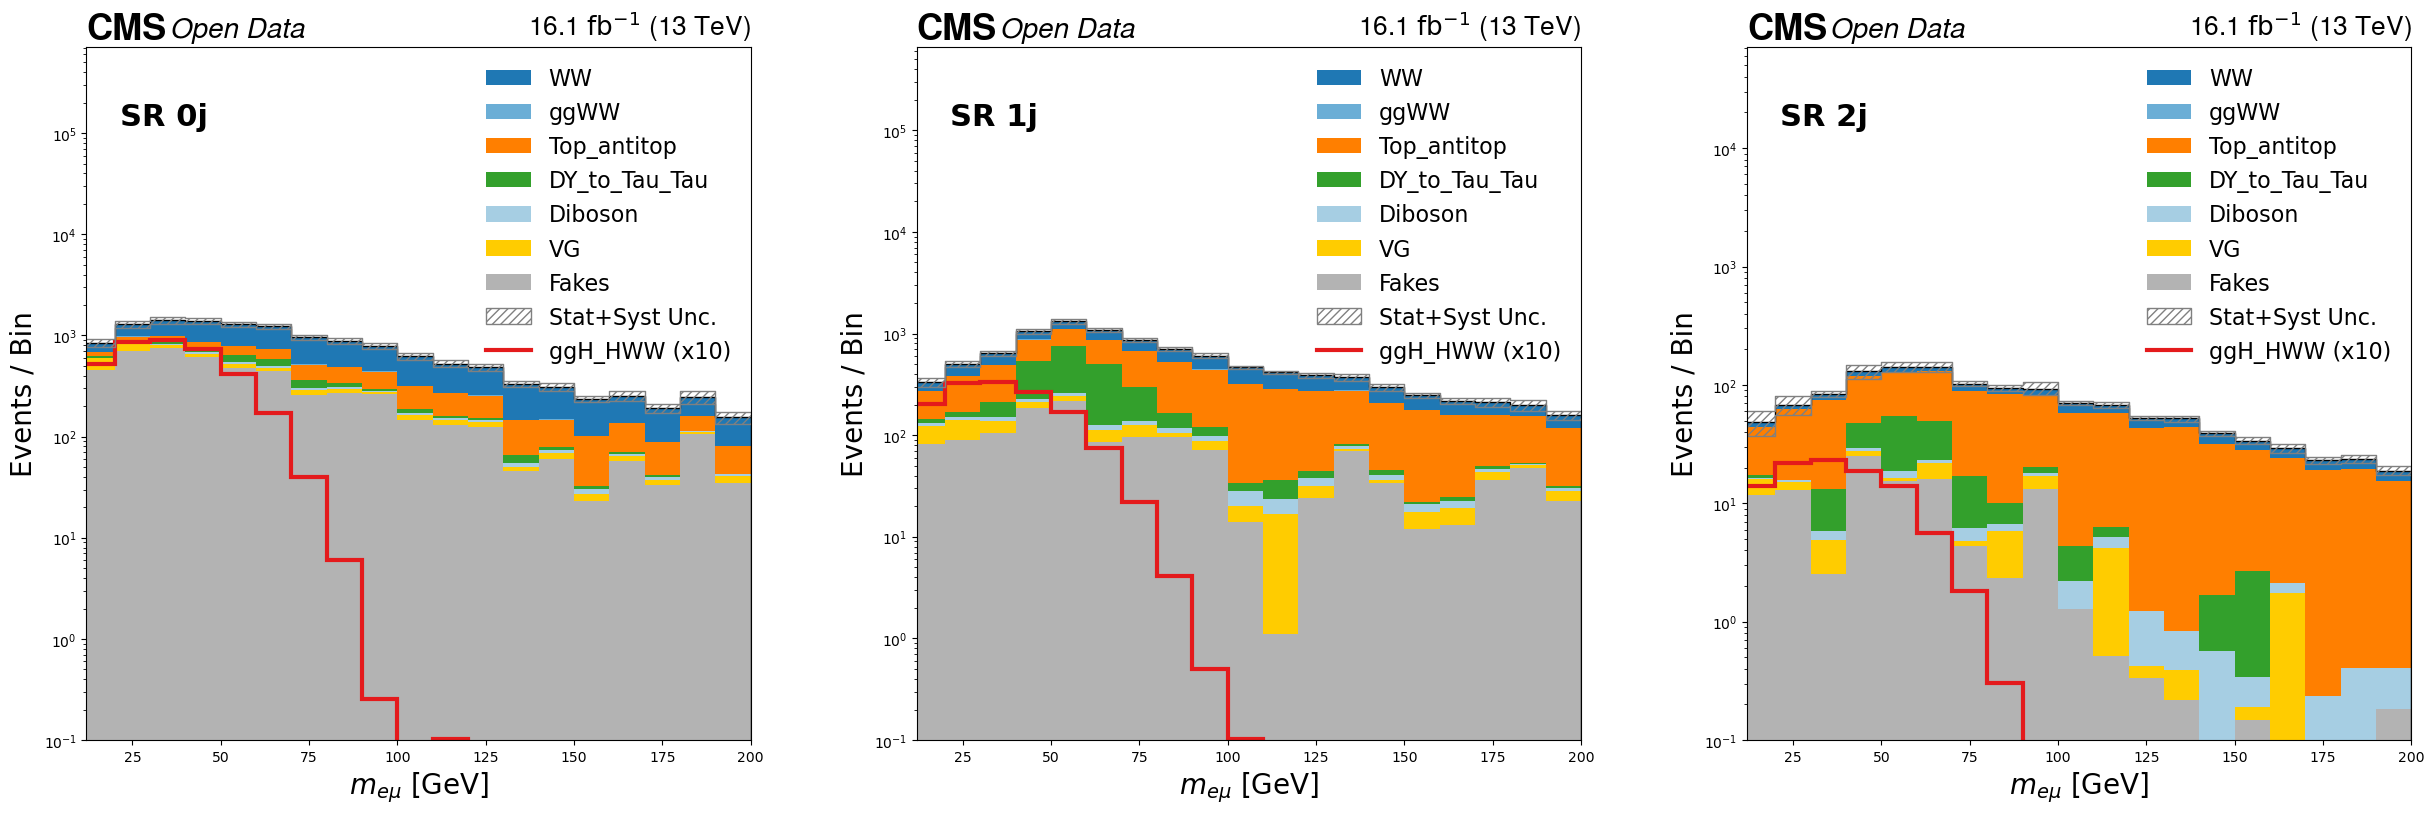

Plotting mass in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mass.png


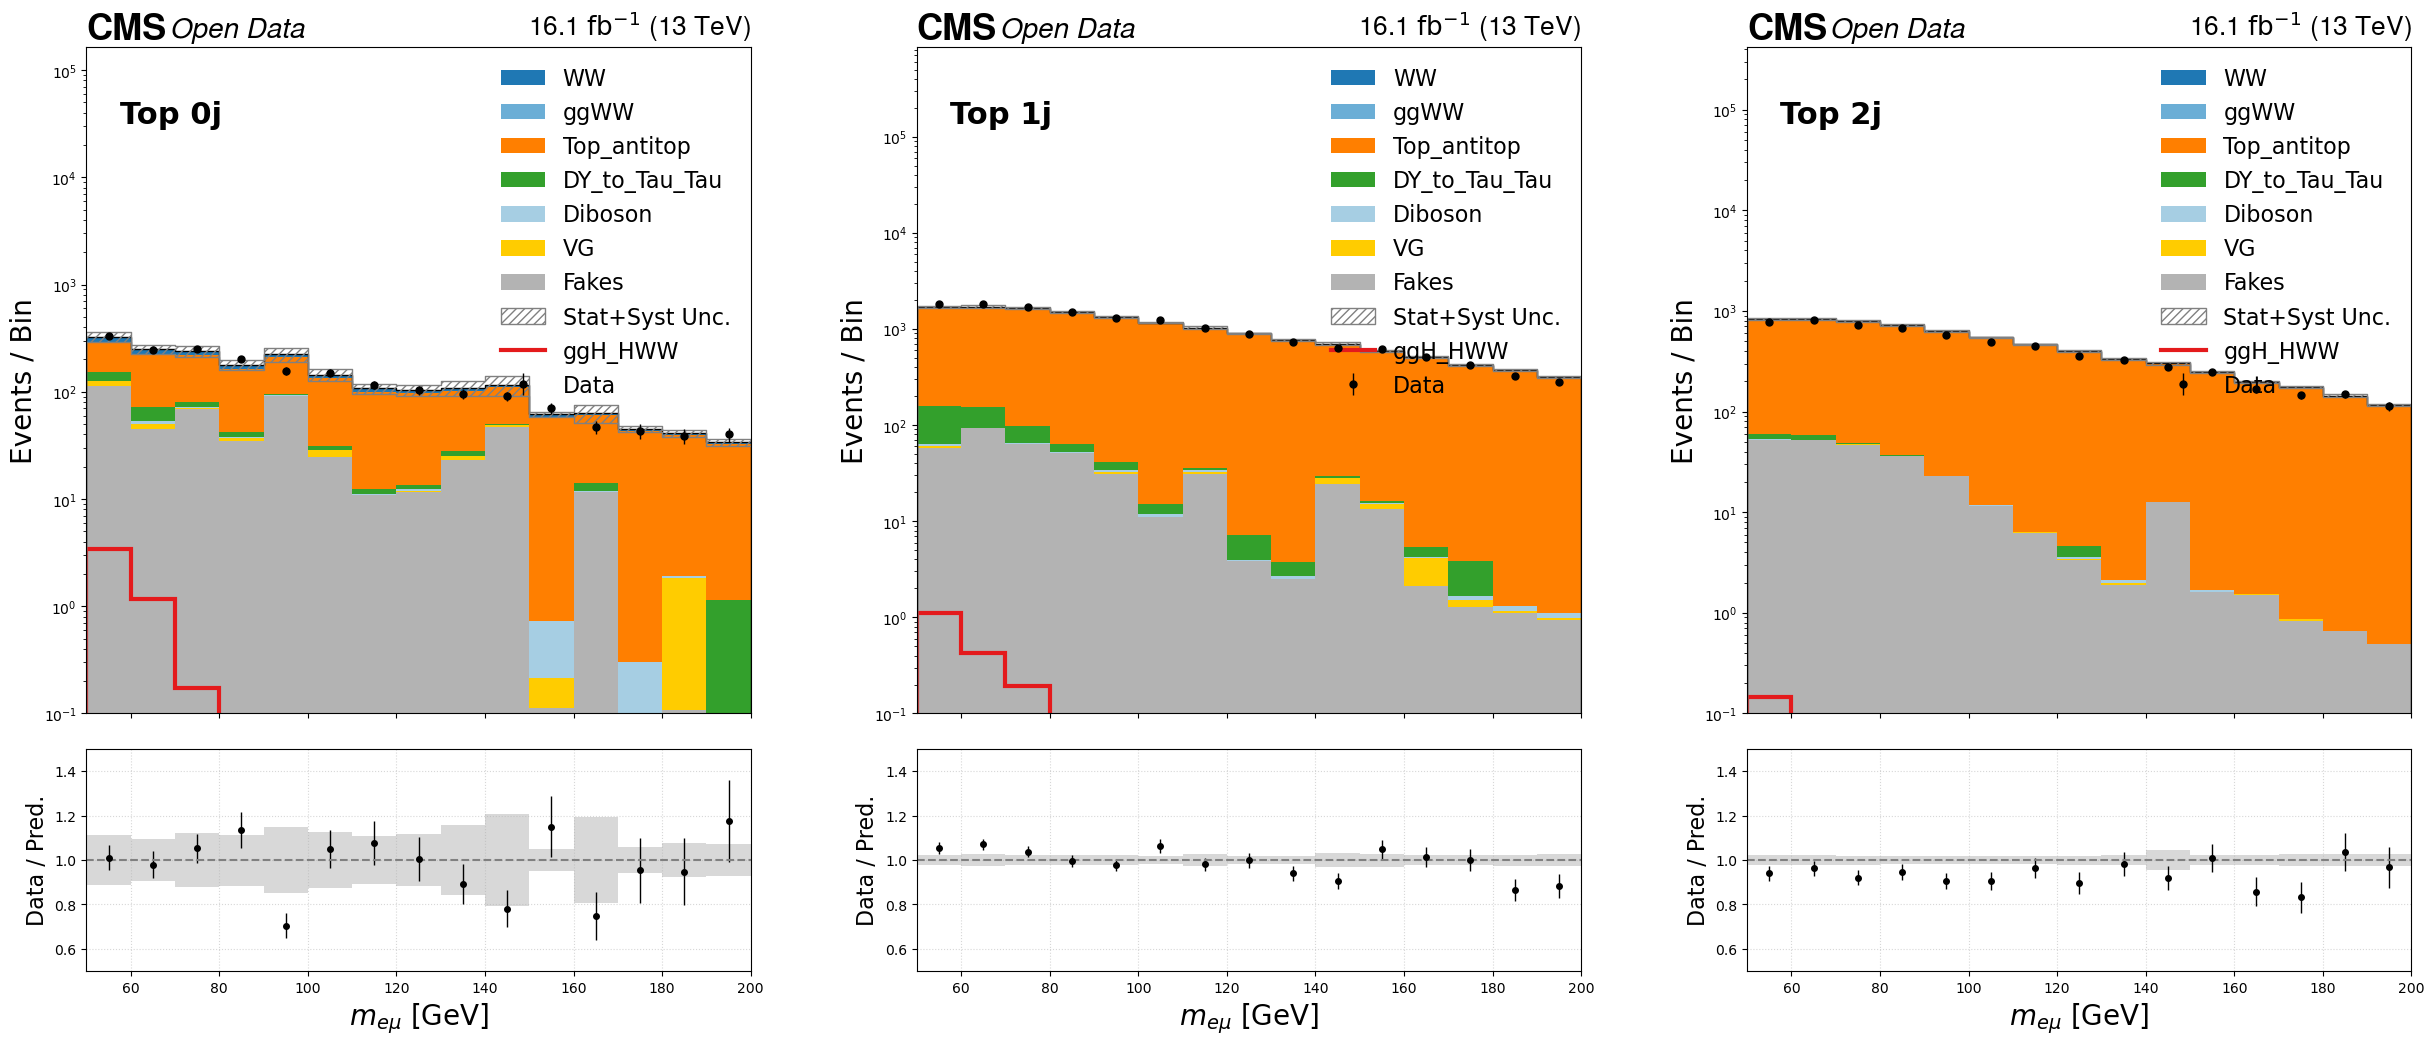

Plotting mass in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mass.png


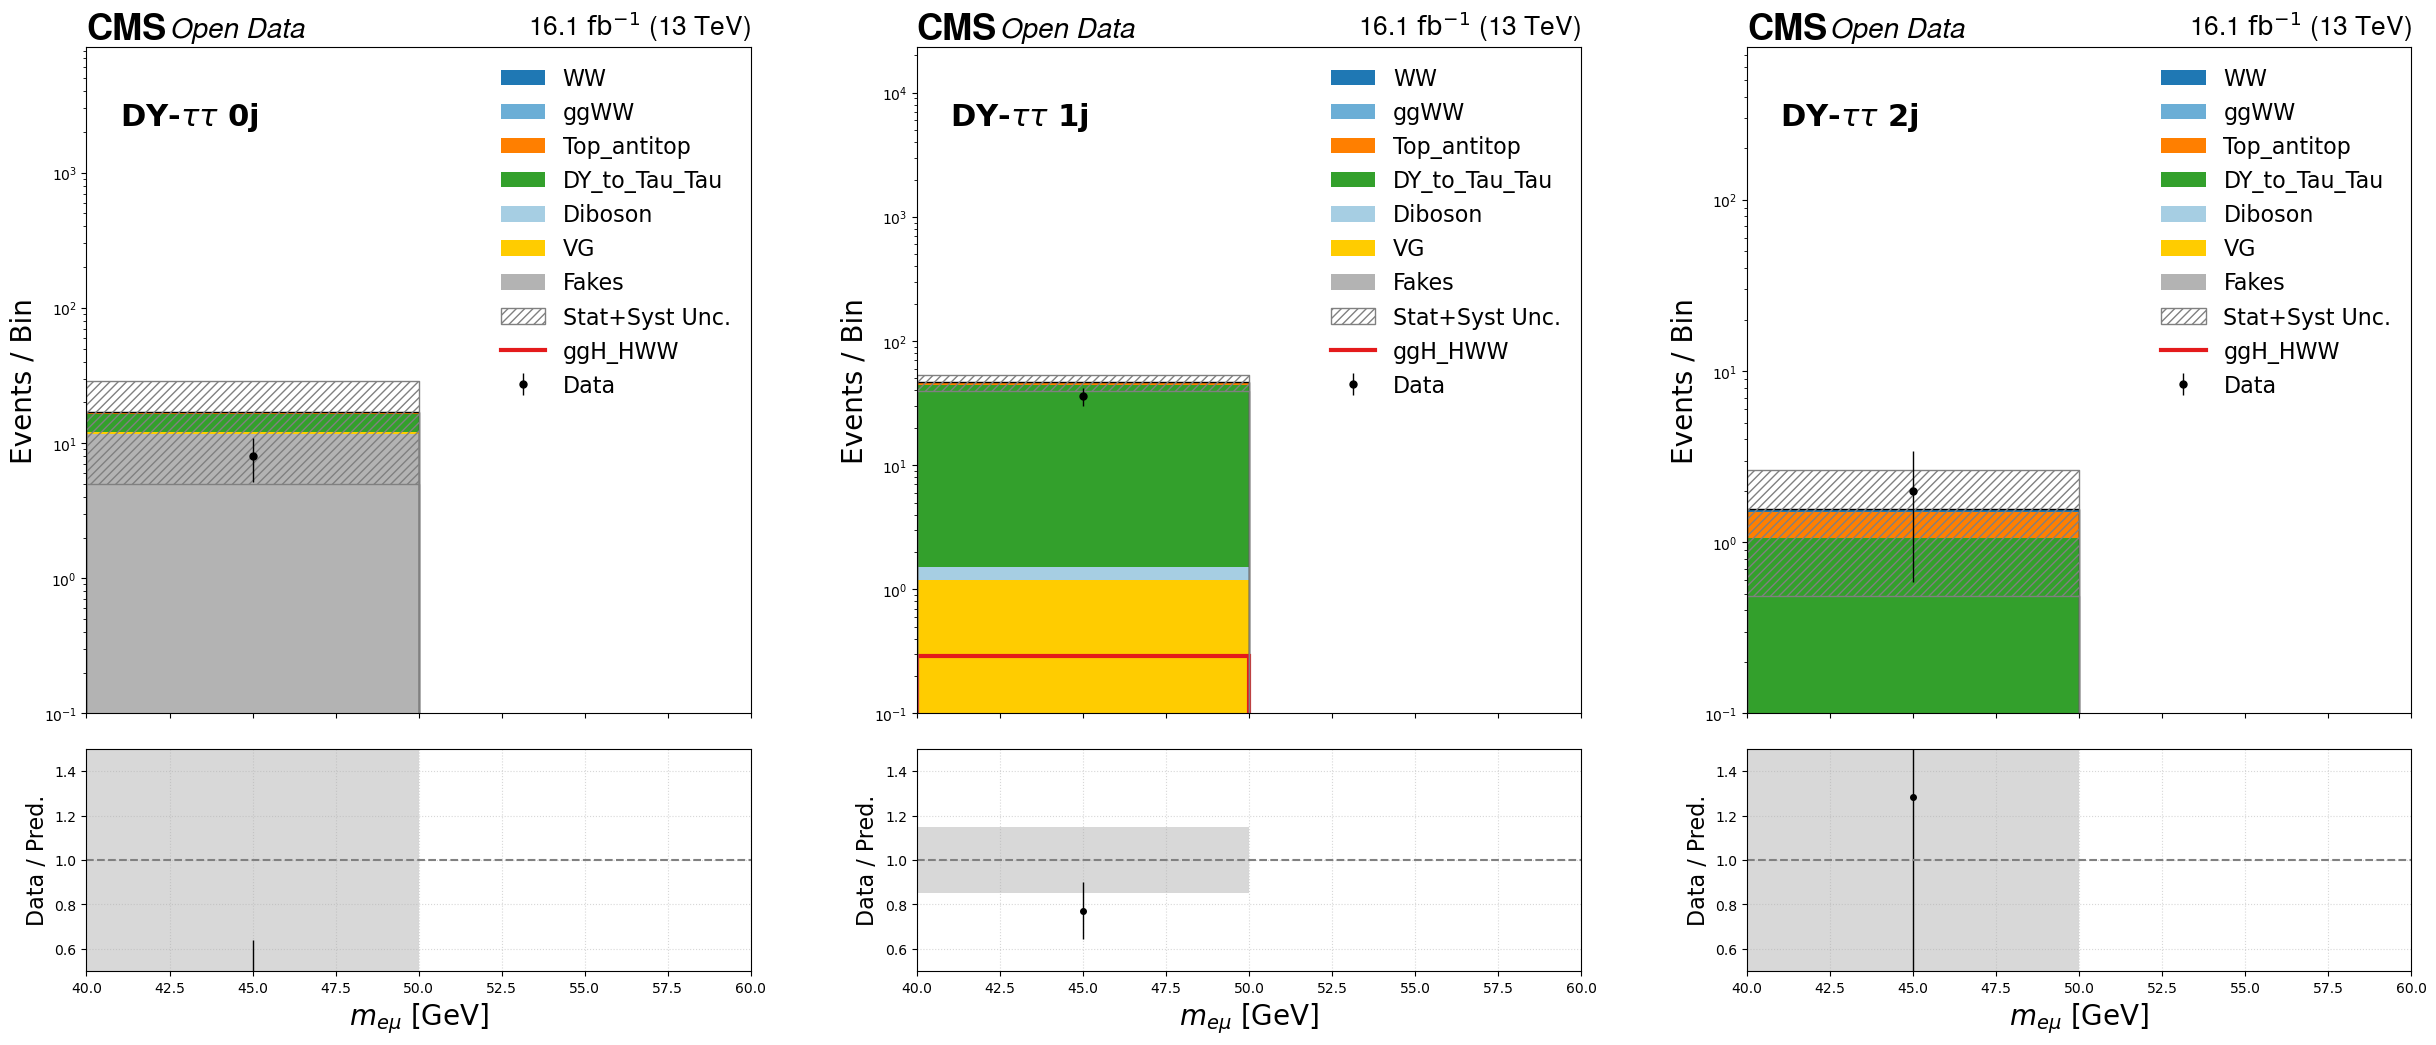

Plotting met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_met.png


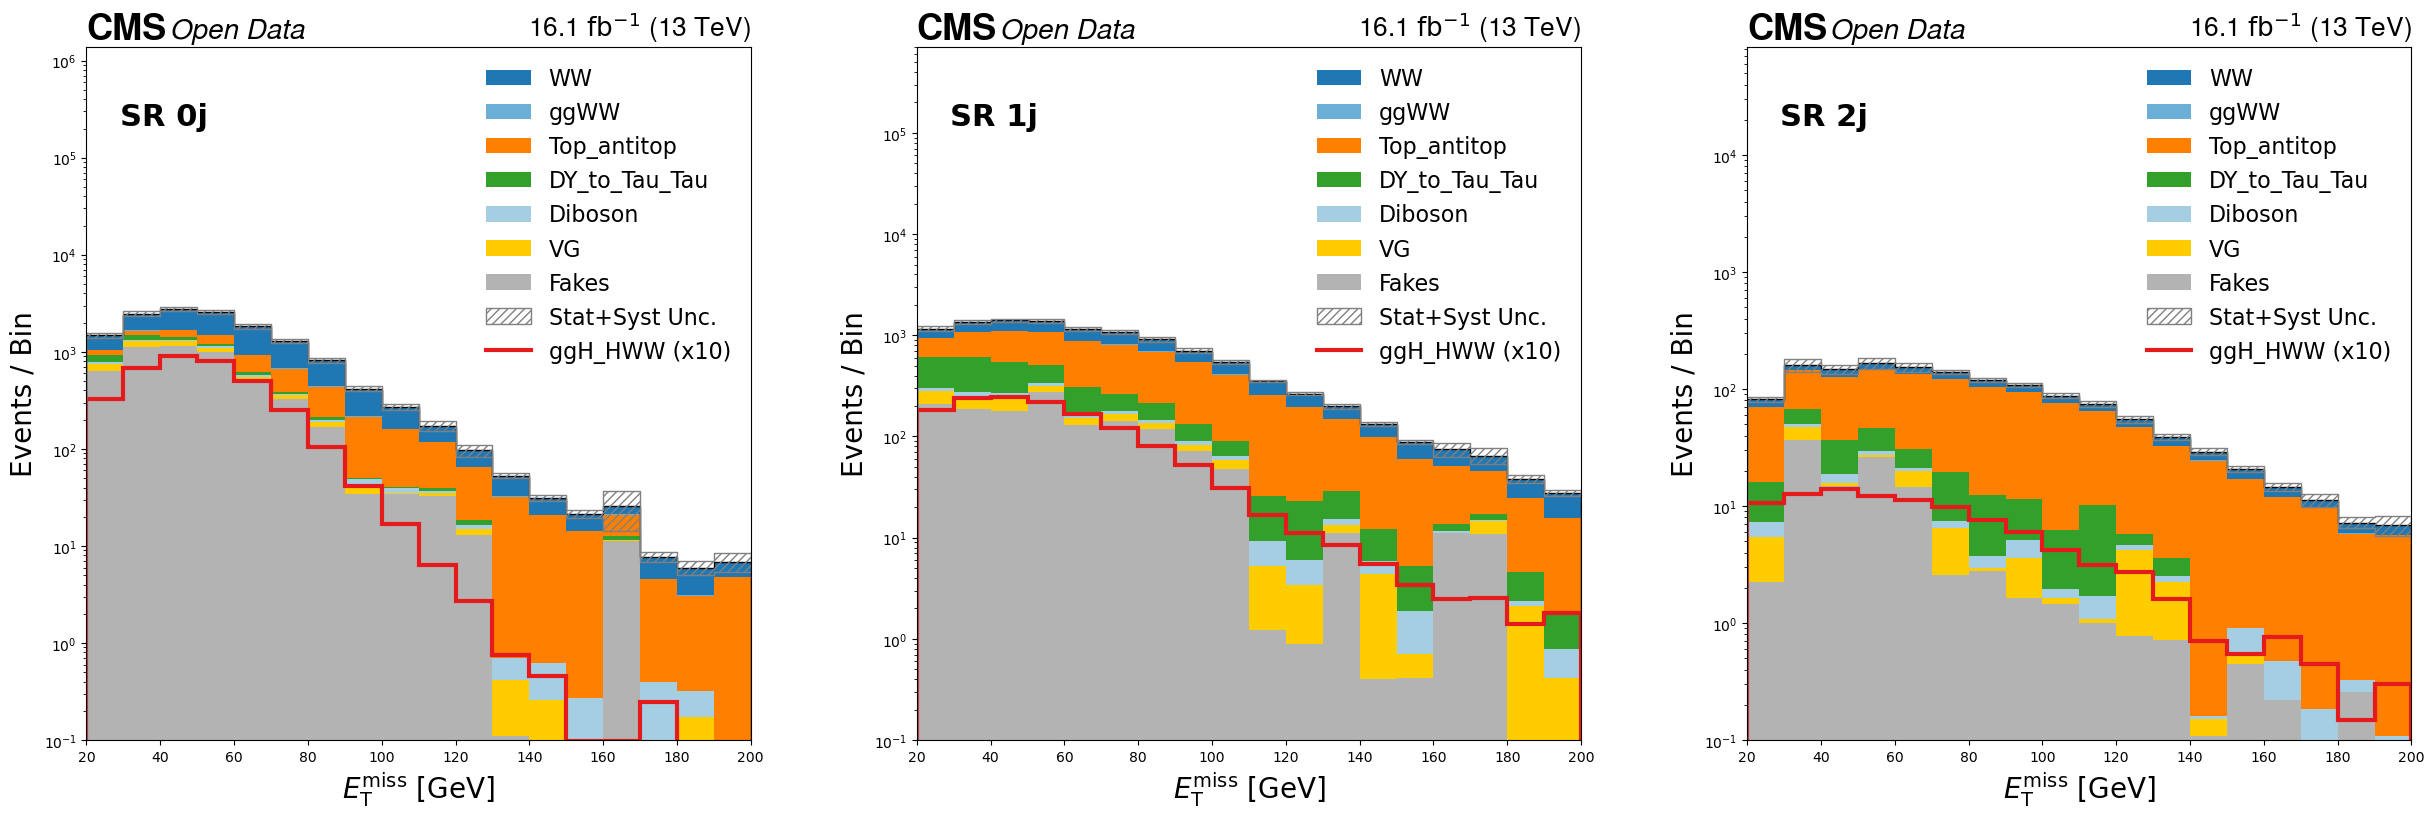

Plotting met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_met.png


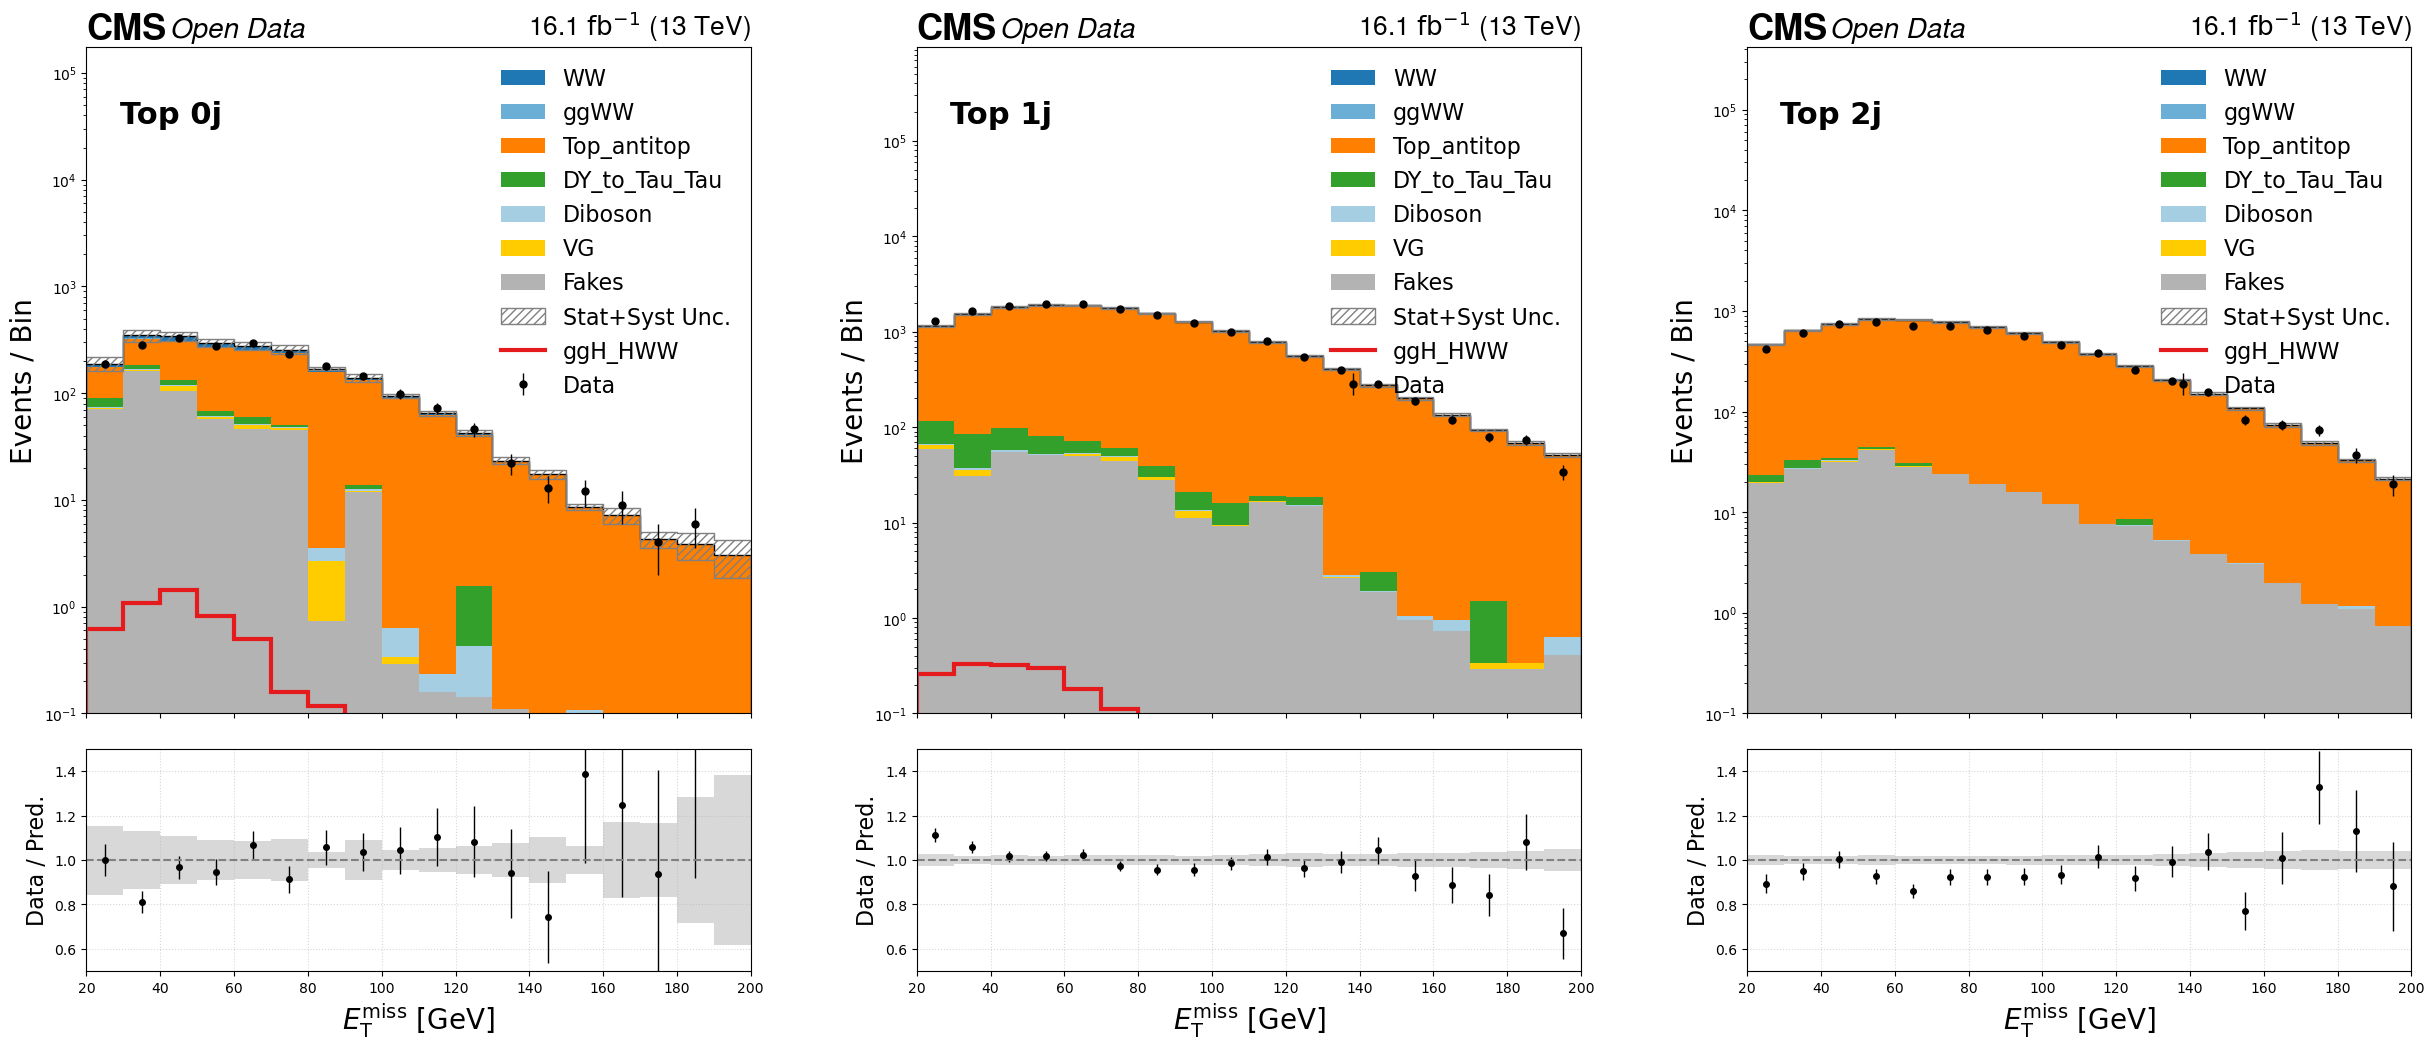

Plotting met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_met.png


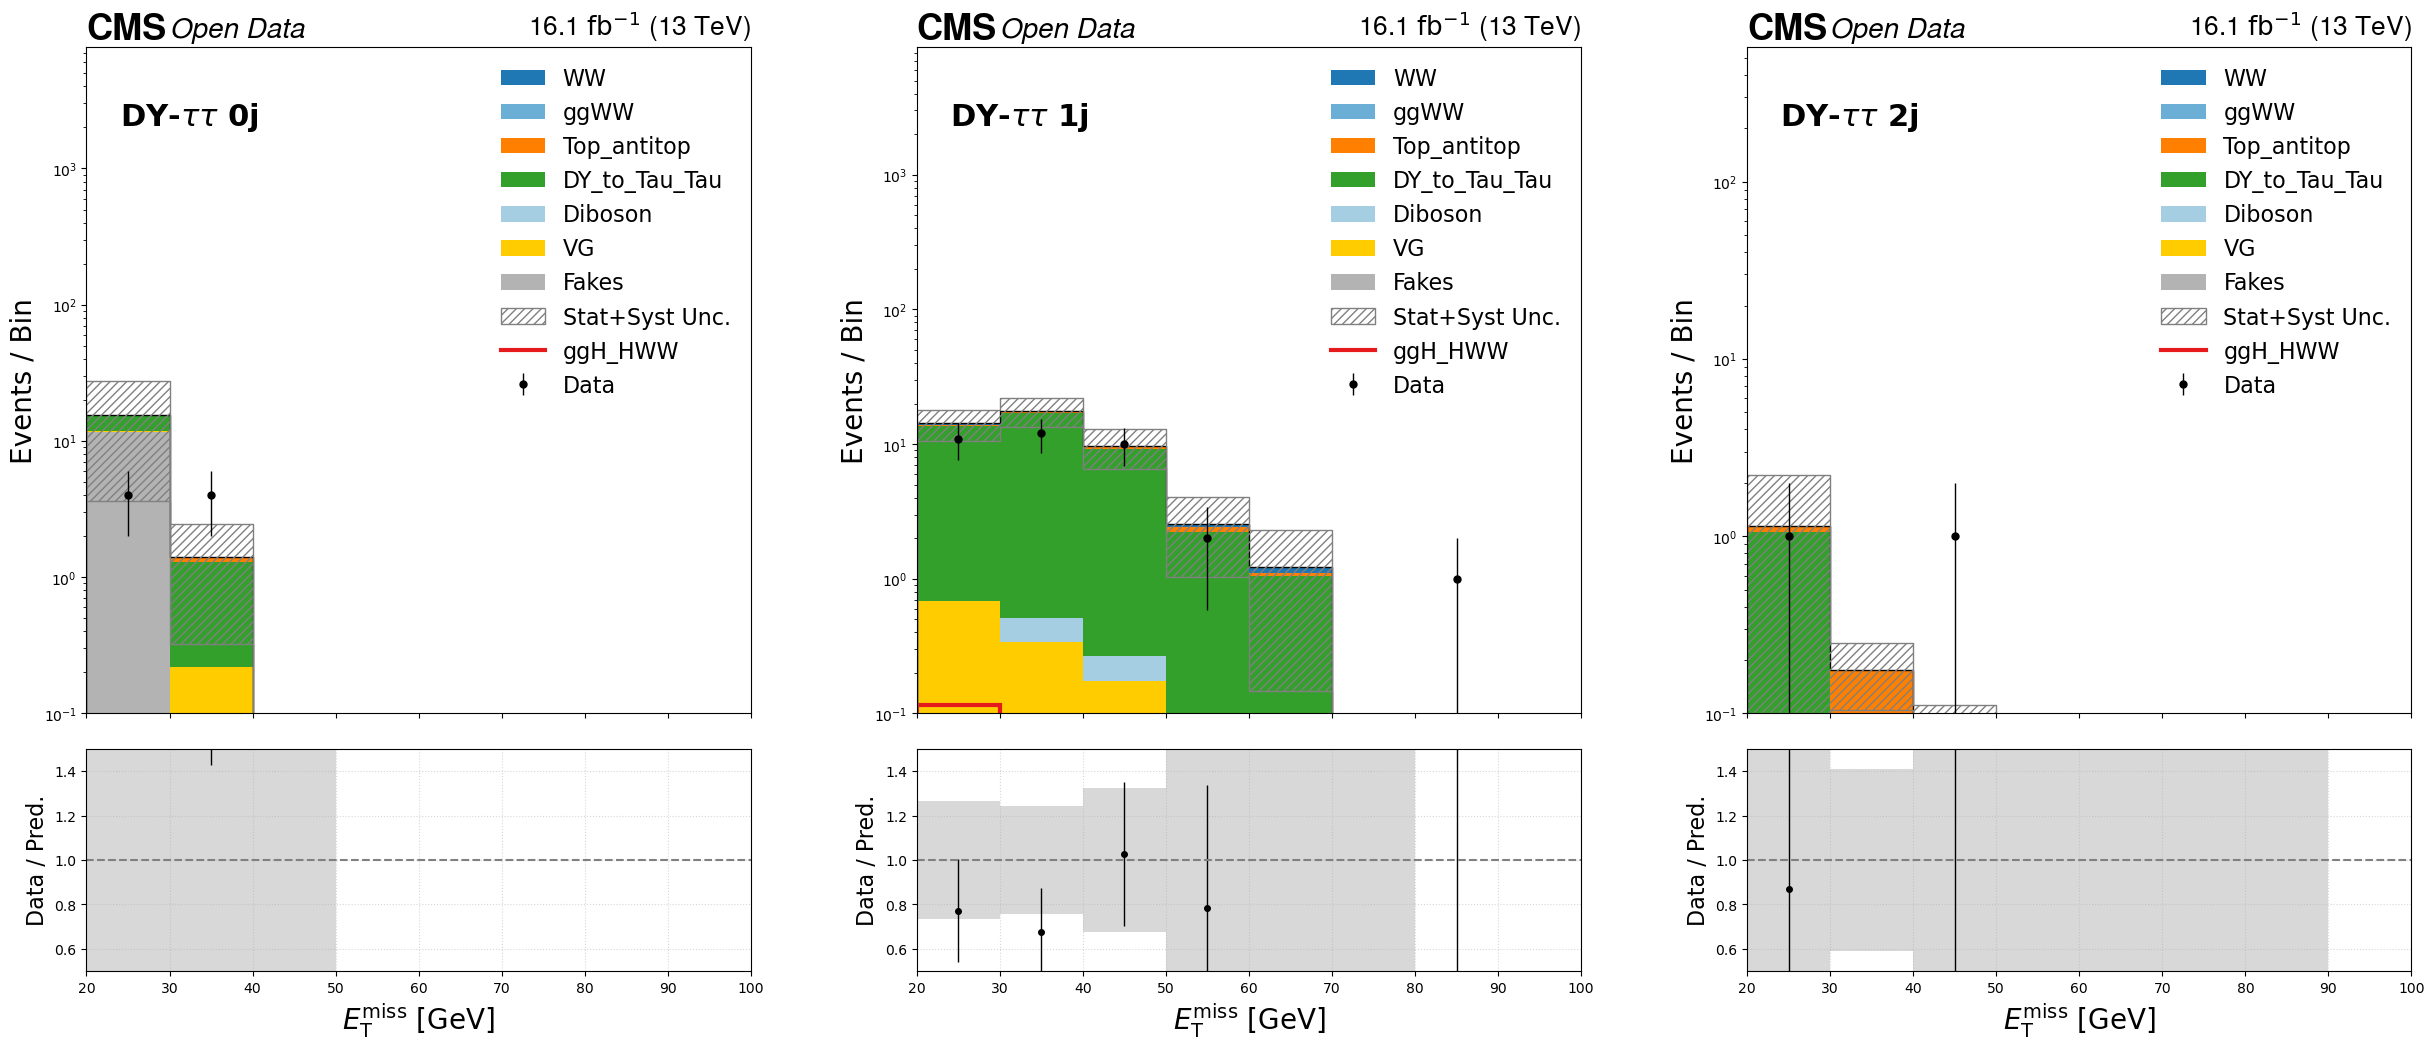

Plotting ptll in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_ptll.png


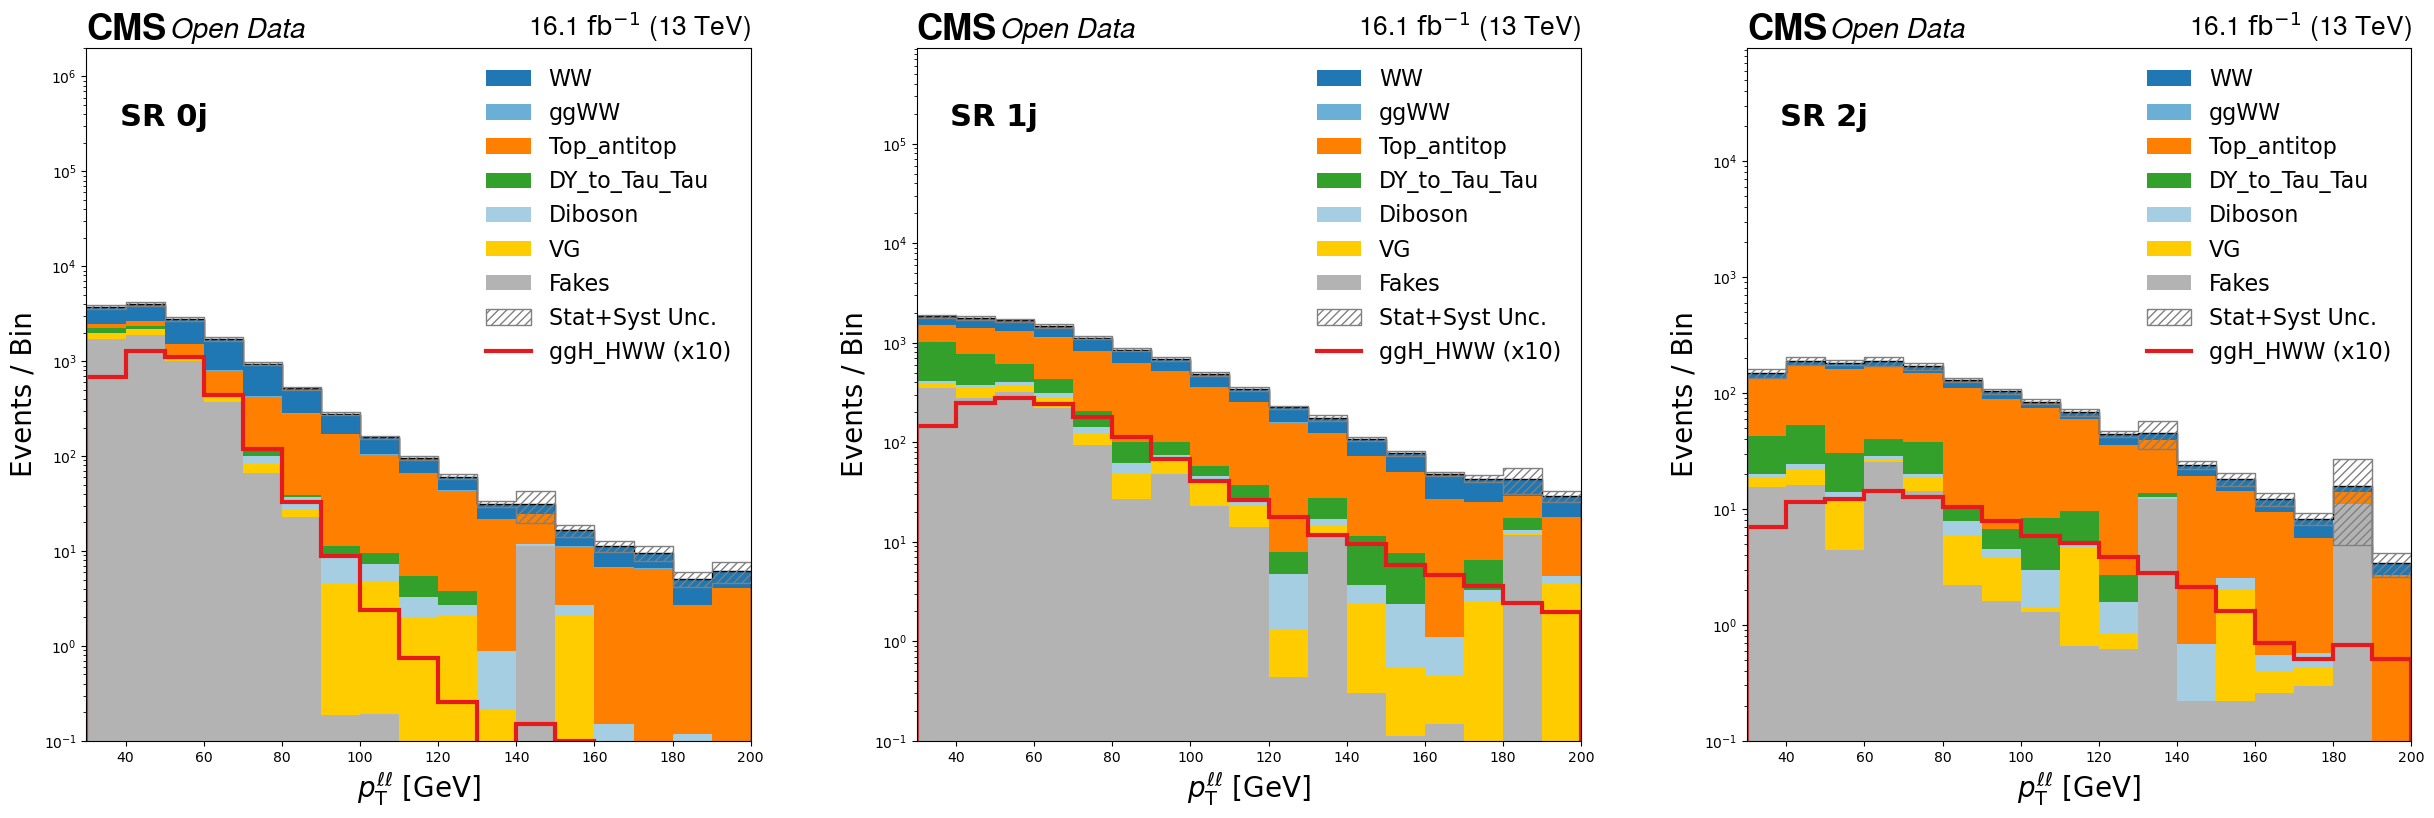

Plotting ptll in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_ptll.png


Plotting ptll in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_ptll.png


Plotting dphi in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_dphi.png


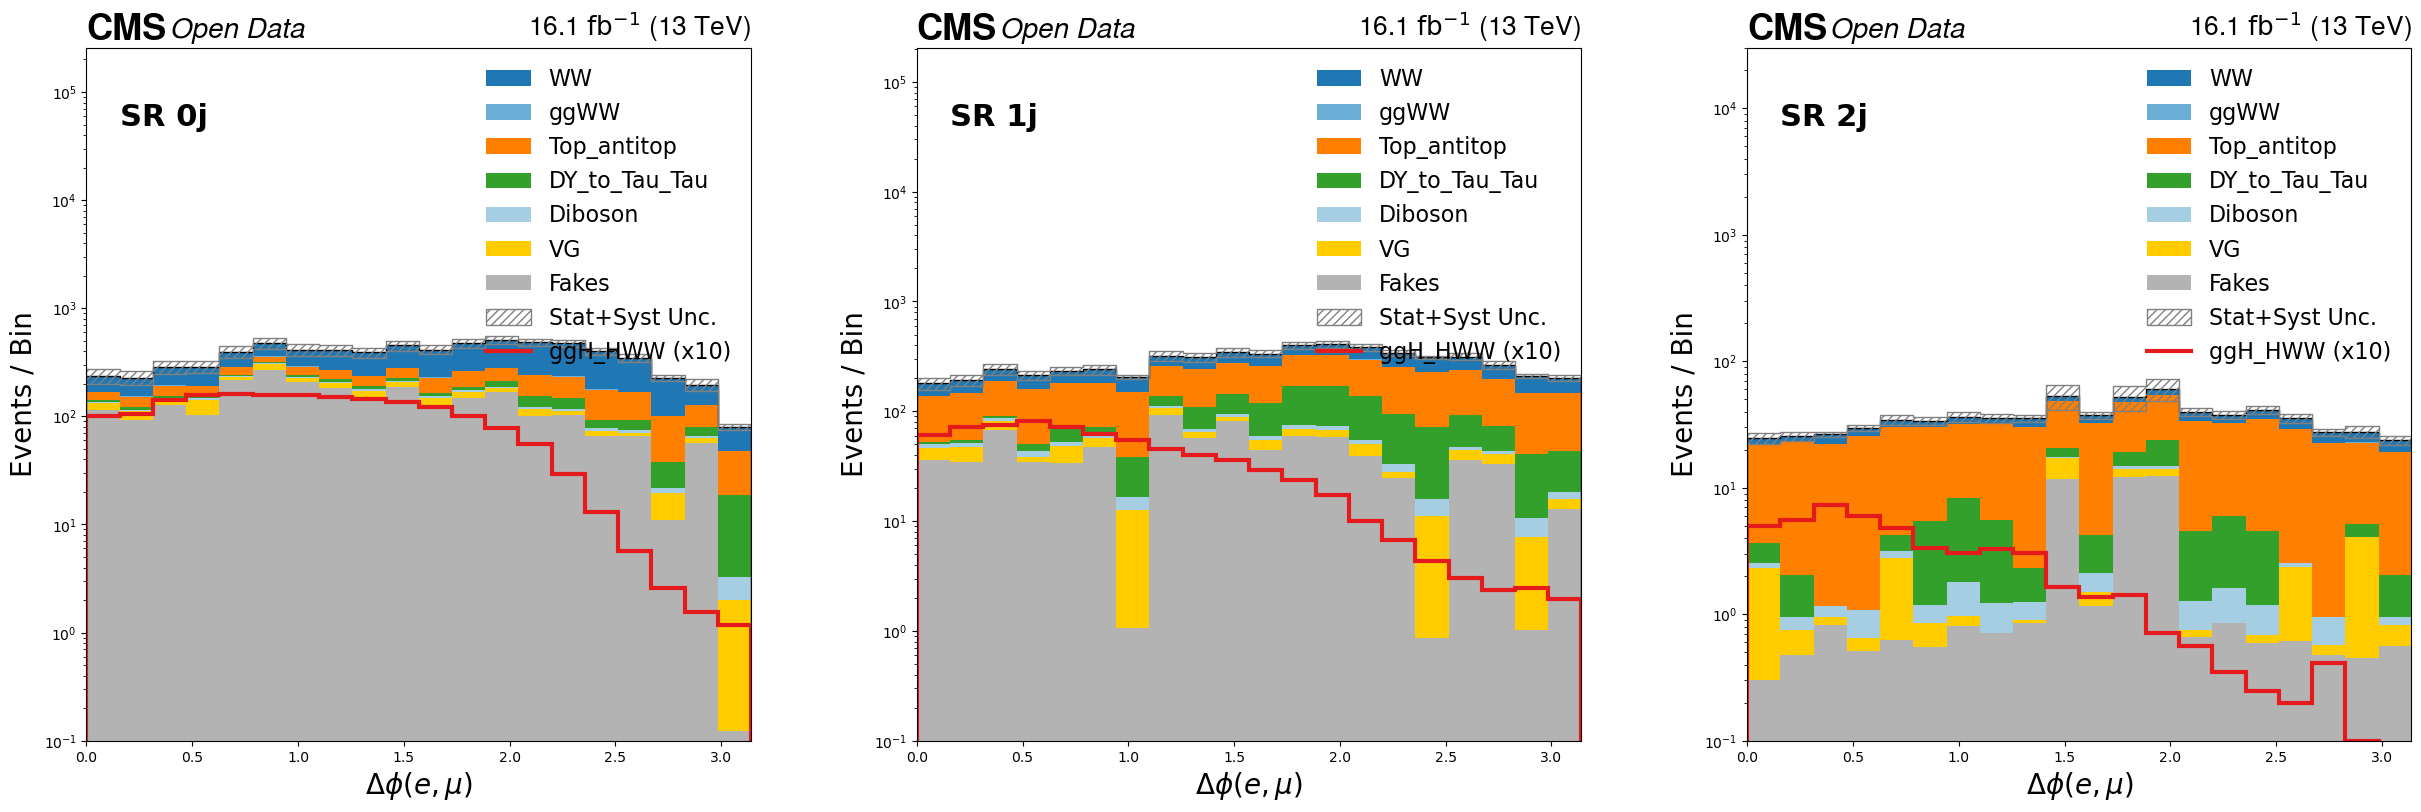

Plotting dphi in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_dphi.png


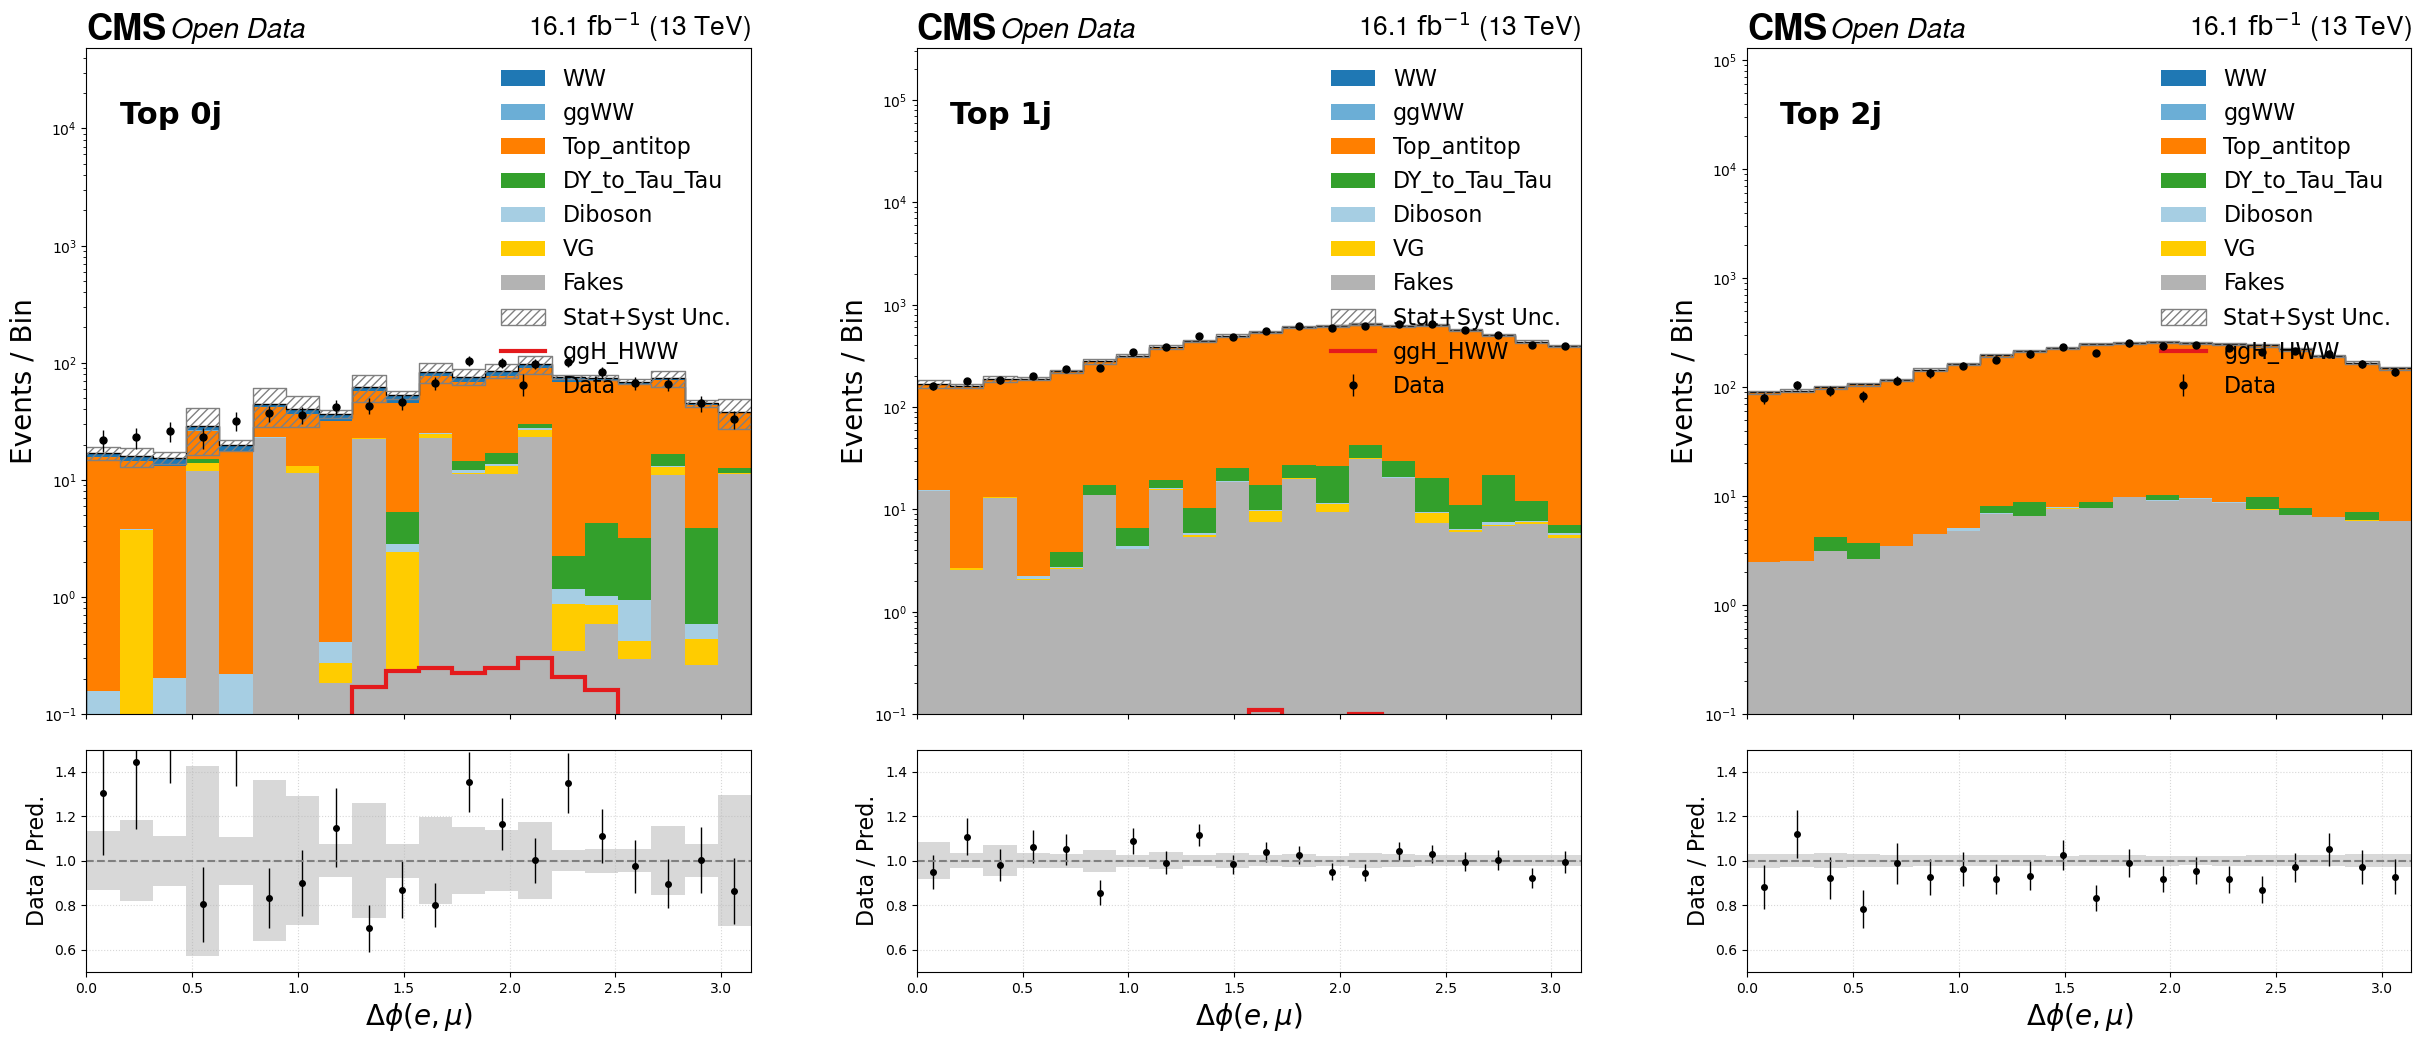

Plotting dphi in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_dphi.png


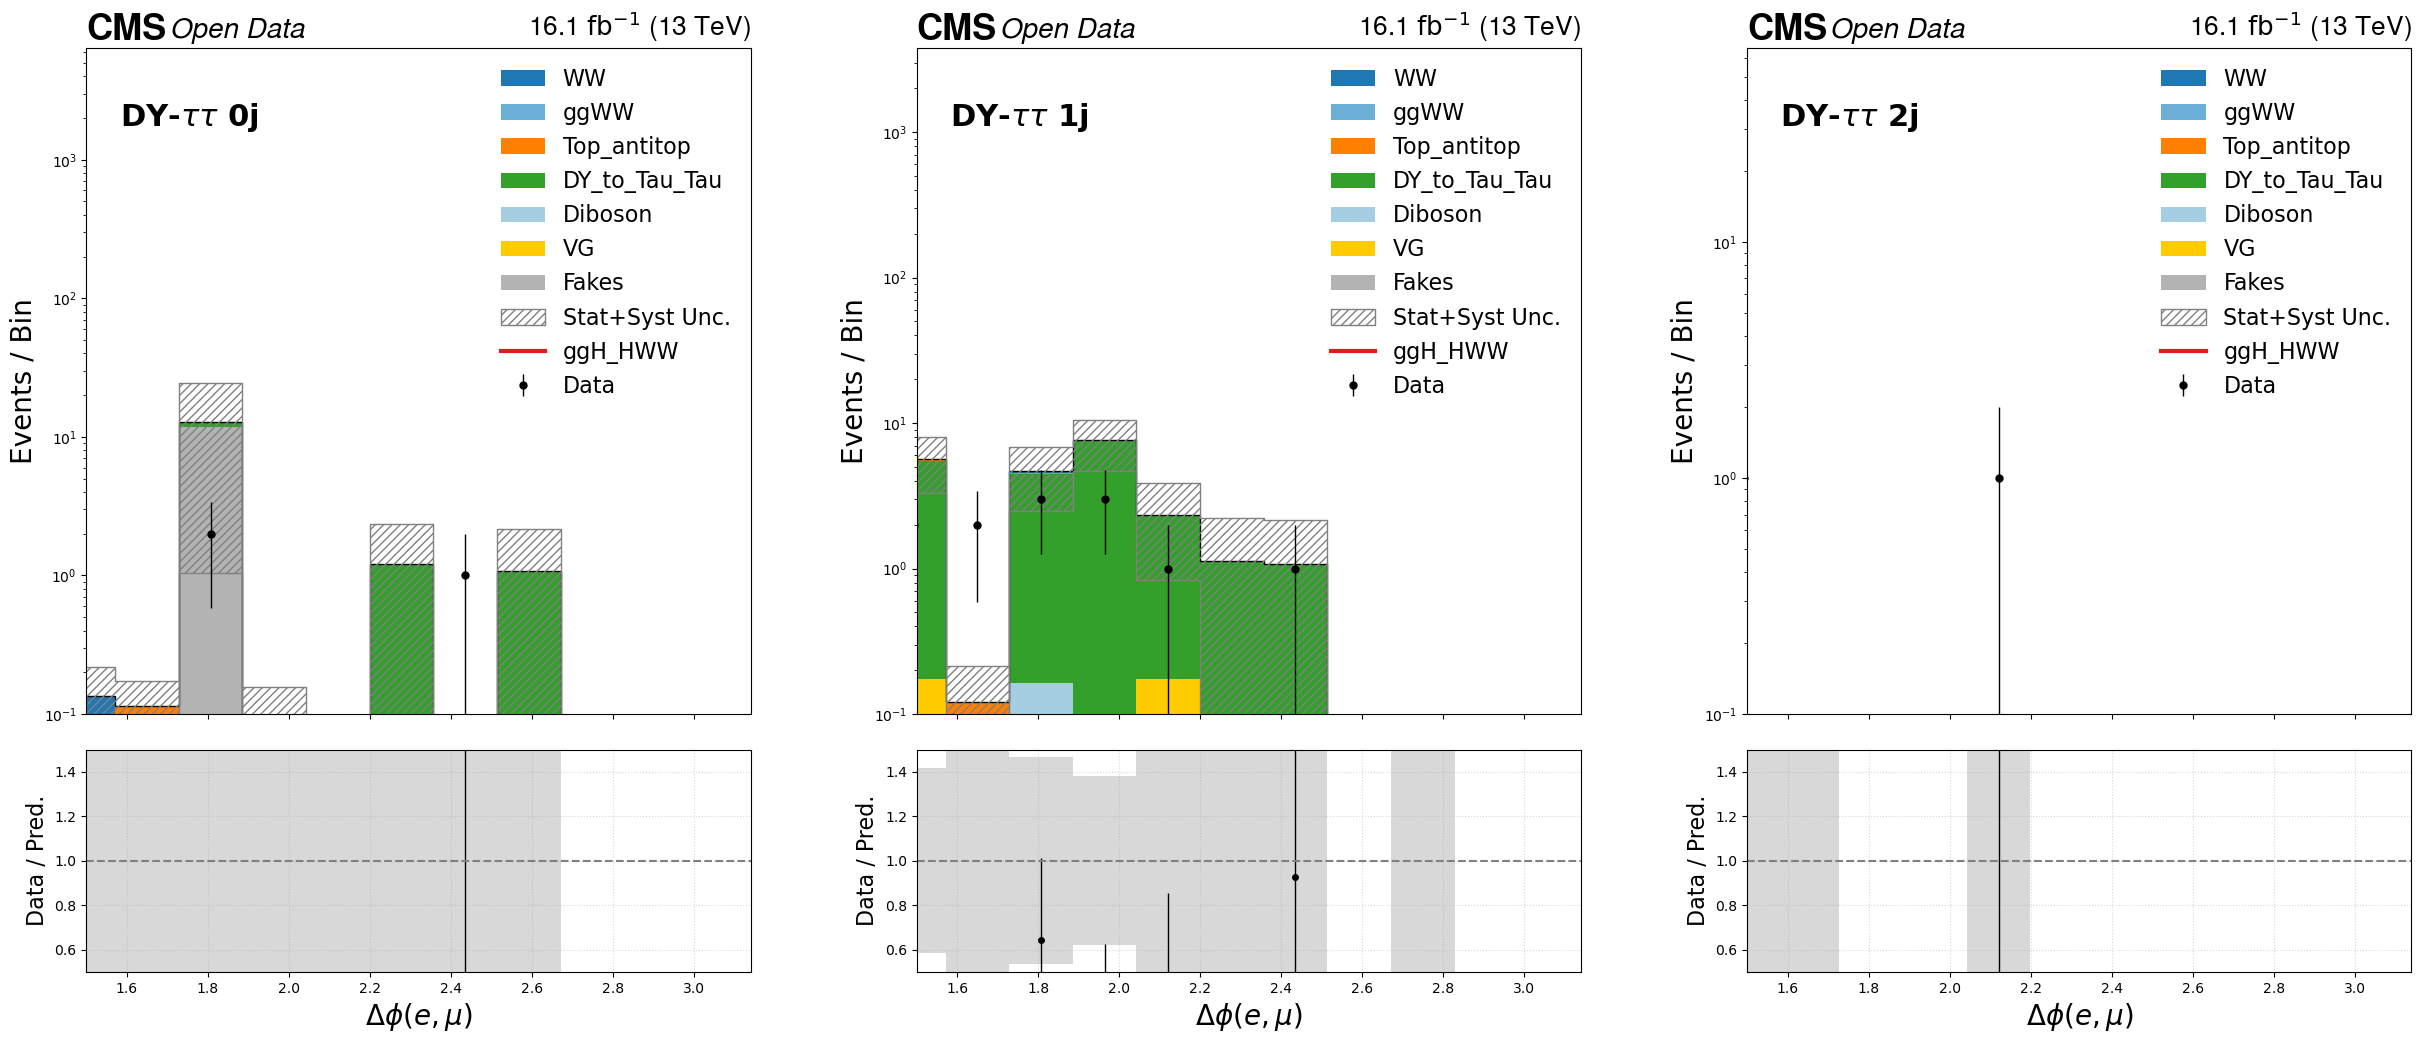

Plotting mt_higgs in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_higgs.png


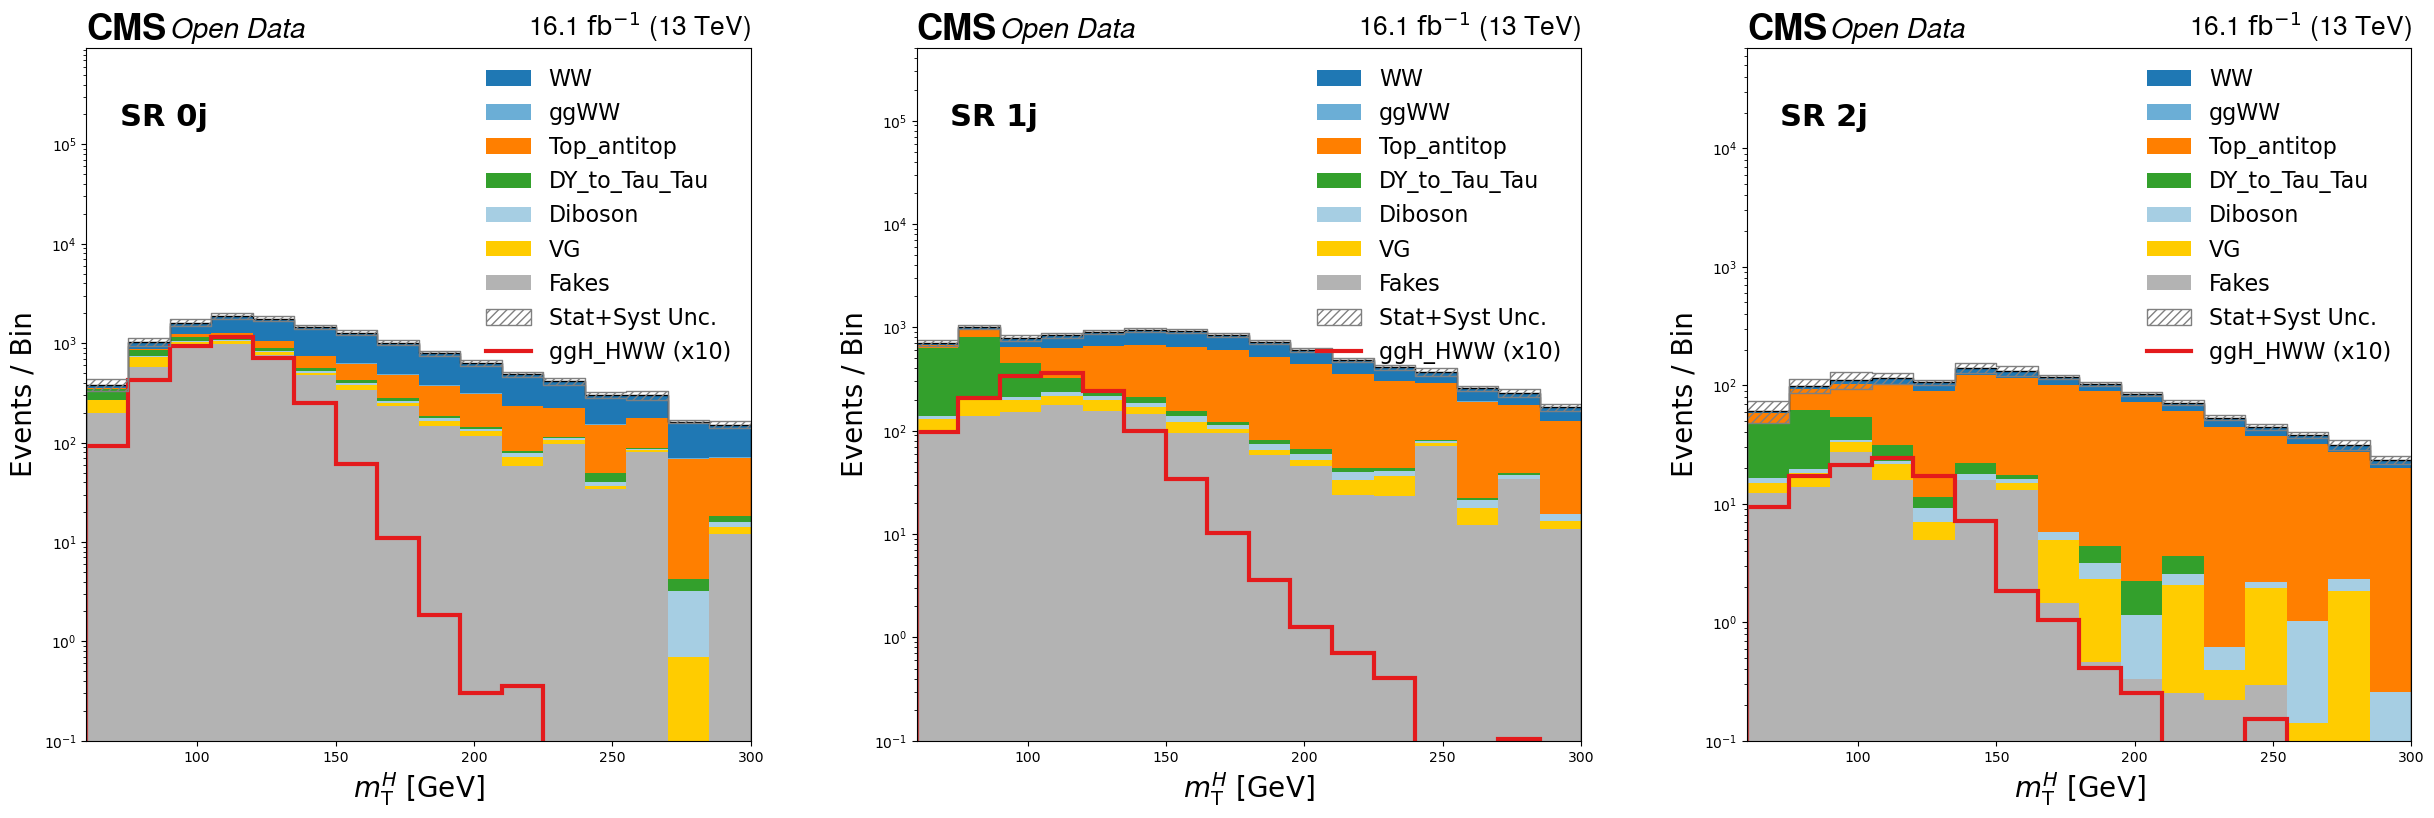

Plotting mt_higgs in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_higgs.png


Plotting mt_higgs in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_higgs.png


Plotting mt_l2_met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_l2_met.png


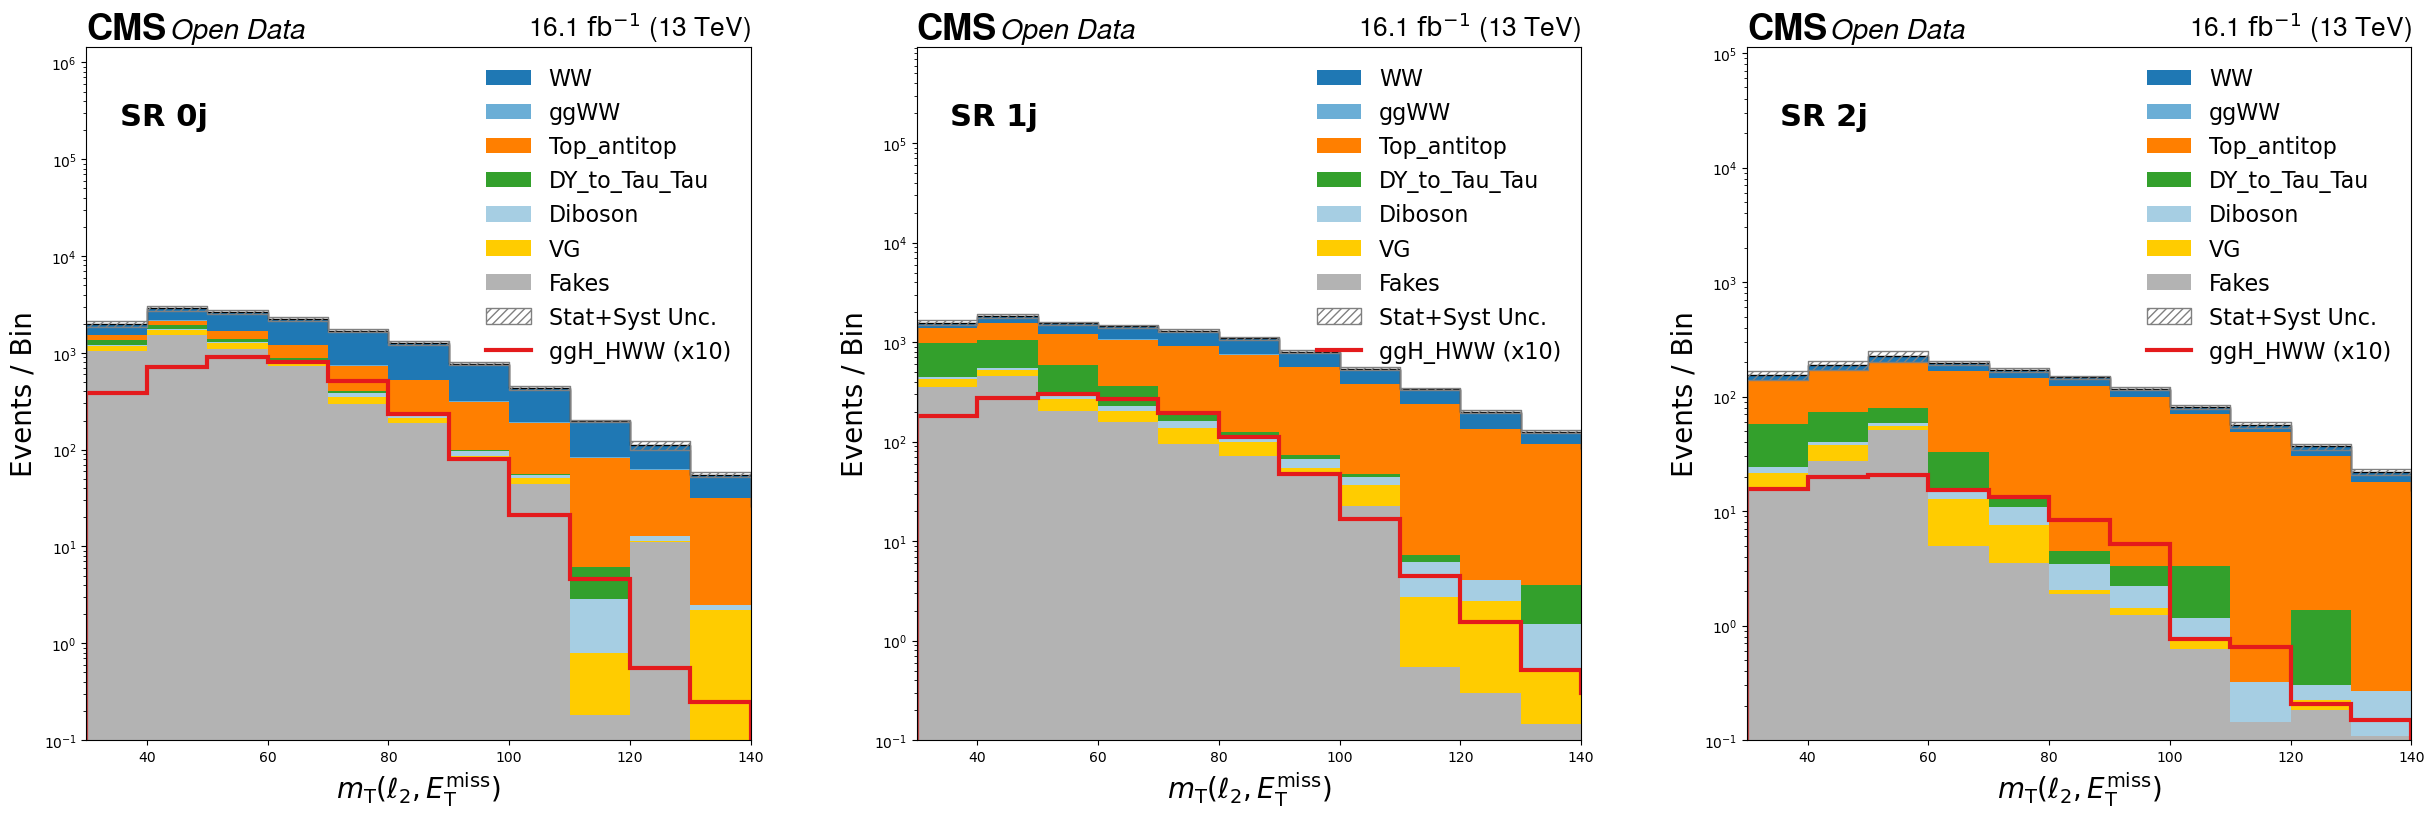

Plotting mt_l2_met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_l2_met.png


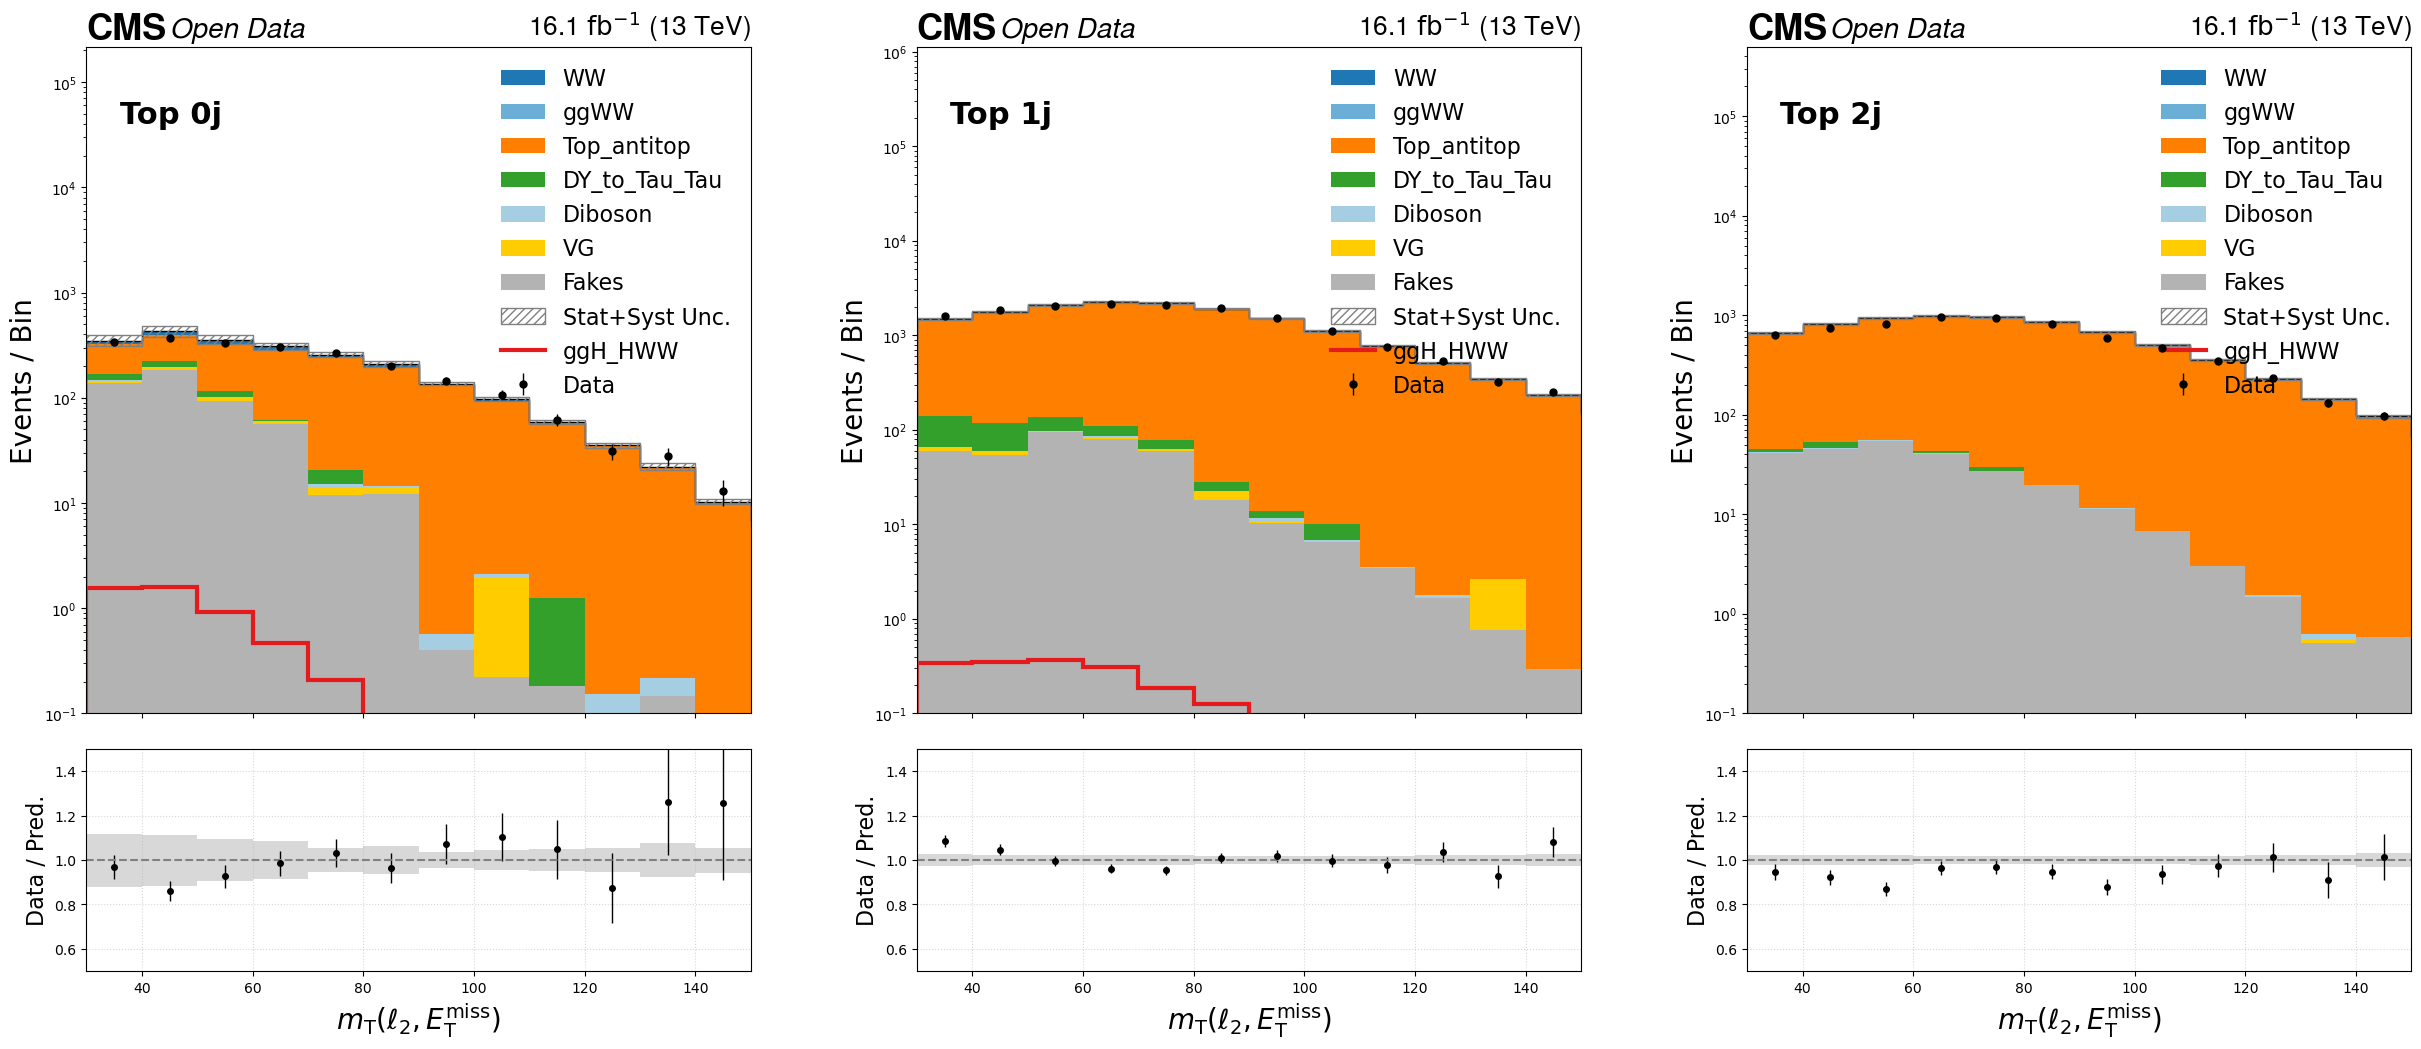

Plotting mt_l2_met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_l2_met.png


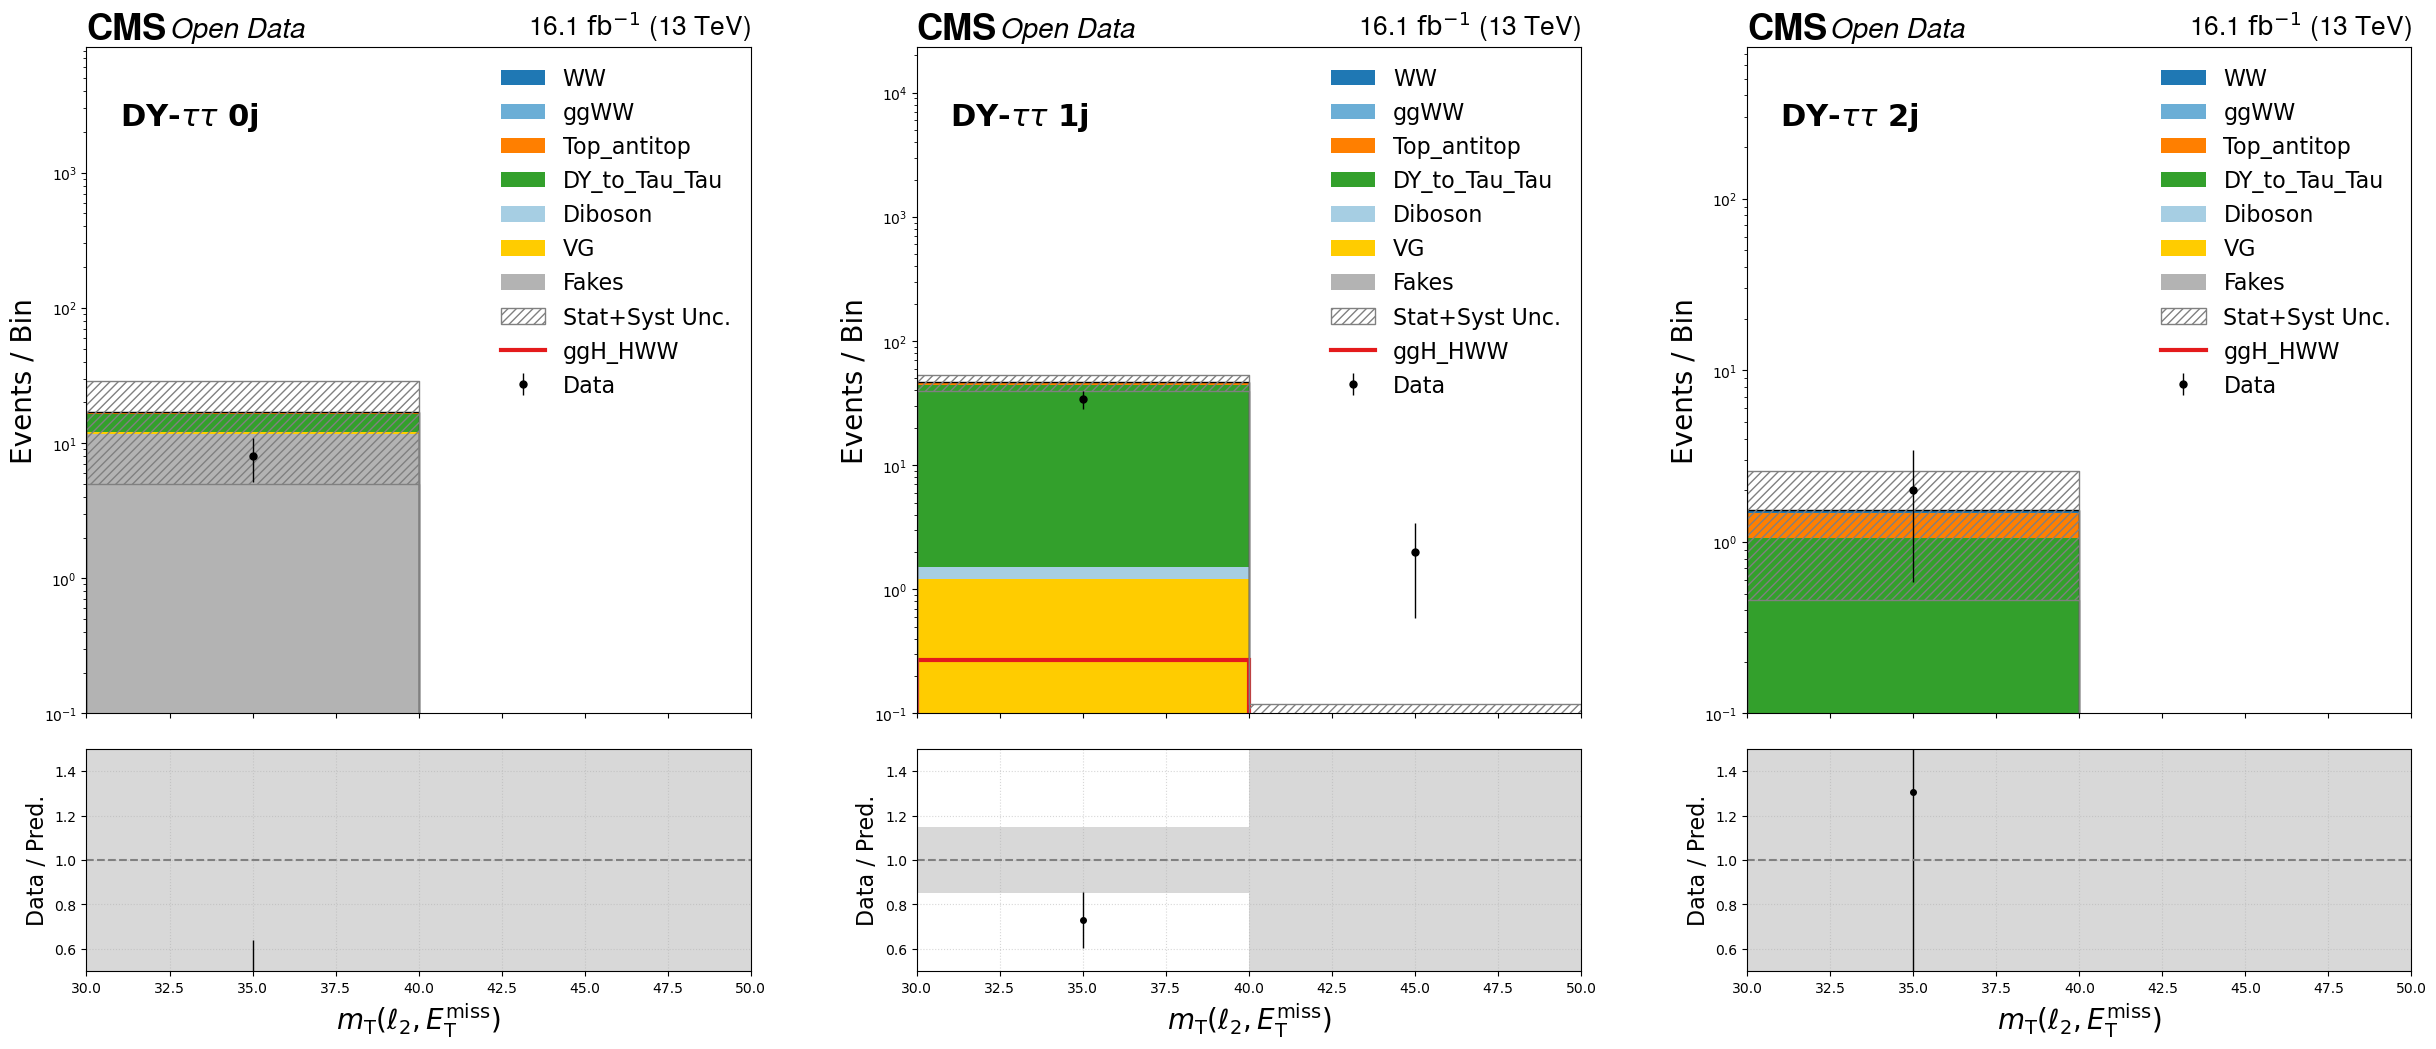

Plotting mjj in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mjj.png


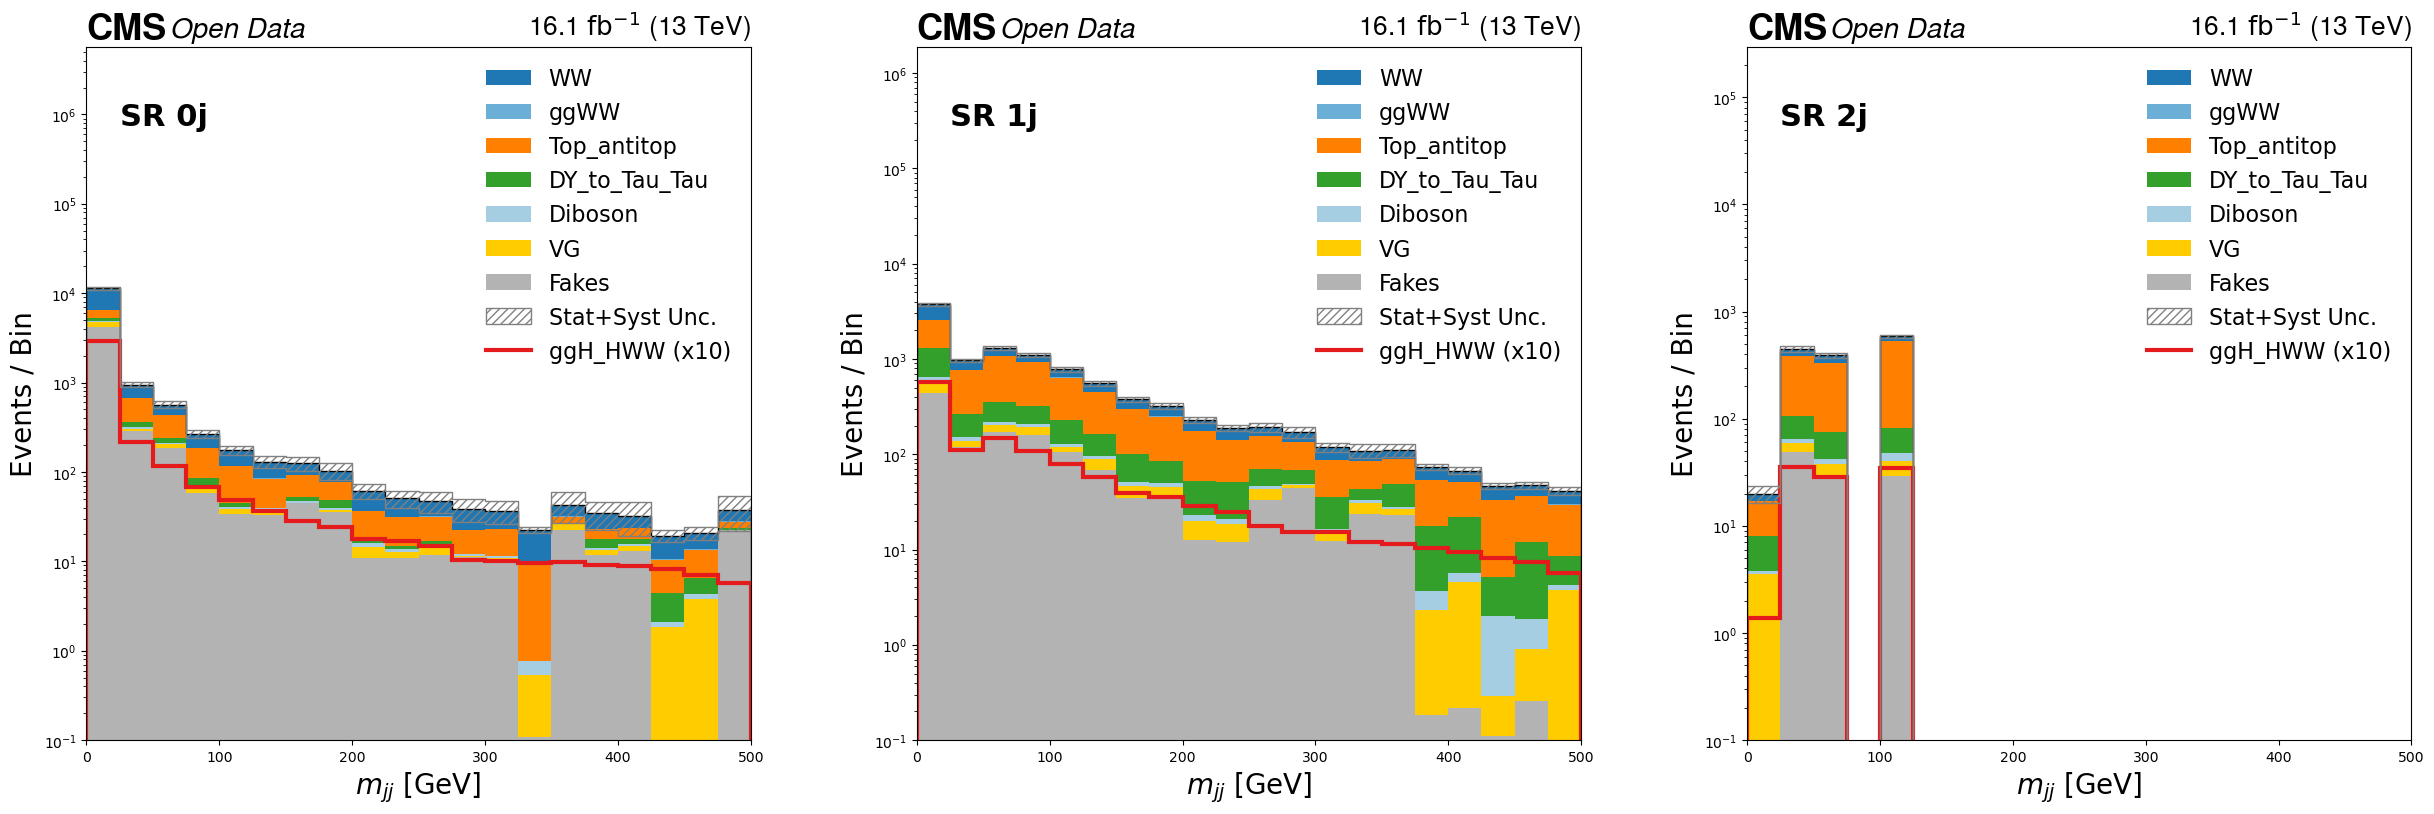

Plotting mjj in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mjj.png


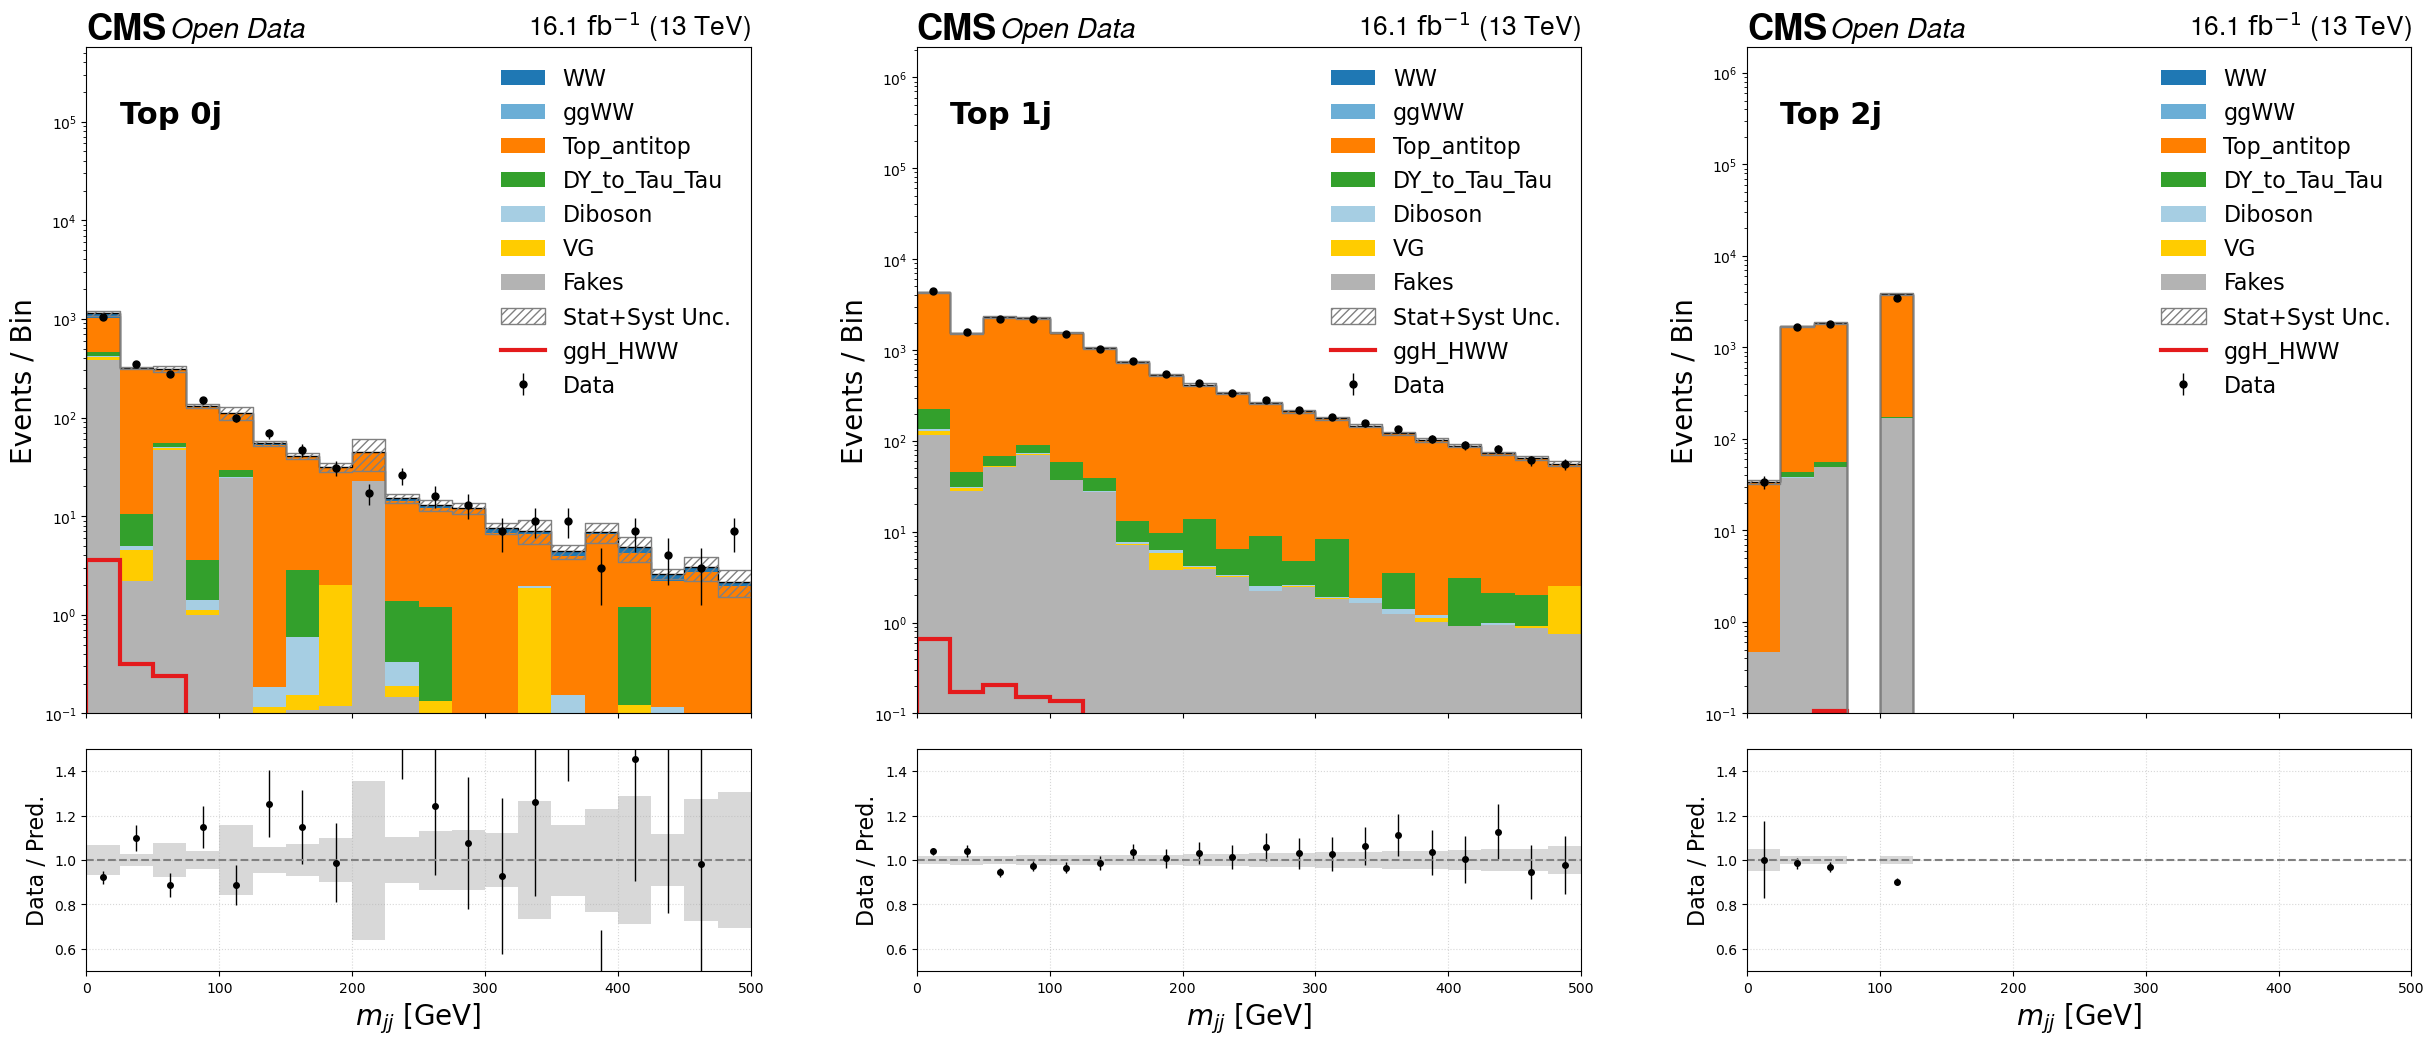

Plotting mjj in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mjj.png


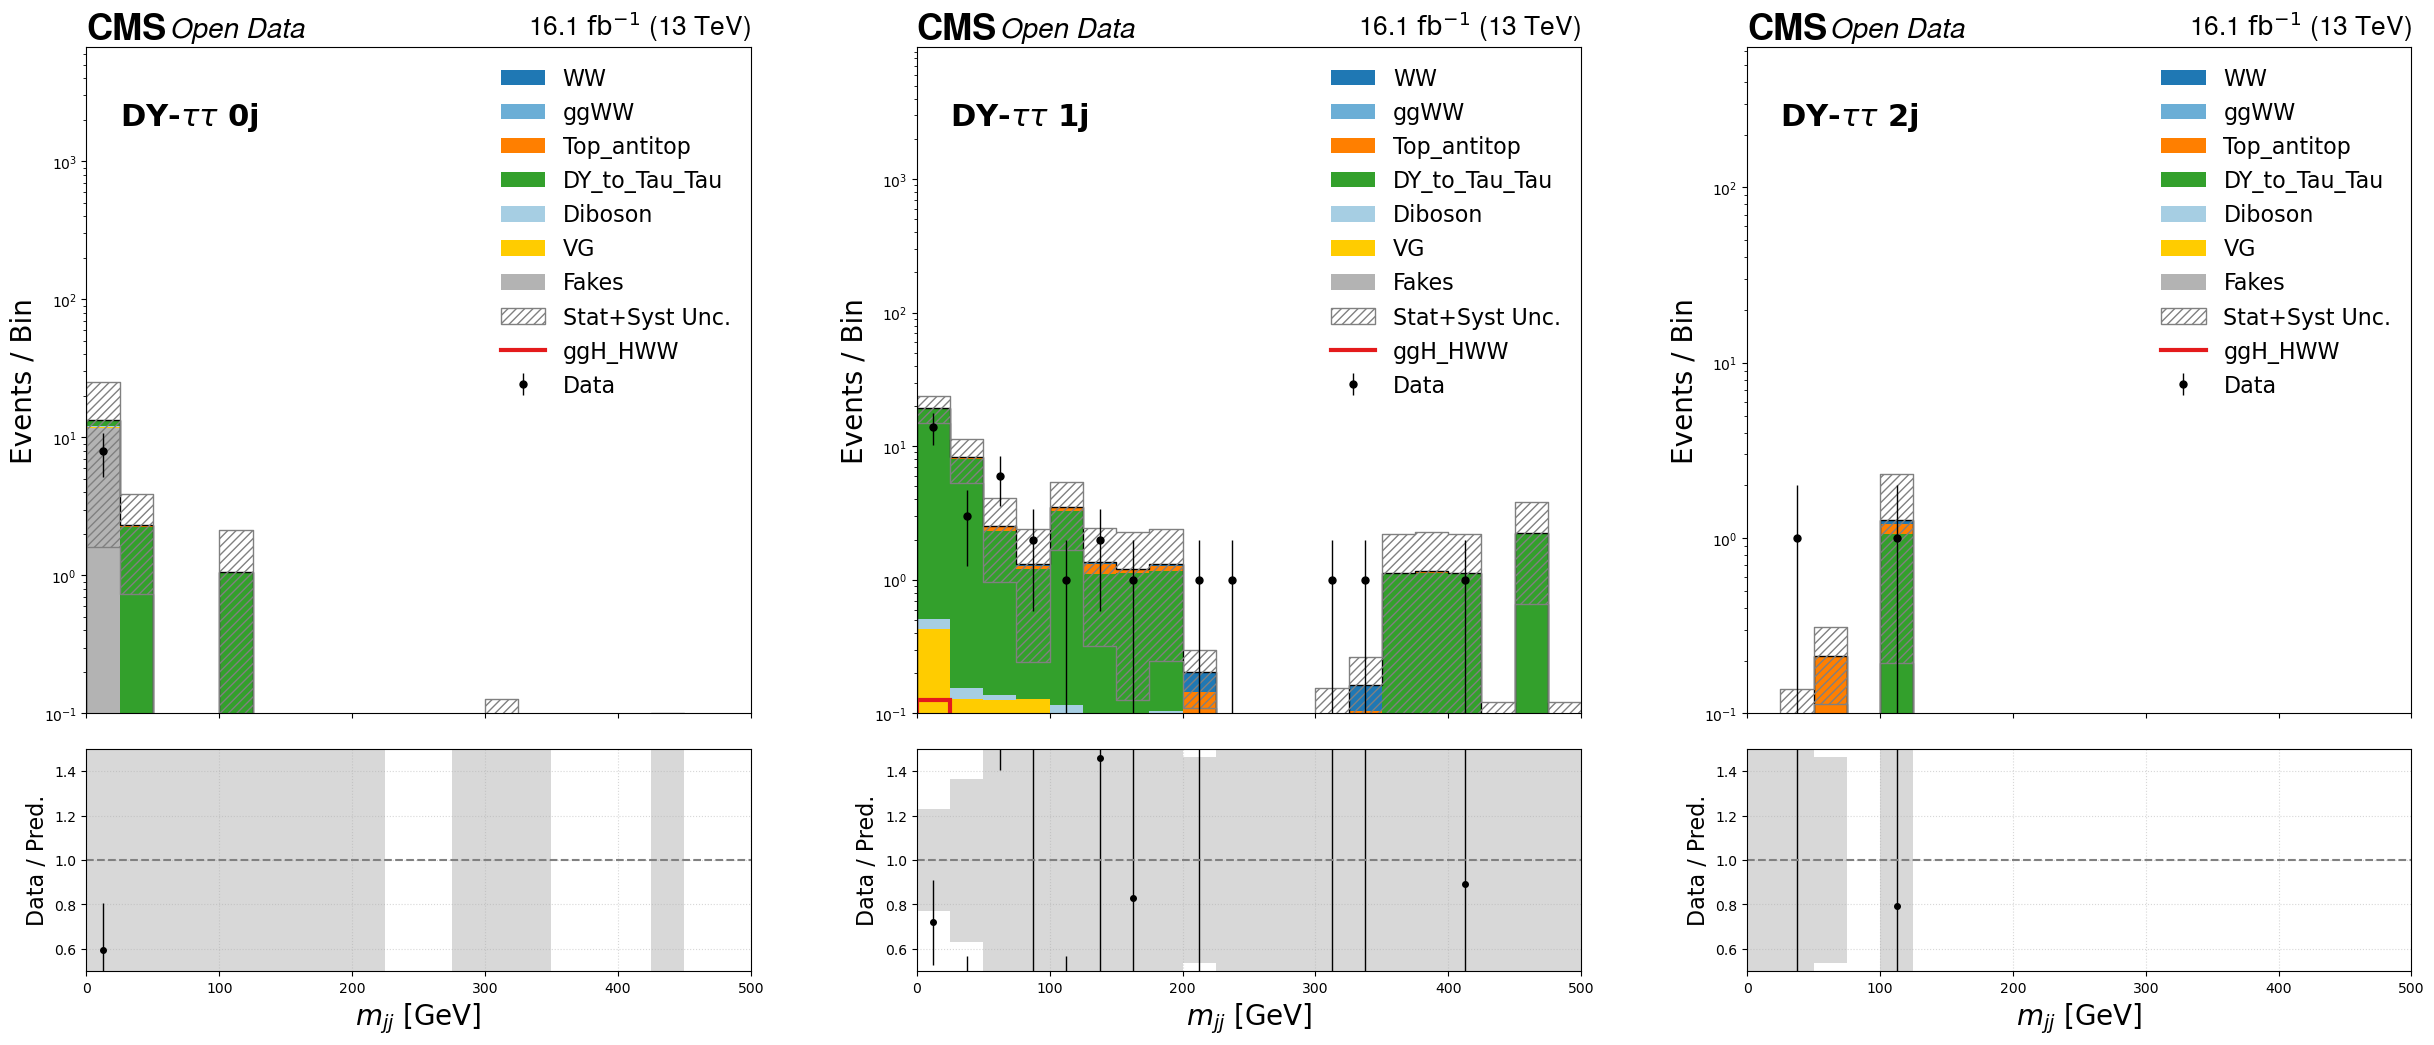

Plotting leading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_leading_pt.png


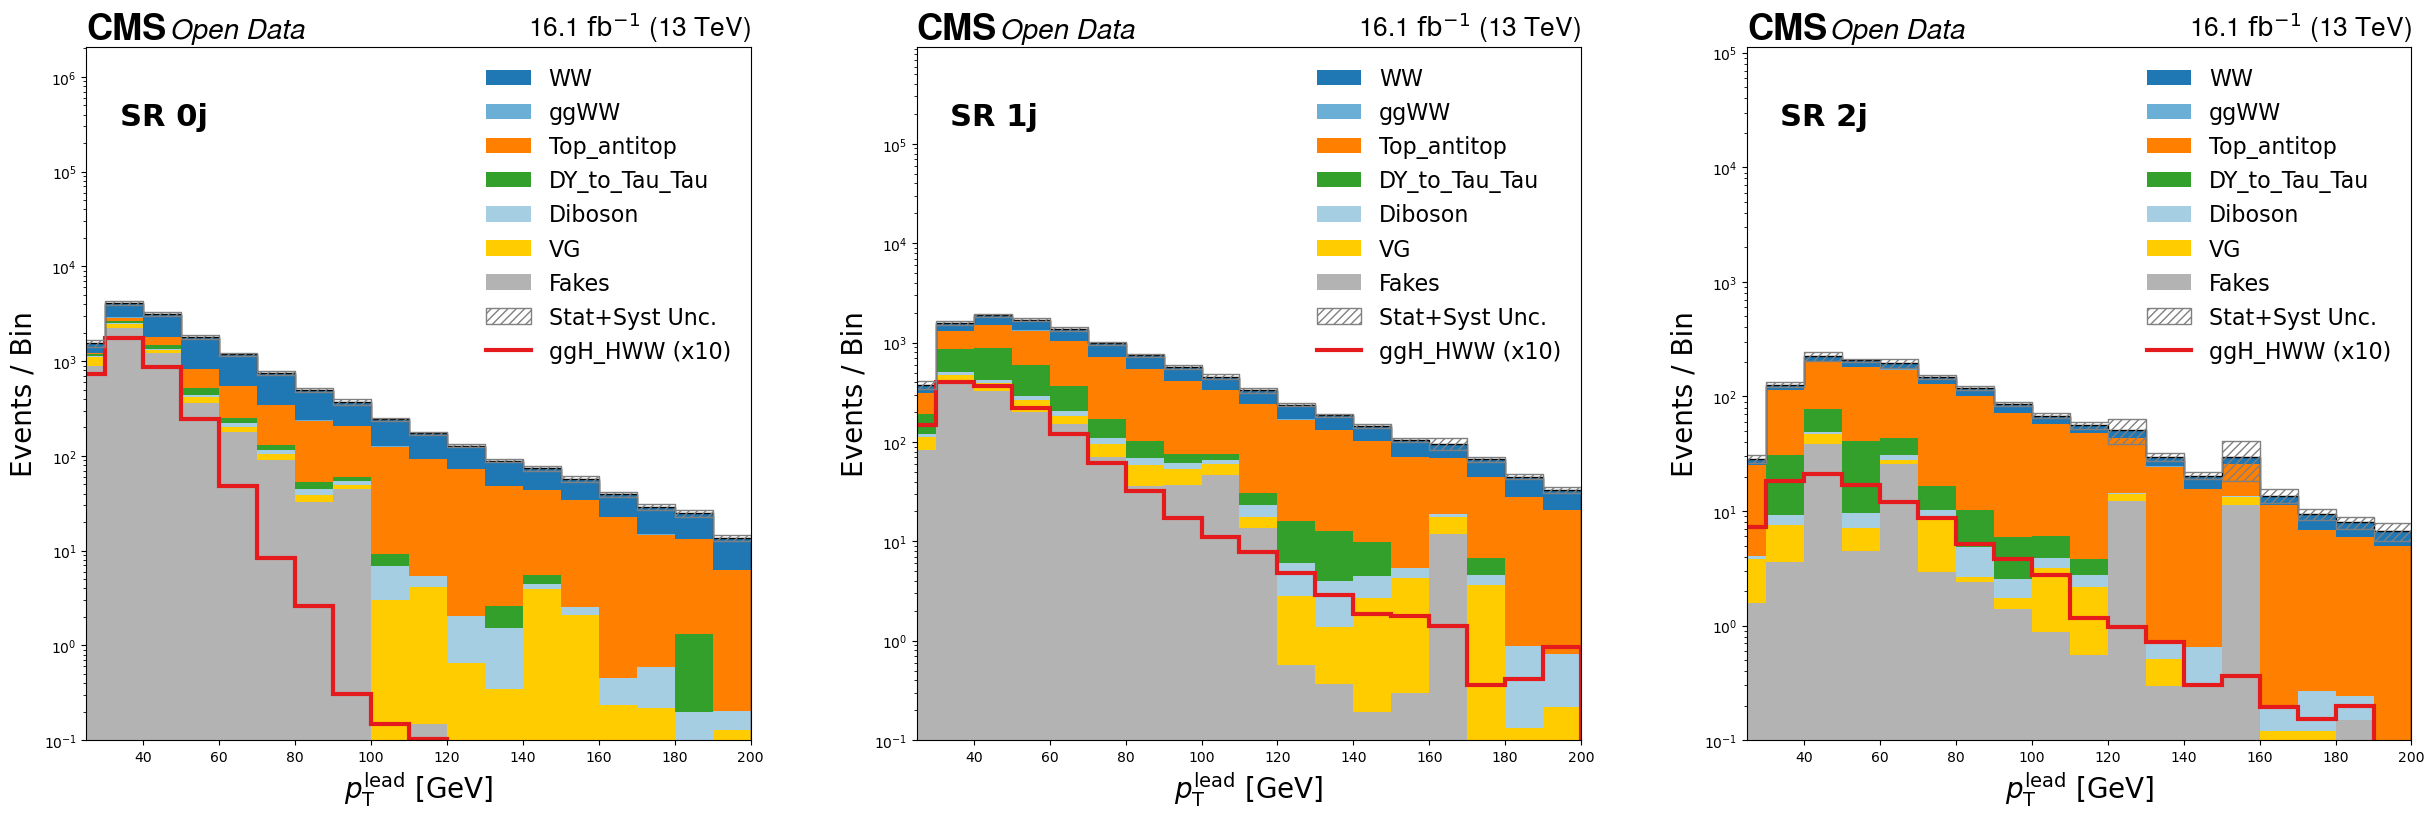

Plotting leading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_leading_pt.png


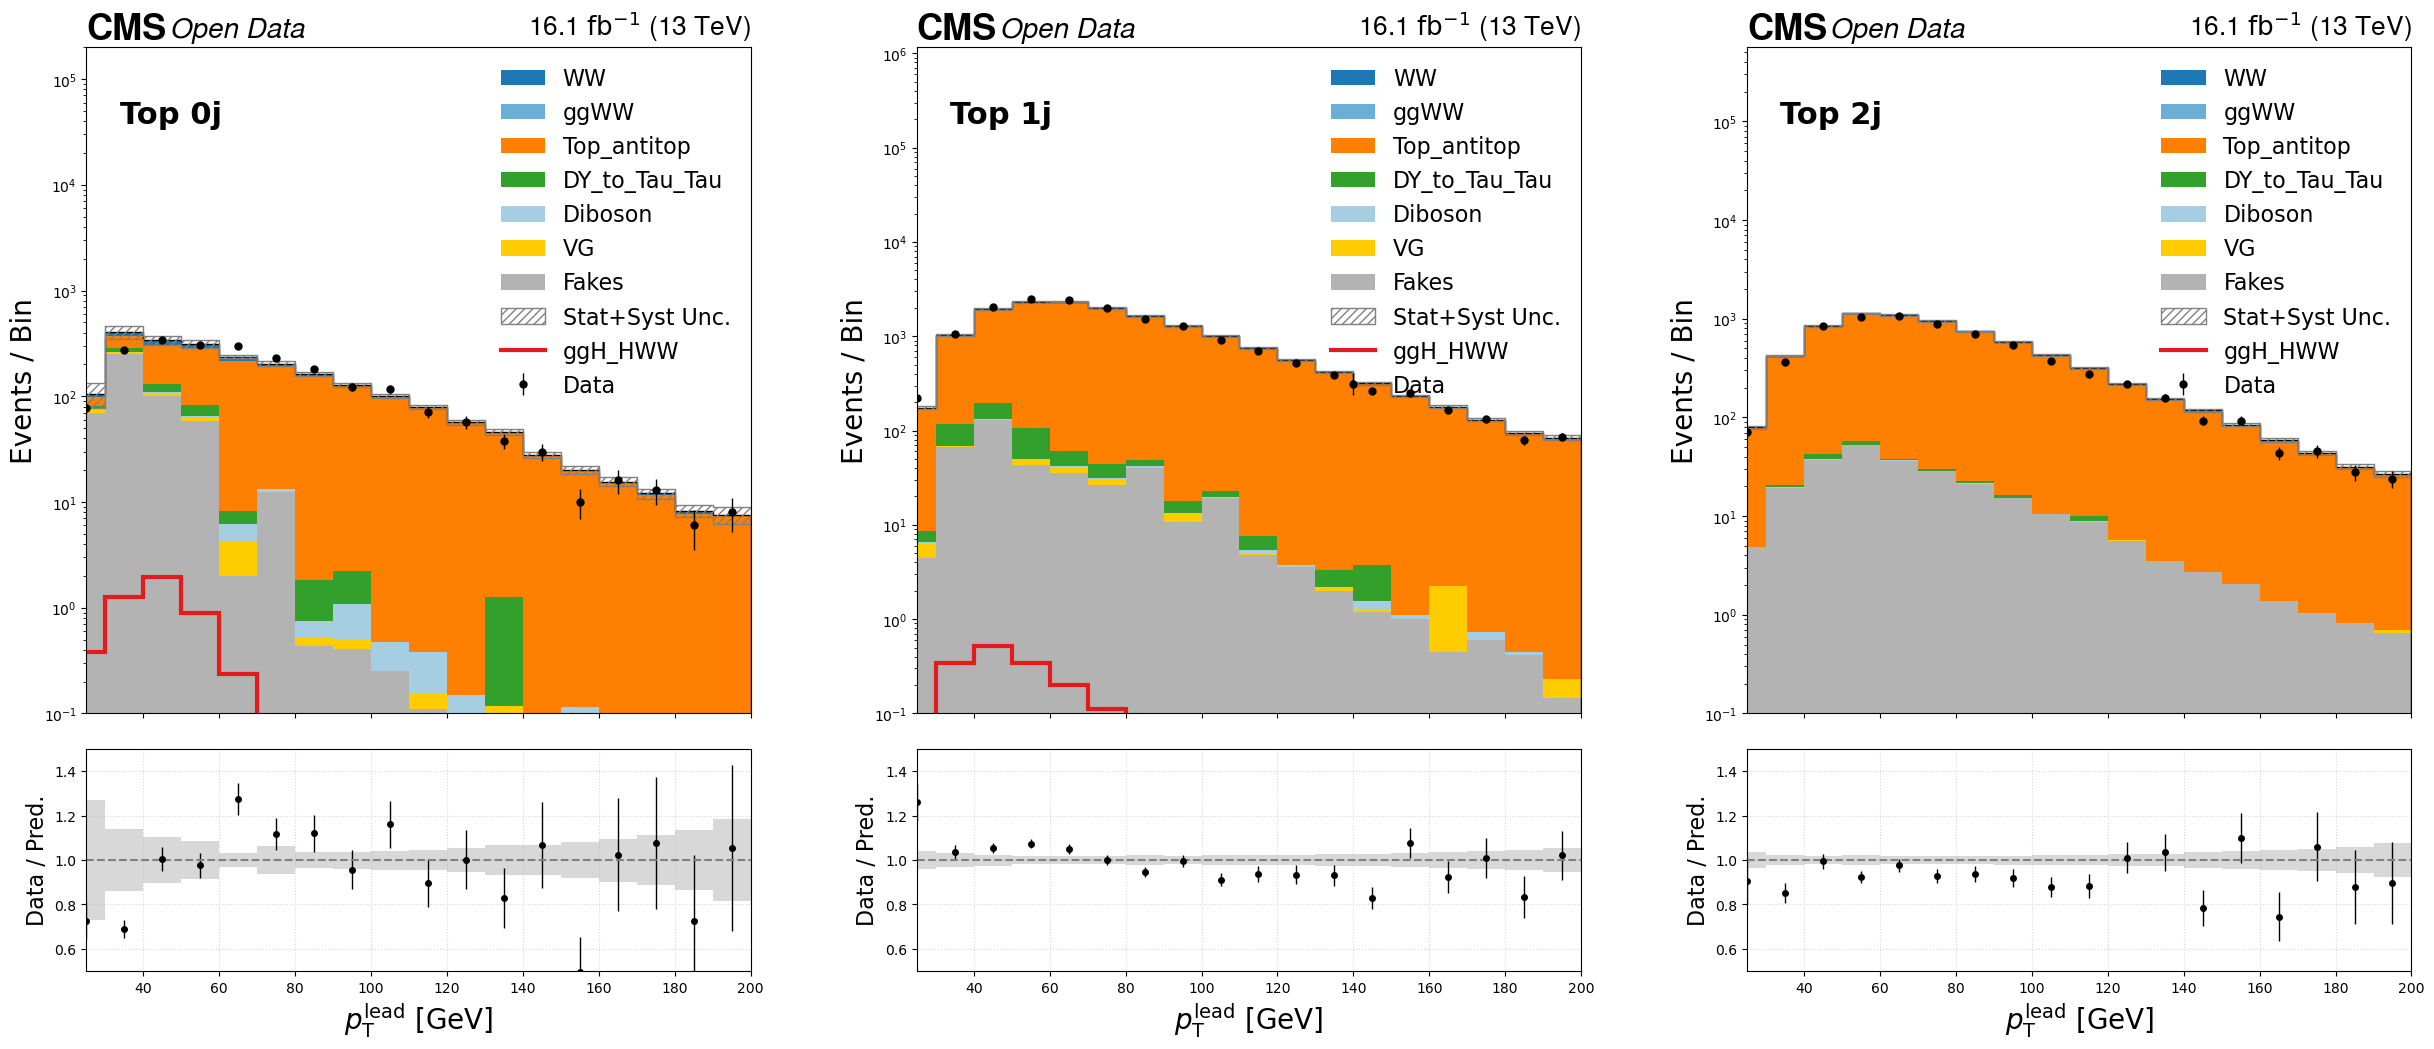

Plotting leading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_leading_pt.png


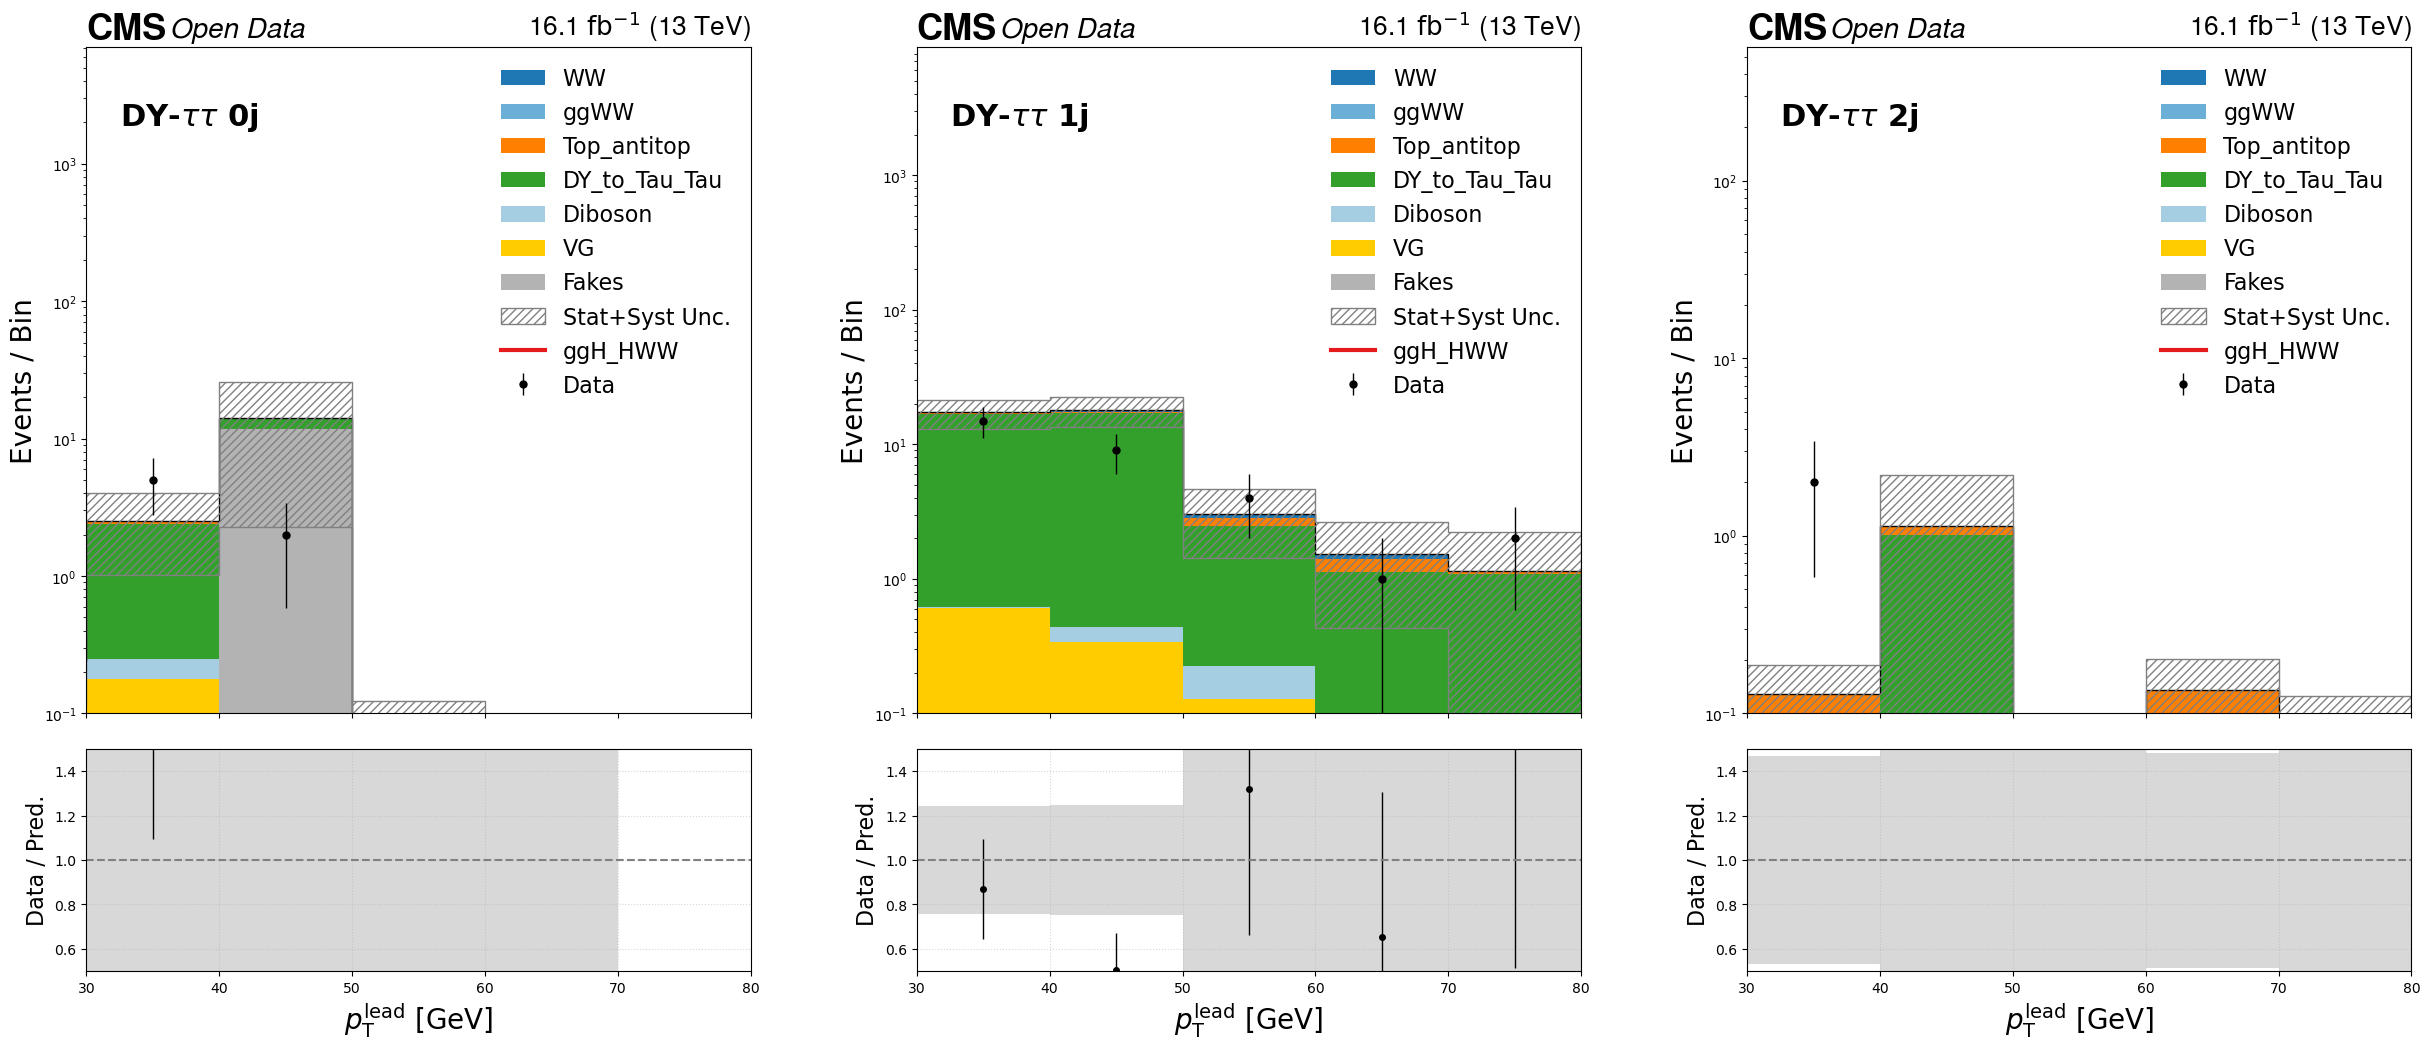

Plotting subleading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_subleading_pt.png


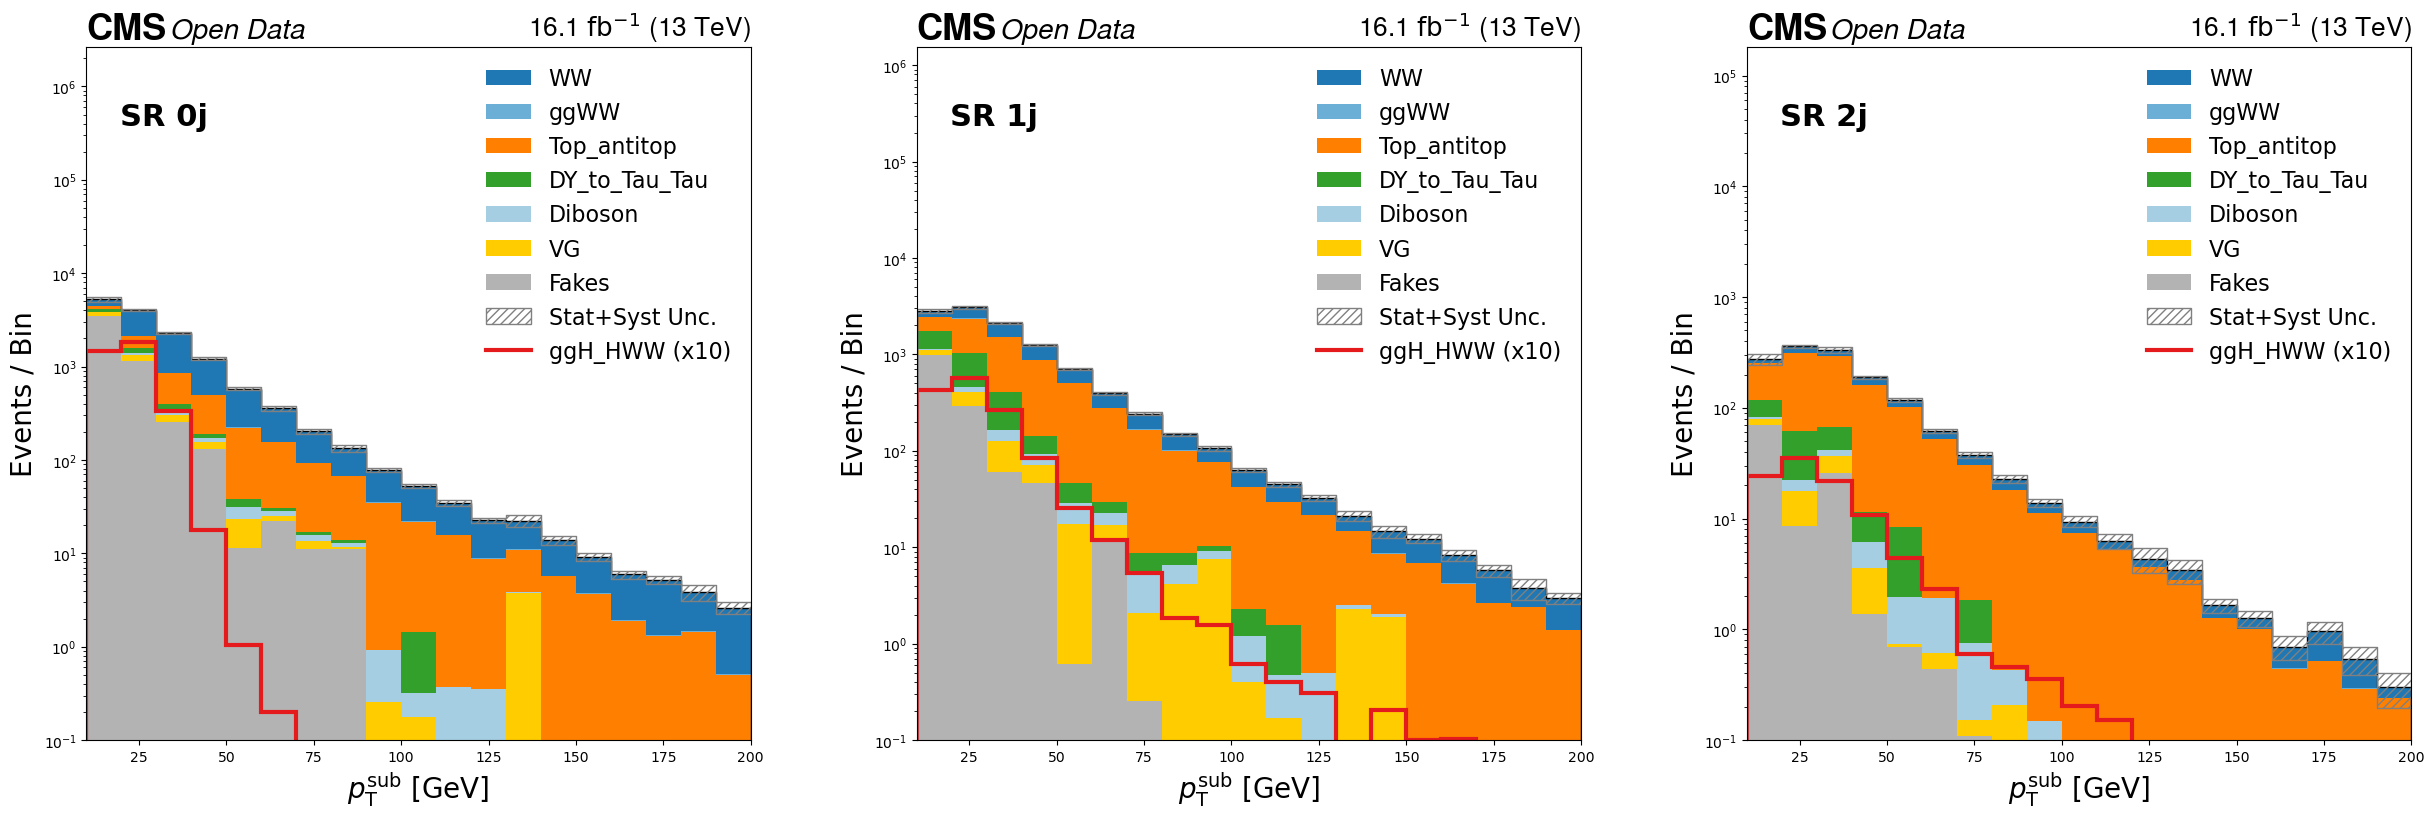

Plotting subleading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_subleading_pt.png


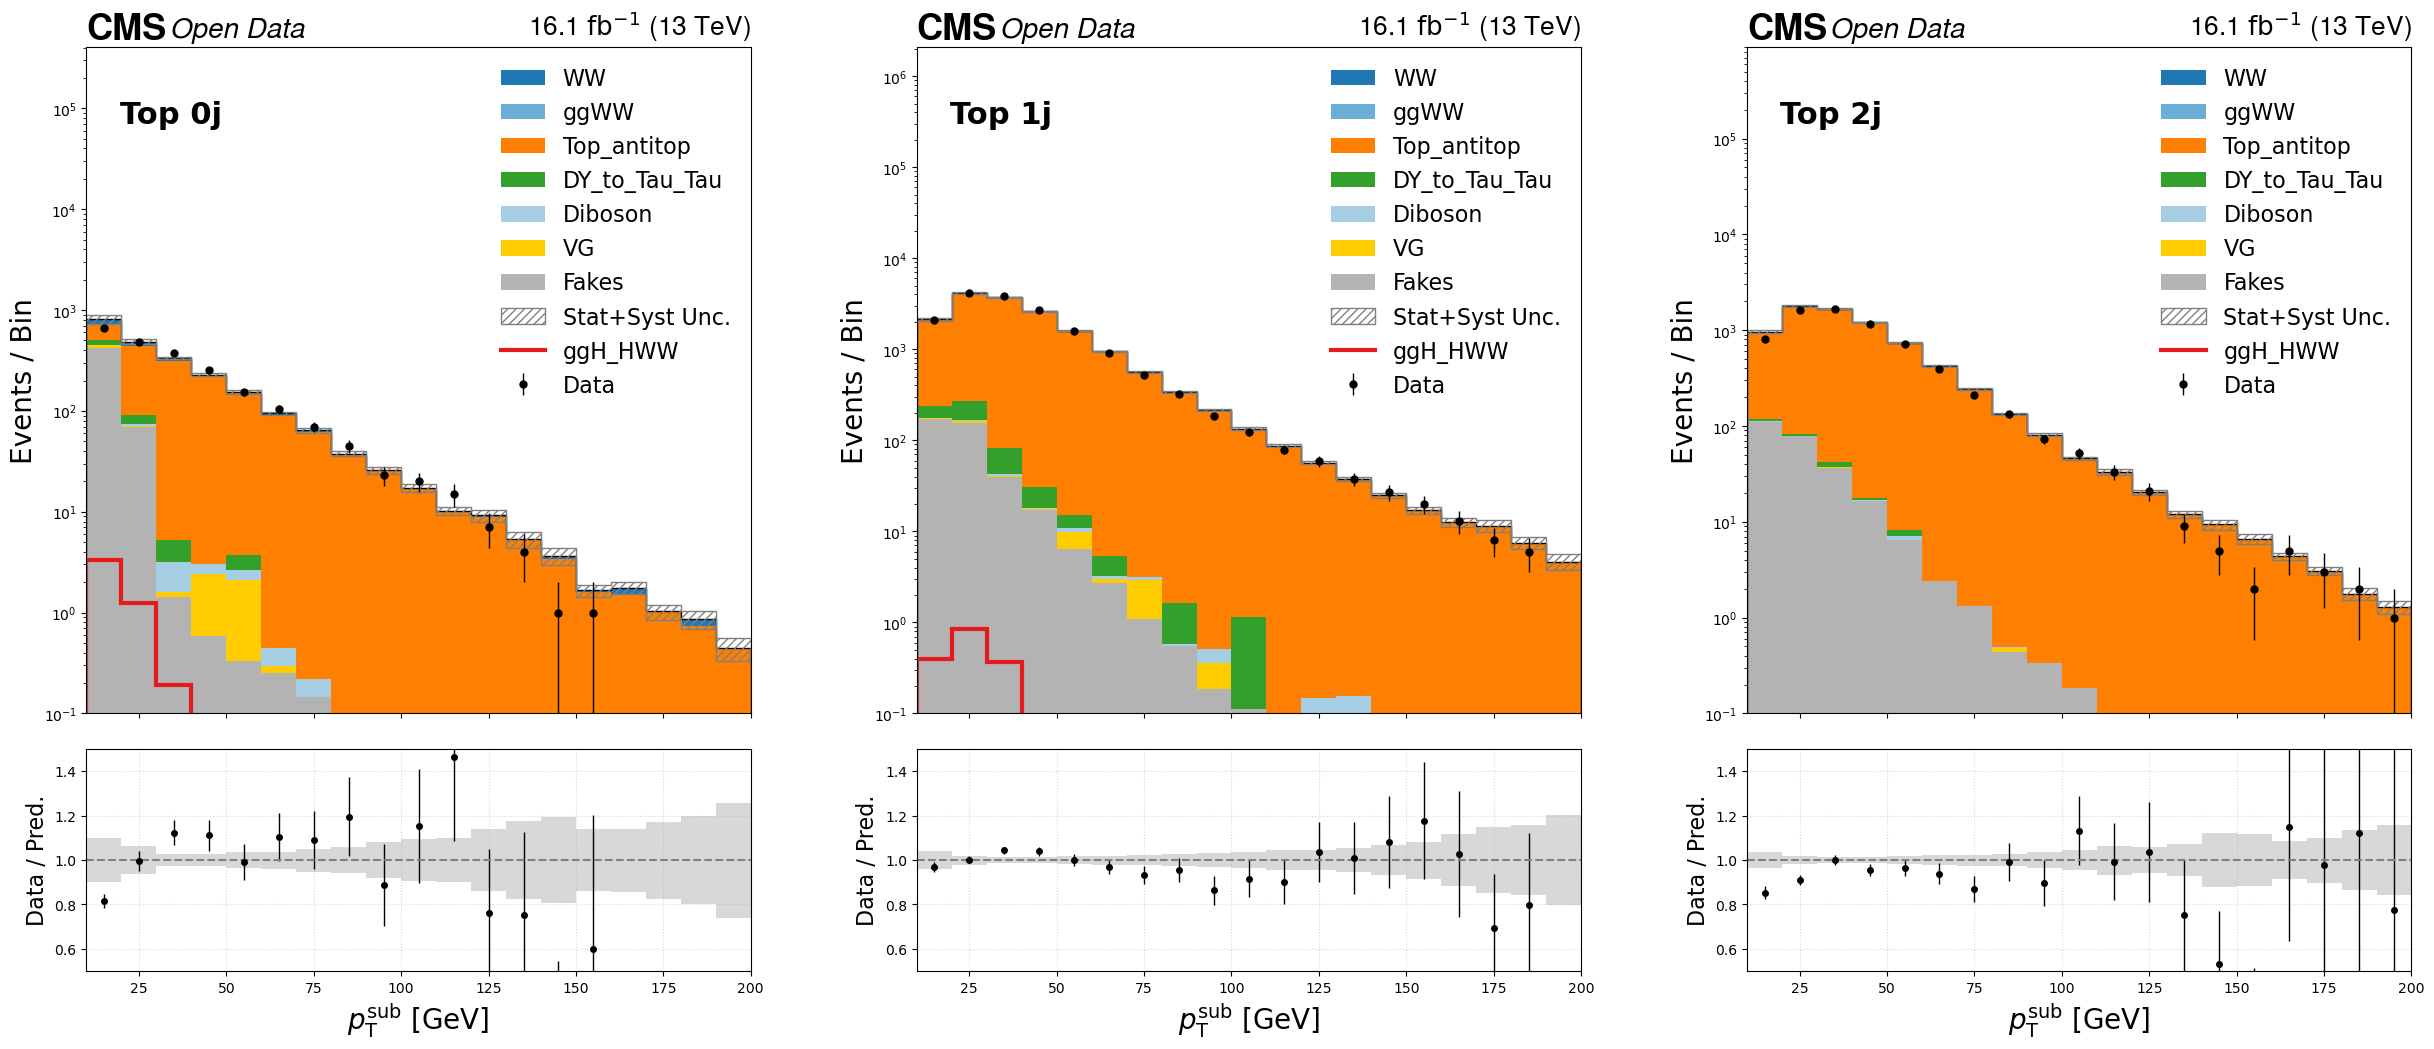

Plotting subleading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_subleading_pt.png



All plots saved to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked


In [44]:
print("\n" + "="*70)
print("GENERATING STACKED PLOTS...")
print("="*70)

output_dir = PLOTS_DIR / "Stacked"
output_dir.mkdir(parents=True, exist_ok=True)

for variable in VAR_LABELS.keys():
    try:
        stacked_plots(
            variable=variable, 
            hist_data_all=hist_data_final, 
            output_dir=output_dir
        )
    except Exception as e:
        print(f"FAILED to plot {variable}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nAll plots saved to: {output_dir}")